# Custom Image Classifier from Scratch

This notebook walks through the development of a convolutional neural network from the ground up—no pre-trained weights or external model zoos involved. We’ll cover everything from initial setup to packaging your predictions for submission.

---

> **Goal:** Build a classifier that achieves **≥ 85 %** accuracy on the public test split.  
> **Constraint:** All layers and parameters must be coded manually; do **not** use any pre-trained checkpoints.

---


# Initialization & Imports

This section sets up the environment by importing all dependencies, defining global constants for formatting and plotting, and configuring logging and profiling tools.

In [1]:
import os
import time
from dataclasses import dataclass
from typing import List, Union, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

### Global Text Formatting

Define ANSI escape codes for bold console output.

In [2]:
# Text formatting
bold = "\033[1m"
end = "\033[0m"

### Plotting Configuration

Set the default matplotlib style and a flag for block plotting behavior.

In [3]:
plt.style.use('ggplot')
block_plot = False

### Jupyter Notebook Magic

Enable inline plotting for Jupyter notebooks. Remove if running as a standalone script.

In [4]:
%matplotlib inline

# Data Processing & Transforms
This module provides functions to build preprocessing pipelines, compute dataset statistics, and prepare data loaders for training and validation.

## Preprocessing Transforms

Basic transforms for resizing images and converting them to tensors.

In [5]:
def image_preprocess_transforms(img_size):
    """
    Create basic image preprocessing transforms.

    Parameters:
        img_size (tuple[int, int] or int): Desired output size (height, width) for images.

    Returns:
        torchvision.transforms.Compose: Transform pipeline for resizing and tensor conversion.
    """
    return transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])

## Common Transforms with Normalization
Extends preprocessing transforms by adding channel-wise normalization.

In [6]:
def image_common_transforms(
    img_size=(224, 224),
    mean=(0.4611, 0.4359, 0.3905),
    std=(0.2193, 0.2150, 0.2109),
):
    """
    Build transform pipeline with normalization.

    Parameters:
        img_size (tuple[int, int]): Target size for images.
        mean (tuple[float, float, float]): Channel means for normalization.
        std (tuple[float, float, float]): Channel standard deviations for normalization.

    Returns:
        torchvision.transforms.Compose: Full pipeline including resize, tensor conversion, and normalization.
    """
    base = image_preprocess_transforms(img_size)
    return transforms.Compose([
        base,
        transforms.Normalize(mean=mean, std=std),
    ])

## Dataset Statistics

Compute channel-wise mean and standard deviation over a dataset.

In [7]:
def get_mean_std(
    data_root: str,
    img_size=(224, 224),
    num_workers: int = 4,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Calculate per-channel mean and standard deviation for images in a folder.

    Parameters:
        data_root (str): Path to dataset root (contains subfolders for classes).
        img_size (tuple[int, int]): Size for resizing during computation.
        num_workers (int): Number of DataLoader workers.

    Returns:
        mean (torch.Tensor): Channel-wise mean.
        std (torch.Tensor): Channel-wise standard deviation.
    """
    # Prepare loader with simple resize and ToTensor
    transform = image_preprocess_transforms(img_size)
    loader = data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=num_workers)

    # Accumulators
    batch_mean = torch.zeros(3)
    batch_mean_sq = torch.zeros(3)

    for images, _ in loader:
        batch_mean += images.mean(dim=[0, 2, 3])
        batch_mean_sq += (images ** 2).mean(dim=[0, 2, 3])

    mean = batch_mean / len(loader)
    var = (batch_mean_sq / len(loader)) - (mean ** 2)
    std = torch.sqrt(var)

    print(f"Computed mean: {mean}, std: {std}")
    return mean, std

## Data Loaders
Helpers to create training and validation loaders, with optional subsetting.

In [8]:
def data_loader(
    data_root: str,
    transform,
    batch_size: int = 16,
    shuffle: bool = False,
    num_workers: int = 2,
) -> DataLoader:
    """
    Create a DataLoader for all images in a folder.

    Parameters:
        data_root (str): Root directory of dataset.
        transform (callable): Transform pipeline to apply.
        batch_size (int): Number of samples per batch.
        shuffle (bool): Whether to shuffle the dataset.
        num_workers (int): Number of subprocesses for data loading.

    Returns:
        DataLoader: PyTorch DataLoader instance.
    """
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [9]:
def subset_data_loader(
    data_root: str,
    transform,
    batch_size: int = 8,
    shuffle: bool = False,
    num_workers: int = 2,
    subset_size: float = 0.05,
) -> DataLoader:
    """
    Create a DataLoader using a fixed subset of the dataset for quick iterations.

    Parameters:
        data_root (str): Root directory of dataset.
        transform (callable): Transform pipeline to apply.
        batch_size (int): Number of samples per batch.
        shuffle (bool): Whether to shuffle the subset.
        num_workers (int): Number of subprocesses for data loading.
        subset_size (float): Fraction of the full dataset to use.

    Returns:
        DataLoader: PyTorch DataLoader of the subset.
    """
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    total = len(dataset)
    indices = np.linspace(0, total - 1, int(total * subset_size), dtype=int)
    subset = Subset(dataset, indices)
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

## High-Level Data Preparation
Function to build train/validation loaders with optional augmentation and subsetting.

In [10]:
def get_data(
    batch_size: int,
    data_root: str,
    img_size=(224, 224),
    num_workers: int = 4,
    data_augmentation: bool = False,
    run_just_a_subset: bool = True,
) -> tuple[DataLoader, DataLoader]:
    """
    Prepare training and validation DataLoaders with preprocessing, normalization, and optional augmentation.

    Parameters:
        batch_size (int): Batch size for both loaders.
        data_root (str): Root directory containing 'Train' and 'Valid' subfolders.
        img_size (tuple[int, int]): Target image size.
        num_workers (int): Number of subprocesses for data loading.
        data_augmentation (bool): Whether to apply data augmentation on training data.
        run_just_a_subset (bool): If True, use a small subset for faster iteration.

    Returns:
        train_loader (DataLoader): DataLoader for training dataset.
        valid_loader (DataLoader): DataLoader for validation dataset.
    """

    train_data_path = os.path.join(data_root, "Train")
    valid_data_path = os.path.join(data_root, "Valid")

    # Compute dataset statistics for normalization
    mean, std = get_mean_std(data_root=train_data_path, img_size=img_size, num_workers=num_workers)
    common_transforms = image_common_transforms(img_size, mean, std)

    if data_augmentation:
        train_transforms = transforms.Compose([ 
            transforms.Resize(int(min(img_size)*1.15)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=(0, 359), translate=(0.1, 0.3), scale=(0.4, 1.05)),
            transforms.ColorJitter(brightness=.5, hue=.3),
            transforms.RandomEqualize(),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    else:
        train_transforms = common_transforms

    # Build loaders
    loader_fn = subset_data_loader if run_just_a_subset else data_loader
    train_loader = loader_fn(train_dir, train_transforms, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = loader_fn(valid_dir, common_transforms, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, valid_loader

# Training & Validation
This module provides:
- System and training configurations via dataclasses
- Environment setup for reproducible training
- `train` and `validate` functions with progress bars and metric tracking

## Configurations

### System Configuration

Dataclass to store system-level settings for reproducibility.

In [11]:
@dataclass
class SystemConfig:
    """
    Configuration for system-level reproducibility and performance.

    Attributes:
        seed (int): Random seed for all RNGs.
        cudnn_benchmark_enabled (bool): Enable CuDNN benchmark for speed.
        cudnn_deterministic (bool): Force deterministic CuDNN algorithms.
    """
    seed: int = 21
    cudnn_benchmark_enabled: bool = True
    cudnn_deterministic: bool = True

### Training Configuration

Dataclass capturing hyperparameters and paths for training and logging.

In [12]:
@dataclass
class TrainingConfig:
    """
    Hyperparameters and I/O paths for model training.

    Attributes:
        num_classes (int): Number of target classes.
        batch_size (int): Samples per batch.
        img_size (Tuple[int,int]): Input image dimensions.
        epochs_count (int): Total training epochs.
        decay_rate (float): Learning rate decay factor.
        init_learning_rate (float): Starting learning rate.
        data_root (str): Base path to dataset folder.
        num_workers (int): DataLoader worker count.
        device (str): Compute device ('cpu' or 'cuda').
        save_best_model_name (str): Filename for best model checkpoint.
        save_last_model_name (str): Filename for last model checkpoint.
        root_log_dir (str): Base directory for TensorBoard logs.
        root_checkpoint_dir (str): Base directory for saved checkpoints.
        log_dir (str): Subdirectory name for current run logs.
        checkpoint_dir (str): Subdirectory name for current run checkpoints.
    """
    num_classes: int = 3
    batch_size: int = 16
    img_size: Tuple[int, int] = (238, 238)
    epochs_count: int = 60
    decay_rate: float = 0.01
    init_learning_rate: float = 1e-3
    data_root: str = "./dataset"
    num_workers: int = 6
    device: str = "cuda"

    save_best_model_name: str = "cat_dog_panda_classifier.pt"
    save_last_model_name: str = "cat_dog_panda_classifier_last.pt"
    root_log_dir: str = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir: str = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    log_dir: str = "version_0"
    checkpoint_dir: str = "version_0"

## System Setup

Function to apply system-wide settings before training.

In [13]:
def setup_system(config: SystemConfig) -> None:
    """
    Initialize randomness and CuDNN settings for reproducible performance.

    Args:
        config (SystemConfig): System settings dataclass.
    """
    # Seed all PyTorch RNGs
    torch.manual_seed(config.seed)
    # Configure CuDNN
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = config.cudnn_deterministic

## Training Loop

Runs one epoch of training, updates model parameters, and logs metrics.

In [14]:
def train(
    train_config: TrainingConfig,
    model: nn.Module,
    optimizer: optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    epoch_idx: int,
    total_epochs: int,
) -> Tuple[float, float]:
    """
    Execute one training epoch.

    Args:
        train_config (TrainingConfig): Training hyperparameters.
        model (nn.Module): PyTorch model to train.
        optimizer (optim.Optimizer): Optimizer instance.
        train_loader (DataLoader): Training data loader.
        epoch_idx (int): Current epoch index (1-based).
        total_epochs (int): Total number of epochs.

    Returns:
        epoch_loss (float): Average loss over epoch.
        epoch_acc (float): Average accuracy over epoch.
    """
    model.train()
    # Metrics
    acc_metric = MulticlassAccuracy(num_classes=train_config.num_classes, average="micro")
    loss_metric = MeanMetric()
    device = train_config.device

    header = f"Train: Epoch {epoch_idx}/{total_epochs}"
    prog_bar = tqdm(train_loader, desc=header, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

    for batch in prog_bar:
        data, target = batch
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        # Update metrics
        loss_metric(loss.item(), weight=data.size(0))
        preds = output.argmax(dim=1)
        acc_metric(preds, target)

        # Update progress bar
        curr_loss = loss_metric.compute()
        curr_acc = acc_metric.compute()
        prog_bar.set_postfix(loss=f"{curr_loss:.4f}", acc=f"{curr_acc:.4f}")

    epoch_loss = loss_metric.compute()
    epoch_acc = acc_metric.compute()
    prog_bar.close()
    return epoch_loss, epoch_acc

## Validation Loop

Evaluates model performance on validation set without gradient updates.

In [15]:
def validate(
    train_config: TrainingConfig,
    model: nn.Module,
    valid_loader: torch.utils.data.DataLoader,
    epoch_idx: int,
    total_epochs: int,
) -> Tuple[float, float]:
    """
    Execute one validation epoch.

    Args:
        train_config (TrainingConfig): Training hyperparameters.
        model (nn.Module): PyTorch model to evaluate.
        valid_loader (DataLoader): Validation data loader.
        epoch_idx (int): Current epoch index (1-based).
        total_epochs (int): Total number of epochs.

    Returns:
        valid_loss (float): Average validation loss.
        valid_acc (float): Average validation accuracy.
    """
    model.eval()
    acc_metric = MulticlassAccuracy(num_classes=train_config.num_classes, average="micro")
    loss_metric = MeanMetric()
    device = train_config.device

    header = f"Valid: Epoch {epoch_idx}/{total_epochs}"
    prog_bar = tqdm(valid_loader, desc=header, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

    with torch.no_grad():
        for batch in prog_bar:
            data, target = batch
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)

            loss_metric(loss.item(), weight=data.size(0))
            preds = output.argmax(dim=1)
            acc_metric(preds, target)

            curr_loss = loss_metric.compute()
            curr_acc = acc_metric.compute()
            prog_bar.set_postfix(loss=f"{curr_loss:.4f}", acc=f"{curr_acc:.4f}")

    valid_loss = loss_metric.compute()
    valid_acc = acc_metric.compute()
    prog_bar.close()
    return valid_loss, valid_acc

# Utilities: Saving, Loading, Logging & Visualization

This module includes helper functions for model persistence, logging directory management, performance plotting, and the main training orchestration.

## Model Persistence

Functions to save and load PyTorch model state dictionaries.

In [16]:
def save_model(
    model,
    device,
    model_dir: str = "models",
    model_file_name: str = "cat_dog_panda_classifier.pt",
) -> None:
    """
    Save model state_dict to disk, ensuring it's on CPU before serialization.

    Args:
        model (nn.Module): Trained model instance.
        device (str): Device descriptor from current training ('cpu' or 'cuda').
        model_dir (str): Directory to save the model file.
        model_file_name (str): Filename for the saved model.
    """
    # Ensure directory exists
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, model_file_name)

    # Temporarily move model to CPU for saving
    if device == "cuda":
        model.to("cpu")

    torch.save(model.state_dict(), model_path)

    # Restore model to original device
    if device == "cuda":
        model.to("cuda")

In [17]:
def load_model(
    model,
    model_dir: str = "models",
    model_file_name: str = "cat_dog_panda_classifier.pt",
    device: torch.device = torch.device("cpu"),
):
    """
    Load state_dict from disk into model, mapping to specified device.

    Args:
        model (nn.Module): Model instance to load weights into.
        model_dir (str): Directory where model file is stored.
        model_file_name (str): Filename of the model checkpoint.
        device (torch.device): Device mapping for loaded tensors.

    Returns:
        nn.Module: Model with loaded parameters.
    """
    model_path = os.path.join(model_dir, model_file_name)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    return model

## Logging Directory Setup

Function to manage TensorBoard log and checkpoint directories with automatic versioning.

In [18]:
def setup_log_directory(
    training_config: TrainingConfig = TrainingConfig(),
):
    """
    Create new versioned subdirectories for logs and checkpoints under the root paths.

    Args:
        training_config (TrainingConfig): Configuration holding root paths and defaults.

    Returns:
        Tuple[TrainingConfig, str]: Updated config and new version string.
    """
    root_logs = training_config.root_log_dir
    if os.path.isdir(root_logs):
        # Extract existing version numbers
        versions = [
            int(name.replace("version_", ""))
            for name in os.listdir(root_logs)
            if name.startswith("version_") and name.replace("version_", "").isdigit()
        ]
        next_version = max(versions, default=-1) + 1
        version_name = f"version_{next_version}"
    else:
        version_name = training_config.log_dir

    # Update directories
    training_config.log_dir = os.path.join(root_logs, version_name)
    training_config.checkpoint_dir = os.path.join(
        training_config.root_checkpoint_dir, version_name
    )

    os.makedirs(training_config.log_dir, exist_ok=True)
    os.makedirs(training_config.checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Checkpoints at: {training_config.checkpoint_dir}")
    return training_config, version_name

## Performance Visualization

Plot training vs. validation loss and accuracy over epochs.

In [19]:
def plot_loss_accuracy(
    train_loss,
    val_loss,
    train_acc,
    val_acc,
    colors,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(20, 10),
    sub_plot1=(1, 2, 1),
    sub_plot2=(1, 2, 2),
) -> None:
    """
    Generate and save a combined plot of loss and accuracy curves.

    Args:
        train_loss (List[List[float]]): Loss histories for each run.
        val_loss (List[List[float]]): Validation loss histories.
        train_acc (List[List[float]]): Training accuracy histories.
        val_acc (List[List[float]]): Validation accuracy histories.
        colors (List[str]): Tab color names for each run.
        loss_legend_loc (str): Legend location for loss plot.
        acc_legend_loc (str): Legend location for accuracy plot.
        fig_size (Tuple[int,int]): Figure dimensions in inches.
        sub_plot1 (Tuple[int,int,int]): Grid spec for loss subplot.
        sub_plot2 (Tuple[int,int,int]): Grid spec for accuracy subplot.
    """
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()

    # Loss subplot
    plt.subplot(*sub_plot1)
    for idx, losses in enumerate(train_loss):
        epochs = range(len(losses))
        min_tr = min(losses)
        min_val = min(val_loss[idx])
        plt.plot(
            epochs,
            losses,
            linestyle="-",
            label=f"Train Loss ({min_tr:.4f})",
            color=f"tab:{colors[idx]}",
        )
        plt.plot(
            epochs,
            val_loss[idx],
            linestyle="--",
            label=f"Val Loss ({min_val:.4f})",
            color=f"tab:{colors[idx]}",
        )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc=loss_legend_loc)
    plt.title("Training vs. Validation Loss")

    # Accuracy subplot
    plt.subplot(*sub_plot2)
    for idx, accs in enumerate(train_acc):
        epochs = range(len(accs))
        max_tr = max(accs)
        max_val = max(val_acc[idx])
        plt.plot(
            epochs,
            accs,
            linestyle="-",
            label=f"Train Acc ({max_tr:.4f})",
            color=f"tab:{colors[idx]}",
        )
        plt.plot(
            epochs,
            val_acc[idx],
            linestyle="--",
            label=f"Val Acc ({max_val:.4f})",
            color=f"tab:{colors[idx]}",
        )
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc=acc_legend_loc)
    plt.title("Training vs. Validation Accuracy")

    fig.savefig("loss_acc_plot.png")
    plt.show()

## Main Training Routine

Orchestrates system setup, data loading, training loops, logging, checkpointing, and returns histories.

In [20]:
def main(
    model,
    summary_writer: SummaryWriter,
    use_scheduler: bool = False,
    system_config: SystemConfig = SystemConfig(),
    training_config: TrainingConfig = TrainingConfig(),
    data_augmentation: bool = True,
    run_just_a_subset: bool = True,
) -> tuple:
    """
    Run full training and validation cycles, handle checkpointing and TensorBoard logging.

    Args:
        model (nn.Module): Neural network instance.
        summary_writer (SummaryWriter): TensorBoard writer.
        use_scheduler (bool): Whether to apply LR scheduling.
        system_config (SystemConfig): Reproducibility settings.
        training_config (TrainingConfig): Hyperparameters and paths.
        data_augmentation (bool): Toggle training augmentations.
        run_just_a_subset (bool): Quick subset mode for debugging.

    Returns:
        Tuple: (
            epoch_train_loss, epoch_train_acc,
            epoch_valid_loss, epoch_valid_acc
        )
    """
    # Initialize environment
    setup_system(system_config)

    # Prepare data loaders
    train_loader, valid_loader = get_data(
        batch_size=training_config.batch_size,
        data_root=training_config.data_root,
        img_size=training_config.img_size,
        num_workers=training_config.num_workers,
        data_augmentation=data_augmentation,
        run_just_a_subset=run_just_a_subset,
    )

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    # Optimizer and optional scheduler
    optimizer = optim.Adam(
        model.parameters(),
        lr=training_config.init_learning_rate,
        amsgrad=True,
    )
    scheduler = None
    if use_scheduler:
        schedule_fn = lambda epoch: 1 / (1 + training_config.decay_rate * epoch)
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=schedule_fn)

    # Histories and best metrics
    best_loss = torch.tensor(np.inf)
    best_acc = 0.0
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []

    start_time = time.time()
    for epoch in range(1, training_config.epochs_count + 1):
        tr_loss, tr_acc = train(
            training_config, model, optimizer, train_loader, epoch, training_config.epochs_count
        )
        val_loss, val_acc = validate(
            training_config, model, valid_loader, epoch, training_config.epochs_count
        )
        if scheduler:
            scheduler.step()

        # Record histories
        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)

        # Log to TensorBoard
        summary_writer.add_scalar("Loss/Train", tr_loss, epoch)
        summary_writer.add_scalar("Acc/Train", tr_acc, epoch)
        summary_writer.add_scalar("Loss/Val", val_loss, epoch)
        summary_writer.add_scalar("Acc/Val", val_acc, epoch)

        # Checkpointing
        if val_loss < best_loss:
            best_loss = val_loss
        if val_acc > best_acc:
            best_acc = val_acc
            print(f"\nNew best model at epoch {epoch}, saving...", end=" ")
            save_model(
                model,
                str(device),
                training_config.checkpoint_dir,
                training_config.save_best_model_name,
            )
            print("Done.")
        if epoch % 5 == 0:
            save_model(
                model,
                str(device),
                training_config.checkpoint_dir,
                training_config.save_last_model_name,
            )
            print(f"Saved intermediate at epoch {epoch}.")
        print("=" * 60)

    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f}s | Best Loss: {best_loss:.4f}, Best Acc: {best_acc:.4f}")
    return train_losses, train_accs, valid_losses, valid_accs

# Model Architecture

Defines the custom convolutional neural network (CustomCNN).

## Custom Convolutional Neural Network

A simple residual-style CNN with three convolutional blocks and a fully-connected classification head.

In [21]:
class CustomCNN(nn.Module):
    """
    Residual-style CNN for image classification.

    Args:
        in_channels (int): Number of input channels (e.g., 3 for RGB).
        num_classes (int): Number of output classes.
        drop_spatial (float): Dropout probability after conv3 block.
        drop_dense (float): Dropout probability before final linear layer.

    Attributes:
        conv1, res1a, res1b: Layers for first conv block with residual skip.
        conv2, res2a, res2b: Layers for second conv block with residual skip.
        conv3, res3a, res3b: Third conv block with dropout.
        conv4: Final projection layer before classifier.
        fc_head: Flatten + linear layers mapping to class logits.
    """
    def __init__(
        self,
        in_channels: int = 3,
        num_classes: int = 3,
        drop_spatial: float = 0.1,
        drop_dense: float = 0.2,
    ):
        super().__init__()
        # Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.res1a = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.res1b = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        # Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.res2a = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.res2b = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # Block 3 with spatial dropout
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=drop_spatial),
        )
        self.res3a = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.res3b = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        # Final projection and classifier head
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(2)
        self.fc_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=drop_dense),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the CNN.

        Args:
            x (torch.Tensor): Batch of input images.

        Returns:
            torch.Tensor: Logits for each class.
        """
        # Block 1 with skip
        x = self.conv1(x)
        skip = x
        x = self.res1a(x)
        x = self.res1b(x) + skip
        x = self.pool(x)

        # Block 2 with skip
        x = self.conv2(x)
        skip = x
        x = self.res2a(x)
        x = self.res2b(x) + skip
        x = self.pool(x)

        # Block 3 with skip
        x = self.conv3(x)
        skip = x
        x = self.res3a(x)
        x = self.res3b(x) + skip
        x = self.pool(x)

        # Final projection and classifier
        x = self.conv4(x)
        x = self.pool(x)
        return self.fc_head(x)

# Training


In [22]:
model = CustomCNN()
print(model)

training_config = TrainingConfig()

# Model checkpoint log dir setup.
training_config, current_version_name = setup_log_directory(training_config)

# Tensorboard log dir setup.
summary_writer = SummaryWriter(training_config.log_dir)

CustomCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res1a): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res1b): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res2a): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64,

In [20]:
# Train and Validate
training_config.epochs_count = 5
complete_train_loss = []
complete_train_acc = []
complete_val_loss = []
complete_val_acc = []

train_loss, train_acc, val_loss, val_acc = main(
    model,
    summary_writer=summary_writer,
    use_scheduler=False,
    system_config=SystemConfig(),
    training_config=training_config,
    data_augmentation=False,
    run_just_a_subset=True
)

complete_train_loss.extend(train_loss)
complete_train_acc.extend(train_acc)
complete_val_loss.extend(val_loss)
complete_val_acc.extend(val_acc)

mean: tensor([0.4706, 0.4485, 0.4001]), std: tensor([0.2723, 0.2638, 0.2662])


Train:	Epoch: 1/30 Train Loss: 1.0705, Train Acc: 0.3910: 100%|██████████| 9/9 [00:
Valid:	Epoch: 1/30 Valid Loss: 0.9470, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:



Model Improved... Saving Model ... Done.

Last Model Saved.




Train:	Epoch: 2/30 Train Loss: 0.9315, Train Acc: 0.5789: 100%|██████████| 9/9 [00:
Valid:	Epoch: 2/30 Valid Loss: 0.8809, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:


Train:	Epoch: 3/30 Train Loss: 0.8104, Train Acc: 0.5865: 100%|██████████| 9/9 [00:
Valid:	Epoch: 3/30 Valid Loss: 2.0986, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:


Train:	Epoch: 4/30 Train Loss: 0.7903, Train Acc: 0.5789: 100%|██████████| 9/9 [00:
Valid:	Epoch: 4/30 Valid Loss: 0.9511, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:


Train:	Epoch: 5/30 Train Loss: 0.7264, Train Acc: 0.5940: 100%|██████████| 9/9 [00:
Valid:	Epoch: 5/30 Valid Loss: 0.6773, Valid Acc: 0.7333: 100%|██████████| 1/1 [00:



Model Improved... Saving Model ... Done.




Train:	Epoch: 6/30 Train Loss: 0.6779, Train Acc: 0.6692: 100%|██████████| 9/9 [00:
Valid:	Epoch: 6/30 Valid Loss: 0.7760, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:


Last Model Saved.




Train:	Epoch: 7/30 Train Loss: 0.6917, Train Acc: 0.6391: 100%|██████████| 9/9 [00:
Valid:	Epoch: 7/30 Valid Loss: 0.8934, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:


Train:	Epoch: 8/30 Train Loss: 0.6460, Train Acc: 0.6617: 100%|██████████| 9/9 [00:
Valid:	Epoch: 8/30 Valid Loss: 1.1382, Valid Acc: 0.6667: 100%|██████████| 1/1 [00:


Train:	Epoch: 9/30 Train Loss: 0.6315, Train Acc: 0.6992: 100%|██████████| 9/9 [00:
Valid:	Epoch: 9/30 Valid Loss: 1.1180, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:


Train:	Epoch: 10/30 Train Loss: 0.6175, Train Acc: 0.7368: 100%|██████████| 9/9 [00
Valid:	Epoch: 10/30 Valid Loss: 0.8169, Valid Acc: 0.6667: 100%|██████████| 1/1 [00


Train:	Epoch: 11/30 Train Loss: 0.5782, Train Acc: 0.7143: 100%|██████████| 9/9 [00
Valid:	Epoch: 11/30 Valid Loss: 0.8149, Valid Acc: 0.5333: 100%|██████████| 1/1 [00


Last Model Saved.




Train:	Epoch: 12/30 Train Loss: 0.5059, Train Acc: 0.7669: 100%|██████████| 9/9 [00
Valid:	Epoch: 12/30 Valid Loss: 1.0961, Valid Acc: 0.4000: 100%|██████████| 1/1 [00


Train:	Epoch: 13/30 Train Loss: 0.4769, Train Acc: 0.8195: 100%|██████████| 9/9 [00
Valid:	Epoch: 13/30 Valid Loss: 0.7766, Valid Acc: 0.3333: 100%|██████████| 1/1 [00


Train:	Epoch: 14/30 Train Loss: 0.5768, Train Acc: 0.7143: 100%|██████████| 9/9 [00
Valid:	Epoch: 14/30 Valid Loss: 0.6497, Valid Acc: 0.7333: 100%|██████████| 1/1 [00


Train:	Epoch: 15/30 Train Loss: 0.4614, Train Acc: 0.8120: 100%|██████████| 9/9 [00
Valid:	Epoch: 15/30 Valid Loss: 1.2628, Valid Acc: 0.6000: 100%|██████████| 1/1 [00


Train:	Epoch: 16/30 Train Loss: 0.4304, Train Acc: 0.7820: 100%|██████████| 9/9 [00
Valid:	Epoch: 16/30 Valid Loss: 0.6875, Valid Acc: 0.7333: 100%|██████████| 1/1 [00


Last Model Saved.




Train:	Epoch: 17/30 Train Loss: 0.4840, Train Acc: 0.7744: 100%|██████████| 9/9 [00
Valid:	Epoch: 17/30 Valid Loss: 0.6514, Valid Acc: 0.6667: 100%|██████████| 1/1 [00


Train:	Epoch: 18/30 Train Loss: 0.4610, Train Acc: 0.7895: 100%|██████████| 9/9 [00
Valid:	Epoch: 18/30 Valid Loss: 2.9789, Valid Acc: 0.2000: 100%|██████████| 1/1 [00


Train:	Epoch: 19/30 Train Loss: 0.6370, Train Acc: 0.7143: 100%|██████████| 9/9 [00
Valid:	Epoch: 19/30 Valid Loss: 6.5902, Valid Acc: 0.4000: 100%|██████████| 1/1 [00


Train:	Epoch: 20/30 Train Loss: 0.4847, Train Acc: 0.7970: 100%|██████████| 9/9 [00
Valid:	Epoch: 20/30 Valid Loss: 1.1766, Valid Acc: 0.6000: 100%|██████████| 1/1 [00


Train:	Epoch: 21/30 Train Loss: 0.4369, Train Acc: 0.7895: 100%|██████████| 9/9 [00
Valid:	Epoch: 21/30 Valid Loss: 0.6570, Valid Acc: 0.6667: 100%|██████████| 1/1 [00


Last Model Saved.




Train:	Epoch: 22/30 Train Loss: 0.3610, Train Acc: 0.8797: 100%|██████████| 9/9 [00
Valid:	Epoch: 22/30 Valid Loss: 0.5243, Valid Acc: 0.6667: 100%|██████████| 1/1 [00


Train:	Epoch: 23/30 Train Loss: 0.4025, Train Acc: 0.8271: 100%|██████████| 9/9 [00
Valid:	Epoch: 23/30 Valid Loss: 0.9495, Valid Acc: 0.4667: 100%|██████████| 1/1 [00


Train:	Epoch: 24/30 Train Loss: 0.2980, Train Acc: 0.8797: 100%|██████████| 9/9 [00
Valid:	Epoch: 24/30 Valid Loss: 0.8818, Valid Acc: 0.6000: 100%|██████████| 1/1 [00


Train:	Epoch: 25/30 Train Loss: 0.2474, Train Acc: 0.9023: 100%|██████████| 9/9 [00
Valid:	Epoch: 25/30 Valid Loss: 1.0585, Valid Acc: 0.4667: 100%|██████████| 1/1 [00


Train:	Epoch: 26/30 Train Loss: 0.2616, Train Acc: 0.8722: 100%|██████████| 9/9 [00
Valid:	Epoch: 26/30 Valid Loss: 0.7195, Valid Acc: 0.6000: 100%|██████████| 1/1 [00


Last Model Saved.




Train:	Epoch: 27/30 Train Loss: 0.1653, Train Acc: 0.9474: 100%|██████████| 9/9 [00
Valid:	Epoch: 27/30 Valid Loss: 1.1170, Valid Acc: 0.6000: 100%|██████████| 1/1 [00


Train:	Epoch: 28/30 Train Loss: 0.1683, Train Acc: 0.9398: 100%|██████████| 9/9 [00
Valid:	Epoch: 28/30 Valid Loss: 1.5798, Valid Acc: 0.4667: 100%|██████████| 1/1 [00


Train:	Epoch: 29/30 Train Loss: 0.1217, Train Acc: 0.9699: 100%|██████████| 9/9 [00
Valid:	Epoch: 29/30 Valid Loss: 1.0096, Valid Acc: 0.5333: 100%|██████████| 1/1 [00


Train:	Epoch: 30/30 Train Loss: 0.1223, Train Acc: 0.9850: 100%|██████████| 9/9 [00
Valid:	Epoch: 30/30 Valid Loss: 1.1104, Valid Acc: 0.6667: 100%|██████████| 1/1 [00


Total time: 49.78s, Best Loss: 0.524, Best Accuracy: 0.733


In [21]:
trained_model = CustomCNN()
trained_model = load_model(
    trained_model, 
    model_dir=training_config.checkpoint_dir, 
    model_file_name=training_config.save_best_model_name
)
training_config.epochs_count = 30
training_config.init_learning_rate = 5e-4
train_loss, train_acc, val_loss, val_acc = main(
    trained_model,
    summary_writer=summary_writer,
    use_scheduler=True,
    system_config=SystemConfig(),
    training_config=training_config,
    data_augmentation=False,
    run_just_a_subset=False
)

complete_train_loss.extend(train_loss)
complete_train_acc.extend(train_acc)
complete_val_loss.extend(val_loss)
complete_val_acc.extend(val_acc)

mean: tensor([0.4706, 0.4485, 0.4001]), std: tensor([0.2723, 0.2638, 0.2662])


Train:	Epoch: 1/30 Train Loss: 0.7476, Train Acc: 0.6009: 100%|██████████| 166/166 
Valid:	Epoch: 1/30 Valid Loss: 0.6567, Valid Acc: 0.6745: 100%|██████████| 19/19 [0



Model Improved... Saving Model ... Done.

Last Model Saved.




Train:	Epoch: 2/30 Train Loss: 0.6821, Train Acc: 0.6334: 100%|██████████| 166/166 
Valid:	Epoch: 2/30 Valid Loss: 0.8396, Valid Acc: 0.5336: 100%|██████████| 19/19 [0


Train:	Epoch: 3/30 Train Loss: 0.6575, Train Acc: 0.6508: 100%|██████████| 166/166 
Valid:	Epoch: 3/30 Valid Loss: 0.6941, Valid Acc: 0.6242: 100%|██████████| 19/19 [0


Train:	Epoch: 4/30 Train Loss: 0.6313, Train Acc: 0.6769: 100%|██████████| 166/166 
Valid:	Epoch: 4/30 Valid Loss: 0.5911, Valid Acc: 0.6980: 100%|██████████| 19/19 [0



Model Improved... Saving Model ... Done.




Train:	Epoch: 5/30 Train Loss: 0.5982, Train Acc: 0.6988: 100%|██████████| 166/166 
Valid:	Epoch: 5/30 Valid Loss: 0.6051, Valid Acc: 0.6879: 100%|██████████| 19/19 [0


Train:	Epoch: 6/30 Train Loss: 0.5667, Train Acc: 0.7290: 100%|██████████| 166/166 
Valid:	Epoch: 6/30 Valid Loss: 0.5828, Valid Acc: 0.7215: 100%|██████████| 19/19 [0



Model Improved... Saving Model ... Done.

Last Model Saved.




Train:	Epoch: 7/30 Train Loss: 0.5263, Train Acc: 0.7630: 100%|██████████| 166/166 
Valid:	Epoch: 7/30 Valid Loss: 0.5499, Valid Acc: 0.7483: 100%|██████████| 19/19 [0



Model Improved... Saving Model ... Done.




Train:	Epoch: 8/30 Train Loss: 0.5034, Train Acc: 0.7657: 100%|██████████| 166/166 
Valid:	Epoch: 8/30 Valid Loss: 0.5772, Valid Acc: 0.7181: 100%|██████████| 19/19 [0


Train:	Epoch: 9/30 Train Loss: 0.4889, Train Acc: 0.7812: 100%|██████████| 166/166 
Valid:	Epoch: 9/30 Valid Loss: 0.6133, Valid Acc: 0.7282: 100%|██████████| 19/19 [0


Train:	Epoch: 10/30 Train Loss: 0.4443, Train Acc: 0.8031: 100%|██████████| 166/166
Valid:	Epoch: 10/30 Valid Loss: 0.5170, Valid Acc: 0.7248: 100%|██████████| 19/19 [


Train:	Epoch: 11/30 Train Loss: 0.4028, Train Acc: 0.8277: 100%|██████████| 166/166
Valid:	Epoch: 11/30 Valid Loss: 0.5066, Valid Acc: 0.7584: 100%|██████████| 19/19 [



Model Improved... Saving Model ... Done.

Last Model Saved.




Train:	Epoch: 12/30 Train Loss: 0.3818, Train Acc: 0.8360: 100%|██████████| 166/166
Valid:	Epoch: 12/30 Valid Loss: 0.8706, Valid Acc: 0.6208: 100%|██████████| 19/19 [


Train:	Epoch: 13/30 Train Loss: 0.3498, Train Acc: 0.8462: 100%|██████████| 166/166
Valid:	Epoch: 13/30 Valid Loss: 0.5760, Valid Acc: 0.7315: 100%|██████████| 19/19 [


Train:	Epoch: 14/30 Train Loss: 0.2973, Train Acc: 0.8791: 100%|██████████| 166/166
Valid:	Epoch: 14/30 Valid Loss: 0.4939, Valid Acc: 0.7852: 100%|██████████| 19/19 [



Model Improved... Saving Model ... Done.




Train:	Epoch: 15/30 Train Loss: 0.2762, Train Acc: 0.8919: 100%|██████████| 166/166
Valid:	Epoch: 15/30 Valid Loss: 0.5537, Valid Acc: 0.7450: 100%|██████████| 19/19 [


Train:	Epoch: 16/30 Train Loss: 0.2425, Train Acc: 0.9014: 100%|██████████| 166/166
Valid:	Epoch: 16/30 Valid Loss: 0.5668, Valid Acc: 0.7953: 100%|██████████| 19/19 [



Model Improved... Saving Model ... Done.

Last Model Saved.




Train:	Epoch: 17/30 Train Loss: 0.2069, Train Acc: 0.9176: 100%|██████████| 166/166
Valid:	Epoch: 17/30 Valid Loss: 0.4324, Valid Acc: 0.8255: 100%|██████████| 19/19 [



Model Improved... Saving Model ... Done.




Train:	Epoch: 18/30 Train Loss: 0.1779, Train Acc: 0.9293: 100%|██████████| 166/166
Valid:	Epoch: 18/30 Valid Loss: 0.4584, Valid Acc: 0.8188: 100%|██████████| 19/19 [


Train:	Epoch: 19/30 Train Loss: 0.1333, Train Acc: 0.9531: 100%|██████████| 166/166
Valid:	Epoch: 19/30 Valid Loss: 0.5227, Valid Acc: 0.8087: 100%|██████████| 19/19 [


Train:	Epoch: 20/30 Train Loss: 0.1353, Train Acc: 0.9482: 100%|██████████| 166/166
Valid:	Epoch: 20/30 Valid Loss: 0.4962, Valid Acc: 0.8121: 100%|██████████| 19/19 [


Train:	Epoch: 21/30 Train Loss: 0.1091, Train Acc: 0.9599: 100%|██████████| 166/166
Valid:	Epoch: 21/30 Valid Loss: 0.5450, Valid Acc: 0.8356: 100%|██████████| 19/19 [



Model Improved... Saving Model ... Done.

Last Model Saved.




Train:	Epoch: 22/30 Train Loss: 0.0846, Train Acc: 0.9671: 100%|██████████| 166/166
Valid:	Epoch: 22/30 Valid Loss: 0.5485, Valid Acc: 0.8255: 100%|██████████| 19/19 [


Train:	Epoch: 23/30 Train Loss: 0.0808, Train Acc: 0.9698: 100%|██████████| 166/166
Valid:	Epoch: 23/30 Valid Loss: 0.6976, Valid Acc: 0.7886: 100%|██████████| 19/19 [


Train:	Epoch: 24/30 Train Loss: 0.0555, Train Acc: 0.9803: 100%|██████████| 166/166
Valid:	Epoch: 24/30 Valid Loss: 0.5788, Valid Acc: 0.8322: 100%|██████████| 19/19 [


Train:	Epoch: 25/30 Train Loss: 0.0482, Train Acc: 0.9837: 100%|██████████| 166/166
Valid:	Epoch: 25/30 Valid Loss: 0.6839, Valid Acc: 0.8188: 100%|██████████| 19/19 [


Train:	Epoch: 26/30 Train Loss: 0.0565, Train Acc: 0.9800: 100%|██████████| 166/166
Valid:	Epoch: 26/30 Valid Loss: 0.6050, Valid Acc: 0.8289: 100%|██████████| 19/19 [


Last Model Saved.




Train:	Epoch: 27/30 Train Loss: 0.0434, Train Acc: 0.9834: 100%|██████████| 166/166
Valid:	Epoch: 27/30 Valid Loss: 0.9529, Valid Acc: 0.7987: 100%|██████████| 19/19 [


Train:	Epoch: 28/30 Train Loss: 0.0599, Train Acc: 0.9807: 100%|██████████| 166/166
Valid:	Epoch: 28/30 Valid Loss: 0.6470, Valid Acc: 0.8121: 100%|██████████| 19/19 [


Train:	Epoch: 29/30 Train Loss: 0.0276, Train Acc: 0.9921: 100%|██████████| 166/166
Valid:	Epoch: 29/30 Valid Loss: 0.6295, Valid Acc: 0.8456: 100%|██████████| 19/19 [



Model Improved... Saving Model ... Done.




Train:	Epoch: 30/30 Train Loss: 0.0348, Train Acc: 0.9868: 100%|██████████| 166/166
Valid:	Epoch: 30/30 Valid Loss: 0.7177, Valid Acc: 0.8322: 100%|██████████| 19/19 [


Total time: 534.78s, Best Loss: 0.432, Best Accuracy: 0.846


In [22]:
trained_model = CustomCNN()
trained_model = load_model(
    trained_model, 
    model_dir=training_config.checkpoint_dir, 
    model_file_name=training_config.save_best_model_name
)
training_config.epochs_count = 300
training_config.init_learning_rate = 25e-5

train_loss, train_acc, val_loss, val_acc = main(
    trained_model,
    summary_writer=summary_writer,
    use_scheduler=False,
    system_config=SystemConfig(),
    training_config=training_config,
    data_augmentation=True,
    run_just_a_subset=False
)


complete_train_loss.extend(train_loss)
complete_train_acc.extend(train_acc)
complete_val_loss.extend(val_loss)
complete_val_acc.extend(val_acc)

mean: tensor([0.4706, 0.4485, 0.4001]), std: tensor([0.2723, 0.2638, 0.2662])


Train:	Epoch: 1/300 Train Loss: 1.3275, Train Acc: 0.4739: 100%|██████████| 166/166
Valid:	Epoch: 1/300 Valid Loss: 0.5657, Valid Acc: 0.7450: 100%|██████████| 19/19 [



Model Improved... Saving Model ... Done.

Last Model Saved.




Train:	Epoch: 2/300 Train Loss: 0.9336, Train Acc: 0.5253: 100%|██████████| 166/166
Valid:	Epoch: 2/300 Valid Loss: 0.5920, Valid Acc: 0.7215: 100%|██████████| 19/19 [


Train:	Epoch: 3/300 Train Loss: 0.8880, Train Acc: 0.5639: 100%|██████████| 166/166
Valid:	Epoch: 3/300 Valid Loss: 0.5789, Valid Acc: 0.7181: 100%|██████████| 19/19 [


Train:	Epoch: 4/300 Train Loss: 0.8692, Train Acc: 0.5699: 100%|██████████| 166/166
Valid:	Epoch: 4/300 Valid Loss: 0.5974, Valid Acc: 0.7248: 100%|██████████| 19/19 [


Train:	Epoch: 5/300 Train Loss: 0.8415, Train Acc: 0.5892: 100%|██████████| 166/166
Valid:	Epoch: 5/300 Valid Loss: 0.6034, Valid Acc: 0.7081: 100%|██████████| 19/19 [


Train:	Epoch: 6/300 Train Loss: 0.8046, Train Acc: 0.6206: 100%|██████████| 166/166
Valid:	Epoch: 6/300 Valid Loss: 0.5727, Valid Acc: 0.7215: 100%|██████████| 19/19 [


Last Model Saved.




Train:	Epoch: 7/300 Train Loss: 0.8055, Train Acc: 0.6138: 100%|██████████| 166/166
Valid:	Epoch: 7/300 Valid Loss: 0.5804, Valid Acc: 0.7181: 100%|██████████| 19/19 [


Train:	Epoch: 8/300 Train Loss: 0.8015, Train Acc: 0.6051: 100%|██████████| 166/166
Valid:	Epoch: 8/300 Valid Loss: 0.5968, Valid Acc: 0.7584: 100%|██████████| 19/19 [



Model Improved... Saving Model ... Done.




Train:	Epoch: 9/300 Train Loss: 0.7743, Train Acc: 0.6206: 100%|██████████| 166/166
Valid:	Epoch: 9/300 Valid Loss: 0.6310, Valid Acc: 0.7148: 100%|██████████| 19/19 [


Train:	Epoch: 10/300 Train Loss: 0.7653, Train Acc: 0.6281: 100%|██████████| 166/16
Valid:	Epoch: 10/300 Valid Loss: 0.5685, Valid Acc: 0.7282: 100%|██████████| 19/19 


Train:	Epoch: 11/300 Train Loss: 0.7706, Train Acc: 0.6281: 100%|██████████| 166/16
Valid:	Epoch: 11/300 Valid Loss: 0.5765, Valid Acc: 0.7383: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 12/300 Train Loss: 0.7406, Train Acc: 0.6395: 100%|██████████| 166/16
Valid:	Epoch: 12/300 Valid Loss: 0.5422, Valid Acc: 0.7550: 100%|██████████| 19/19 


Train:	Epoch: 13/300 Train Loss: 0.7393, Train Acc: 0.6413: 100%|██████████| 166/16
Valid:	Epoch: 13/300 Valid Loss: 0.5795, Valid Acc: 0.7483: 100%|██████████| 19/19 


Train:	Epoch: 14/300 Train Loss: 0.7067, Train Acc: 0.6595: 100%|██████████| 166/16
Valid:	Epoch: 14/300 Valid Loss: 0.5660, Valid Acc: 0.6980: 100%|██████████| 19/19 


Train:	Epoch: 15/300 Train Loss: 0.7202, Train Acc: 0.6550: 100%|██████████| 166/16
Valid:	Epoch: 15/300 Valid Loss: 0.5827, Valid Acc: 0.7215: 100%|██████████| 19/19 


Train:	Epoch: 16/300 Train Loss: 0.7257, Train Acc: 0.6493: 100%|██████████| 166/16
Valid:	Epoch: 16/300 Valid Loss: 0.6961, Valid Acc: 0.6678: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 17/300 Train Loss: 0.7202, Train Acc: 0.6519: 100%|██████████| 166/16
Valid:	Epoch: 17/300 Valid Loss: 0.5136, Valid Acc: 0.7919: 100%|██████████| 19/19 



Model Improved... Saving Model ... Done.




Train:	Epoch: 18/300 Train Loss: 0.7022, Train Acc: 0.6693: 100%|██████████| 166/16
Valid:	Epoch: 18/300 Valid Loss: 0.5625, Valid Acc: 0.7651: 100%|██████████| 19/19 


Train:	Epoch: 19/300 Train Loss: 0.7018, Train Acc: 0.6708: 100%|██████████| 166/16
Valid:	Epoch: 19/300 Valid Loss: 0.5860, Valid Acc: 0.7450: 100%|██████████| 19/19 


Train:	Epoch: 20/300 Train Loss: 0.6751, Train Acc: 0.6712: 100%|██████████| 166/16
Valid:	Epoch: 20/300 Valid Loss: 0.4979, Valid Acc: 0.8121: 100%|██████████| 19/19 



Model Improved... Saving Model ... Done.




Train:	Epoch: 21/300 Train Loss: 0.6712, Train Acc: 0.6893: 100%|██████████| 166/16
Valid:	Epoch: 21/300 Valid Loss: 0.5560, Valid Acc: 0.7550: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 22/300 Train Loss: 0.6682, Train Acc: 0.6772: 100%|██████████| 166/16
Valid:	Epoch: 22/300 Valid Loss: 0.5978, Valid Acc: 0.7383: 100%|██████████| 19/19 


Train:	Epoch: 23/300 Train Loss: 0.6662, Train Acc: 0.6829: 100%|██████████| 166/16
Valid:	Epoch: 23/300 Valid Loss: 0.5131, Valid Acc: 0.7785: 100%|██████████| 19/19 


Train:	Epoch: 24/300 Train Loss: 0.6714, Train Acc: 0.6776: 100%|██████████| 166/16
Valid:	Epoch: 24/300 Valid Loss: 0.4768, Valid Acc: 0.7651: 100%|██████████| 19/19 


Train:	Epoch: 25/300 Train Loss: 0.6738, Train Acc: 0.6754: 100%|██████████| 166/16
Valid:	Epoch: 25/300 Valid Loss: 0.4997, Valid Acc: 0.7617: 100%|██████████| 19/19 


Train:	Epoch: 26/300 Train Loss: 0.6483, Train Acc: 0.6961: 100%|██████████| 166/16
Valid:	Epoch: 26/300 Valid Loss: 0.5740, Valid Acc: 0.7248: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 27/300 Train Loss: 0.6383, Train Acc: 0.7003: 100%|██████████| 166/16
Valid:	Epoch: 27/300 Valid Loss: 0.5360, Valid Acc: 0.7752: 100%|██████████| 19/19 


Train:	Epoch: 28/300 Train Loss: 0.6453, Train Acc: 0.6890: 100%|██████████| 166/16
Valid:	Epoch: 28/300 Valid Loss: 0.5404, Valid Acc: 0.7450: 100%|██████████| 19/19 


Train:	Epoch: 29/300 Train Loss: 0.6545, Train Acc: 0.6943: 100%|██████████| 166/16
Valid:	Epoch: 29/300 Valid Loss: 0.4887, Valid Acc: 0.7752: 100%|██████████| 19/19 


Train:	Epoch: 30/300 Train Loss: 0.6303, Train Acc: 0.6939: 100%|██████████| 166/16
Valid:	Epoch: 30/300 Valid Loss: 0.4915, Valid Acc: 0.7685: 100%|██████████| 19/19 


Train:	Epoch: 31/300 Train Loss: 0.6302, Train Acc: 0.7007: 100%|██████████| 166/16
Valid:	Epoch: 31/300 Valid Loss: 0.4893, Valid Acc: 0.7785: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 32/300 Train Loss: 0.6292, Train Acc: 0.7026: 100%|██████████| 166/16
Valid:	Epoch: 32/300 Valid Loss: 0.4696, Valid Acc: 0.7718: 100%|██████████| 19/19 


Train:	Epoch: 33/300 Train Loss: 0.6270, Train Acc: 0.6995: 100%|██████████| 166/16
Valid:	Epoch: 33/300 Valid Loss: 0.5053, Valid Acc: 0.7617: 100%|██████████| 19/19 


Train:	Epoch: 34/300 Train Loss: 0.6315, Train Acc: 0.7037: 100%|██████████| 166/16
Valid:	Epoch: 34/300 Valid Loss: 0.5324, Valid Acc: 0.7651: 100%|██████████| 19/19 


Train:	Epoch: 35/300 Train Loss: 0.6220, Train Acc: 0.7128: 100%|██████████| 166/16
Valid:	Epoch: 35/300 Valid Loss: 0.5058, Valid Acc: 0.7685: 100%|██████████| 19/19 


Train:	Epoch: 36/300 Train Loss: 0.6055, Train Acc: 0.7188: 100%|██████████| 166/16
Valid:	Epoch: 36/300 Valid Loss: 0.4807, Valid Acc: 0.7886: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 37/300 Train Loss: 0.6132, Train Acc: 0.7139: 100%|██████████| 166/16
Valid:	Epoch: 37/300 Valid Loss: 0.4516, Valid Acc: 0.8054: 100%|██████████| 19/19 


Train:	Epoch: 38/300 Train Loss: 0.6168, Train Acc: 0.7147: 100%|██████████| 166/16
Valid:	Epoch: 38/300 Valid Loss: 0.4725, Valid Acc: 0.8020: 100%|██████████| 19/19 


Train:	Epoch: 39/300 Train Loss: 0.6091, Train Acc: 0.7215: 100%|██████████| 166/16
Valid:	Epoch: 39/300 Valid Loss: 0.4866, Valid Acc: 0.7785: 100%|██████████| 19/19 


Train:	Epoch: 40/300 Train Loss: 0.6062, Train Acc: 0.7226: 100%|██████████| 166/16
Valid:	Epoch: 40/300 Valid Loss: 0.4397, Valid Acc: 0.8188: 100%|██████████| 19/19 



Model Improved... Saving Model ... Done.




Train:	Epoch: 41/300 Train Loss: 0.5983, Train Acc: 0.7268: 100%|██████████| 166/16
Valid:	Epoch: 41/300 Valid Loss: 0.4424, Valid Acc: 0.8121: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 42/300 Train Loss: 0.6160, Train Acc: 0.7188: 100%|██████████| 166/16
Valid:	Epoch: 42/300 Valid Loss: 0.5525, Valid Acc: 0.7483: 100%|██████████| 19/19 


Train:	Epoch: 43/300 Train Loss: 0.5976, Train Acc: 0.7222: 100%|██████████| 166/16
Valid:	Epoch: 43/300 Valid Loss: 0.4654, Valid Acc: 0.7617: 100%|██████████| 19/19 


Train:	Epoch: 44/300 Train Loss: 0.5859, Train Acc: 0.7298: 100%|██████████| 166/16
Valid:	Epoch: 44/300 Valid Loss: 0.4602, Valid Acc: 0.7919: 100%|██████████| 19/19 


Train:	Epoch: 45/300 Train Loss: 0.5819, Train Acc: 0.7324: 100%|██████████| 166/16
Valid:	Epoch: 45/300 Valid Loss: 0.4210, Valid Acc: 0.7953: 100%|██████████| 19/19 


Train:	Epoch: 46/300 Train Loss: 0.5992, Train Acc: 0.7222: 100%|██████████| 166/16
Valid:	Epoch: 46/300 Valid Loss: 0.5491, Valid Acc: 0.7282: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 47/300 Train Loss: 0.5964, Train Acc: 0.7294: 100%|██████████| 166/16
Valid:	Epoch: 47/300 Valid Loss: 0.4178, Valid Acc: 0.8121: 100%|██████████| 19/19 


Train:	Epoch: 48/300 Train Loss: 0.5908, Train Acc: 0.7222: 100%|██████████| 166/16
Valid:	Epoch: 48/300 Valid Loss: 0.4245, Valid Acc: 0.8255: 100%|██████████| 19/19 



Model Improved... Saving Model ... Done.




Train:	Epoch: 49/300 Train Loss: 0.5748, Train Acc: 0.7343: 100%|██████████| 166/16
Valid:	Epoch: 49/300 Valid Loss: 0.4441, Valid Acc: 0.8054: 100%|██████████| 19/19 


Train:	Epoch: 50/300 Train Loss: 0.5813, Train Acc: 0.7279: 100%|██████████| 166/16
Valid:	Epoch: 50/300 Valid Loss: 0.4441, Valid Acc: 0.8221: 100%|██████████| 19/19 


Train:	Epoch: 51/300 Train Loss: 0.5670, Train Acc: 0.7498: 100%|██████████| 166/16
Valid:	Epoch: 51/300 Valid Loss: 0.4904, Valid Acc: 0.7919: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 52/300 Train Loss: 0.5786, Train Acc: 0.7343: 100%|██████████| 166/16
Valid:	Epoch: 52/300 Valid Loss: 0.4472, Valid Acc: 0.8188: 100%|██████████| 19/19 


Train:	Epoch: 53/300 Train Loss: 0.5578, Train Acc: 0.7494: 100%|██████████| 166/16
Valid:	Epoch: 53/300 Valid Loss: 0.4732, Valid Acc: 0.7953: 100%|██████████| 19/19 


Train:	Epoch: 54/300 Train Loss: 0.5854, Train Acc: 0.7370: 100%|██████████| 166/16
Valid:	Epoch: 54/300 Valid Loss: 0.4122, Valid Acc: 0.8289: 100%|██████████| 19/19 



Model Improved... Saving Model ... Done.




Train:	Epoch: 55/300 Train Loss: 0.5621, Train Acc: 0.7426: 100%|██████████| 166/16
Valid:	Epoch: 55/300 Valid Loss: 0.4392, Valid Acc: 0.7919: 100%|██████████| 19/19 


Train:	Epoch: 56/300 Train Loss: 0.5492, Train Acc: 0.7506: 100%|██████████| 166/16
Valid:	Epoch: 56/300 Valid Loss: 0.6607, Valid Acc: 0.7013: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 57/300 Train Loss: 0.5684, Train Acc: 0.7509: 100%|██████████| 166/16
Valid:	Epoch: 57/300 Valid Loss: 0.4353, Valid Acc: 0.8054: 100%|██████████| 19/19 


Train:	Epoch: 58/300 Train Loss: 0.5677, Train Acc: 0.7415: 100%|██████████| 166/16
Valid:	Epoch: 58/300 Valid Loss: 0.4145, Valid Acc: 0.7919: 100%|██████████| 19/19 


Train:	Epoch: 59/300 Train Loss: 0.5604, Train Acc: 0.7426: 100%|██████████| 166/16
Valid:	Epoch: 59/300 Valid Loss: 0.4385, Valid Acc: 0.8121: 100%|██████████| 19/19 


Train:	Epoch: 60/300 Train Loss: 0.5518, Train Acc: 0.7426: 100%|██████████| 166/16
Valid:	Epoch: 60/300 Valid Loss: 0.4962, Valid Acc: 0.7886: 100%|██████████| 19/19 


Train:	Epoch: 61/300 Train Loss: 0.5498, Train Acc: 0.7528: 100%|██████████| 166/16
Valid:	Epoch: 61/300 Valid Loss: 0.4400, Valid Acc: 0.8054: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 62/300 Train Loss: 0.5537, Train Acc: 0.7536: 100%|██████████| 166/16
Valid:	Epoch: 62/300 Valid Loss: 0.5298, Valid Acc: 0.7550: 100%|██████████| 19/19 


Train:	Epoch: 63/300 Train Loss: 0.5444, Train Acc: 0.7525: 100%|██████████| 166/16
Valid:	Epoch: 63/300 Valid Loss: 0.4117, Valid Acc: 0.8255: 100%|██████████| 19/19 


Train:	Epoch: 64/300 Train Loss: 0.5424, Train Acc: 0.7593: 100%|██████████| 166/16
Valid:	Epoch: 64/300 Valid Loss: 0.4455, Valid Acc: 0.8154: 100%|██████████| 19/19 


Train:	Epoch: 65/300 Train Loss: 0.5520, Train Acc: 0.7487: 100%|██████████| 166/16
Valid:	Epoch: 65/300 Valid Loss: 0.4370, Valid Acc: 0.7953: 100%|██████████| 19/19 


Train:	Epoch: 66/300 Train Loss: 0.5382, Train Acc: 0.7559: 100%|██████████| 166/16
Valid:	Epoch: 66/300 Valid Loss: 0.4415, Valid Acc: 0.7785: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 67/300 Train Loss: 0.5560, Train Acc: 0.7517: 100%|██████████| 166/16
Valid:	Epoch: 67/300 Valid Loss: 0.3871, Valid Acc: 0.8289: 100%|██████████| 19/19 


Train:	Epoch: 68/300 Train Loss: 0.5353, Train Acc: 0.7608: 100%|██████████| 166/16
Valid:	Epoch: 68/300 Valid Loss: 0.4654, Valid Acc: 0.7886: 100%|██████████| 19/19 


Train:	Epoch: 69/300 Train Loss: 0.5256, Train Acc: 0.7619: 100%|██████████| 166/16
Valid:	Epoch: 69/300 Valid Loss: 0.3934, Valid Acc: 0.8188: 100%|██████████| 19/19 


Train:	Epoch: 70/300 Train Loss: 0.5466, Train Acc: 0.7517: 100%|██████████| 166/16
Valid:	Epoch: 70/300 Valid Loss: 0.5065, Valid Acc: 0.7718: 100%|██████████| 19/19 


Train:	Epoch: 71/300 Train Loss: 0.5219, Train Acc: 0.7630: 100%|██████████| 166/16
Valid:	Epoch: 71/300 Valid Loss: 0.4516, Valid Acc: 0.7752: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 72/300 Train Loss: 0.5424, Train Acc: 0.7536: 100%|██████████| 166/16
Valid:	Epoch: 72/300 Valid Loss: 0.4438, Valid Acc: 0.7819: 100%|██████████| 19/19 


Train:	Epoch: 73/300 Train Loss: 0.5254, Train Acc: 0.7657: 100%|██████████| 166/16
Valid:	Epoch: 73/300 Valid Loss: 0.4104, Valid Acc: 0.8221: 100%|██████████| 19/19 


Train:	Epoch: 74/300 Train Loss: 0.5091, Train Acc: 0.7695: 100%|██████████| 166/16
Valid:	Epoch: 74/300 Valid Loss: 0.4188, Valid Acc: 0.7987: 100%|██████████| 19/19 


Train:	Epoch: 75/300 Train Loss: 0.5232, Train Acc: 0.7702: 100%|██████████| 166/16
Valid:	Epoch: 75/300 Valid Loss: 0.4173, Valid Acc: 0.7987: 100%|██████████| 19/19 


Train:	Epoch: 76/300 Train Loss: 0.5025, Train Acc: 0.7774: 100%|██████████| 166/16
Valid:	Epoch: 76/300 Valid Loss: 0.5942, Valid Acc: 0.7349: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 77/300 Train Loss: 0.5259, Train Acc: 0.7698: 100%|██████████| 166/16
Valid:	Epoch: 77/300 Valid Loss: 0.4257, Valid Acc: 0.8121: 100%|██████████| 19/19 


Train:	Epoch: 78/300 Train Loss: 0.5203, Train Acc: 0.7683: 100%|██████████| 166/16
Valid:	Epoch: 78/300 Valid Loss: 0.4537, Valid Acc: 0.8154: 100%|██████████| 19/19 


Train:	Epoch: 79/300 Train Loss: 0.5147, Train Acc: 0.7623: 100%|██████████| 166/16
Valid:	Epoch: 79/300 Valid Loss: 0.4161, Valid Acc: 0.8087: 100%|██████████| 19/19 


Train:	Epoch: 80/300 Train Loss: 0.5061, Train Acc: 0.7800: 100%|██████████| 166/16
Valid:	Epoch: 80/300 Valid Loss: 0.4396, Valid Acc: 0.7987: 100%|██████████| 19/19 


Train:	Epoch: 81/300 Train Loss: 0.5180, Train Acc: 0.7668: 100%|██████████| 166/16
Valid:	Epoch: 81/300 Valid Loss: 0.4342, Valid Acc: 0.7953: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 82/300 Train Loss: 0.5258, Train Acc: 0.7680: 100%|██████████| 166/16
Valid:	Epoch: 82/300 Valid Loss: 0.4386, Valid Acc: 0.7919: 100%|██████████| 19/19 


Train:	Epoch: 83/300 Train Loss: 0.4959, Train Acc: 0.7797: 100%|██████████| 166/16
Valid:	Epoch: 83/300 Valid Loss: 0.3770, Valid Acc: 0.8255: 100%|██████████| 19/19 


Train:	Epoch: 84/300 Train Loss: 0.4869, Train Acc: 0.7785: 100%|██████████| 166/16
Valid:	Epoch: 84/300 Valid Loss: 0.4270, Valid Acc: 0.8020: 100%|██████████| 19/19 


Train:	Epoch: 85/300 Train Loss: 0.5025, Train Acc: 0.7793: 100%|██████████| 166/16
Valid:	Epoch: 85/300 Valid Loss: 0.4142, Valid Acc: 0.8020: 100%|██████████| 19/19 


Train:	Epoch: 86/300 Train Loss: 0.5021, Train Acc: 0.7725: 100%|██████████| 166/16
Valid:	Epoch: 86/300 Valid Loss: 0.3938, Valid Acc: 0.8255: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 87/300 Train Loss: 0.5000, Train Acc: 0.7797: 100%|██████████| 166/16
Valid:	Epoch: 87/300 Valid Loss: 0.4087, Valid Acc: 0.8054: 100%|██████████| 19/19 


Train:	Epoch: 88/300 Train Loss: 0.5021, Train Acc: 0.7789: 100%|██████████| 166/16
Valid:	Epoch: 88/300 Valid Loss: 0.4831, Valid Acc: 0.7953: 100%|██████████| 19/19 


Train:	Epoch: 89/300 Train Loss: 0.5121, Train Acc: 0.7698: 100%|██████████| 166/16
Valid:	Epoch: 89/300 Valid Loss: 0.4050, Valid Acc: 0.8289: 100%|██████████| 19/19 


Train:	Epoch: 90/300 Train Loss: 0.4990, Train Acc: 0.7868: 100%|██████████| 166/16
Valid:	Epoch: 90/300 Valid Loss: 0.3830, Valid Acc: 0.8154: 100%|██████████| 19/19 


Train:	Epoch: 91/300 Train Loss: 0.4940, Train Acc: 0.7846: 100%|██████████| 166/16
Valid:	Epoch: 91/300 Valid Loss: 0.4306, Valid Acc: 0.8020: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 92/300 Train Loss: 0.5013, Train Acc: 0.7793: 100%|██████████| 166/16
Valid:	Epoch: 92/300 Valid Loss: 0.4075, Valid Acc: 0.8121: 100%|██████████| 19/19 


Train:	Epoch: 93/300 Train Loss: 0.4883, Train Acc: 0.7910: 100%|██████████| 166/16
Valid:	Epoch: 93/300 Valid Loss: 0.3620, Valid Acc: 0.8490: 100%|██████████| 19/19 



Model Improved... Saving Model ... Done.




Train:	Epoch: 94/300 Train Loss: 0.4690, Train Acc: 0.7921: 100%|██████████| 166/16
Valid:	Epoch: 94/300 Valid Loss: 0.4159, Valid Acc: 0.7987: 100%|██████████| 19/19 


Train:	Epoch: 95/300 Train Loss: 0.4733, Train Acc: 0.7955: 100%|██████████| 166/16
Valid:	Epoch: 95/300 Valid Loss: 0.3897, Valid Acc: 0.8020: 100%|██████████| 19/19 


Train:	Epoch: 96/300 Train Loss: 0.4882, Train Acc: 0.7800: 100%|██████████| 166/16
Valid:	Epoch: 96/300 Valid Loss: 0.3592, Valid Acc: 0.8322: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 97/300 Train Loss: 0.4768, Train Acc: 0.7971: 100%|██████████| 166/16
Valid:	Epoch: 97/300 Valid Loss: 0.3722, Valid Acc: 0.8389: 100%|██████████| 19/19 


Train:	Epoch: 98/300 Train Loss: 0.4806, Train Acc: 0.7850: 100%|██████████| 166/16
Valid:	Epoch: 98/300 Valid Loss: 0.4096, Valid Acc: 0.8154: 100%|██████████| 19/19 


Train:	Epoch: 99/300 Train Loss: 0.4887, Train Acc: 0.7902: 100%|██████████| 166/16
Valid:	Epoch: 99/300 Valid Loss: 0.3706, Valid Acc: 0.8423: 100%|██████████| 19/19 


Train:	Epoch: 100/300 Train Loss: 0.4586, Train Acc: 0.7921: 100%|██████████| 166/1
Valid:	Epoch: 100/300 Valid Loss: 0.3720, Valid Acc: 0.8389: 100%|██████████| 19/19


Train:	Epoch: 101/300 Train Loss: 0.4762, Train Acc: 0.7887: 100%|██████████| 166/1
Valid:	Epoch: 101/300 Valid Loss: 0.3629, Valid Acc: 0.8557: 100%|██████████| 19/19



Model Improved... Saving Model ... Done.

Last Model Saved.




Train:	Epoch: 102/300 Train Loss: 0.4923, Train Acc: 0.7816: 100%|██████████| 166/1
Valid:	Epoch: 102/300 Valid Loss: 0.3621, Valid Acc: 0.8322: 100%|██████████| 19/19


Train:	Epoch: 103/300 Train Loss: 0.4777, Train Acc: 0.7971: 100%|██████████| 166/1
Valid:	Epoch: 103/300 Valid Loss: 0.4209, Valid Acc: 0.7987: 100%|██████████| 19/19


Train:	Epoch: 104/300 Train Loss: 0.4701, Train Acc: 0.7857: 100%|██████████| 166/1
Valid:	Epoch: 104/300 Valid Loss: 0.3670, Valid Acc: 0.8322: 100%|██████████| 19/19


Train:	Epoch: 105/300 Train Loss: 0.4607, Train Acc: 0.8001: 100%|██████████| 166/1
Valid:	Epoch: 105/300 Valid Loss: 0.4231, Valid Acc: 0.8121: 100%|██████████| 19/19


Train:	Epoch: 106/300 Train Loss: 0.4478, Train Acc: 0.7982: 100%|██████████| 166/1
Valid:	Epoch: 106/300 Valid Loss: 0.4944, Valid Acc: 0.7483: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 107/300 Train Loss: 0.4751, Train Acc: 0.7891: 100%|██████████| 166/1
Valid:	Epoch: 107/300 Valid Loss: 0.4702, Valid Acc: 0.7852: 100%|██████████| 19/19


Train:	Epoch: 108/300 Train Loss: 0.4487, Train Acc: 0.7997: 100%|██████████| 166/1
Valid:	Epoch: 108/300 Valid Loss: 0.4076, Valid Acc: 0.8121: 100%|██████████| 19/19


Train:	Epoch: 109/300 Train Loss: 0.4814, Train Acc: 0.7895: 100%|██████████| 166/1
Valid:	Epoch: 109/300 Valid Loss: 0.3577, Valid Acc: 0.8523: 100%|██████████| 19/19


Train:	Epoch: 110/300 Train Loss: 0.4623, Train Acc: 0.7955: 100%|██████████| 166/1
Valid:	Epoch: 110/300 Valid Loss: 0.3654, Valid Acc: 0.8490: 100%|██████████| 19/19


Train:	Epoch: 111/300 Train Loss: 0.4461, Train Acc: 0.8027: 100%|██████████| 166/1
Valid:	Epoch: 111/300 Valid Loss: 0.4221, Valid Acc: 0.8020: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 112/300 Train Loss: 0.4445, Train Acc: 0.8031: 100%|██████████| 166/1
Valid:	Epoch: 112/300 Valid Loss: 0.5339, Valid Acc: 0.7785: 100%|██████████| 19/19


Train:	Epoch: 113/300 Train Loss: 0.4709, Train Acc: 0.7971: 100%|██████████| 166/1
Valid:	Epoch: 113/300 Valid Loss: 0.3709, Valid Acc: 0.8154: 100%|██████████| 19/19


Train:	Epoch: 114/300 Train Loss: 0.4564, Train Acc: 0.8057: 100%|██████████| 166/1
Valid:	Epoch: 114/300 Valid Loss: 0.3828, Valid Acc: 0.8188: 100%|██████████| 19/19


Train:	Epoch: 115/300 Train Loss: 0.4222, Train Acc: 0.8284: 100%|██████████| 166/1
Valid:	Epoch: 115/300 Valid Loss: 0.3939, Valid Acc: 0.8188: 100%|██████████| 19/19


Train:	Epoch: 116/300 Train Loss: 0.4512, Train Acc: 0.8099: 100%|██████████| 166/1
Valid:	Epoch: 116/300 Valid Loss: 0.3859, Valid Acc: 0.8188: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 117/300 Train Loss: 0.4397, Train Acc: 0.8073: 100%|██████████| 166/1
Valid:	Epoch: 117/300 Valid Loss: 0.3972, Valid Acc: 0.8154: 100%|██████████| 19/19


Train:	Epoch: 118/300 Train Loss: 0.4452, Train Acc: 0.8080: 100%|██████████| 166/1
Valid:	Epoch: 118/300 Valid Loss: 0.4135, Valid Acc: 0.7919: 100%|██████████| 19/19


Train:	Epoch: 119/300 Train Loss: 0.4482, Train Acc: 0.8031: 100%|██████████| 166/1
Valid:	Epoch: 119/300 Valid Loss: 0.3343, Valid Acc: 0.8389: 100%|██████████| 19/19


Train:	Epoch: 120/300 Train Loss: 0.4475, Train Acc: 0.8069: 100%|██████████| 166/1
Valid:	Epoch: 120/300 Valid Loss: 0.4090, Valid Acc: 0.8154: 100%|██████████| 19/19


Train:	Epoch: 121/300 Train Loss: 0.4418, Train Acc: 0.8156: 100%|██████████| 166/1
Valid:	Epoch: 121/300 Valid Loss: 0.3756, Valid Acc: 0.8188: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 122/300 Train Loss: 0.4549, Train Acc: 0.8027: 100%|██████████| 166/1
Valid:	Epoch: 122/300 Valid Loss: 0.4531, Valid Acc: 0.7919: 100%|██████████| 19/19


Train:	Epoch: 123/300 Train Loss: 0.4368, Train Acc: 0.8080: 100%|██████████| 166/1
Valid:	Epoch: 123/300 Valid Loss: 0.4546, Valid Acc: 0.7919: 100%|██████████| 19/19


Train:	Epoch: 124/300 Train Loss: 0.4591, Train Acc: 0.7955: 100%|██████████| 166/1
Valid:	Epoch: 124/300 Valid Loss: 0.3946, Valid Acc: 0.8221: 100%|██████████| 19/19


Train:	Epoch: 125/300 Train Loss: 0.4416, Train Acc: 0.8042: 100%|██████████| 166/1
Valid:	Epoch: 125/300 Valid Loss: 0.3873, Valid Acc: 0.8255: 100%|██████████| 19/19


Train:	Epoch: 126/300 Train Loss: 0.4188, Train Acc: 0.8122: 100%|██████████| 166/1
Valid:	Epoch: 126/300 Valid Loss: 0.4316, Valid Acc: 0.7987: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 127/300 Train Loss: 0.4448, Train Acc: 0.8167: 100%|██████████| 166/1
Valid:	Epoch: 127/300 Valid Loss: 0.3876, Valid Acc: 0.8154: 100%|██████████| 19/19


Train:	Epoch: 128/300 Train Loss: 0.4669, Train Acc: 0.7986: 100%|██████████| 166/1
Valid:	Epoch: 128/300 Valid Loss: 0.4268, Valid Acc: 0.7953: 100%|██████████| 19/19


Train:	Epoch: 129/300 Train Loss: 0.4313, Train Acc: 0.8175: 100%|██████████| 166/1
Valid:	Epoch: 129/300 Valid Loss: 0.3320, Valid Acc: 0.8456: 100%|██████████| 19/19


Train:	Epoch: 130/300 Train Loss: 0.4465, Train Acc: 0.7993: 100%|██████████| 166/1
Valid:	Epoch: 130/300 Valid Loss: 0.3786, Valid Acc: 0.8121: 100%|██████████| 19/19


Train:	Epoch: 131/300 Train Loss: 0.4333, Train Acc: 0.8065: 100%|██████████| 166/1
Valid:	Epoch: 131/300 Valid Loss: 0.3784, Valid Acc: 0.8188: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 132/300 Train Loss: 0.4355, Train Acc: 0.8178: 100%|██████████| 166/1
Valid:	Epoch: 132/300 Valid Loss: 0.4096, Valid Acc: 0.7987: 100%|██████████| 19/19


Train:	Epoch: 133/300 Train Loss: 0.4337, Train Acc: 0.8148: 100%|██████████| 166/1
Valid:	Epoch: 133/300 Valid Loss: 0.3578, Valid Acc: 0.8423: 100%|██████████| 19/19


Train:	Epoch: 134/300 Train Loss: 0.4208, Train Acc: 0.8224: 100%|██████████| 166/1
Valid:	Epoch: 134/300 Valid Loss: 0.3434, Valid Acc: 0.8490: 100%|██████████| 19/19


Train:	Epoch: 135/300 Train Loss: 0.4448, Train Acc: 0.8073: 100%|██████████| 166/1
Valid:	Epoch: 135/300 Valid Loss: 0.3582, Valid Acc: 0.8188: 100%|██████████| 19/19


Train:	Epoch: 136/300 Train Loss: 0.4310, Train Acc: 0.8178: 100%|██████████| 166/1
Valid:	Epoch: 136/300 Valid Loss: 0.3475, Valid Acc: 0.8322: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 137/300 Train Loss: 0.4151, Train Acc: 0.8190: 100%|██████████| 166/1
Valid:	Epoch: 137/300 Valid Loss: 0.3569, Valid Acc: 0.8423: 100%|██████████| 19/19


Train:	Epoch: 138/300 Train Loss: 0.4388, Train Acc: 0.8190: 100%|██████████| 166/1
Valid:	Epoch: 138/300 Valid Loss: 0.3773, Valid Acc: 0.8154: 100%|██████████| 19/19


Train:	Epoch: 139/300 Train Loss: 0.4249, Train Acc: 0.8137: 100%|██████████| 166/1
Valid:	Epoch: 139/300 Valid Loss: 0.3958, Valid Acc: 0.8121: 100%|██████████| 19/19


Train:	Epoch: 140/300 Train Loss: 0.4279, Train Acc: 0.8254: 100%|██████████| 166/1
Valid:	Epoch: 140/300 Valid Loss: 0.3779, Valid Acc: 0.8087: 100%|██████████| 19/19


Train:	Epoch: 141/300 Train Loss: 0.4278, Train Acc: 0.8107: 100%|██████████| 166/1
Valid:	Epoch: 141/300 Valid Loss: 0.3231, Valid Acc: 0.8658: 100%|██████████| 19/19



Model Improved... Saving Model ... Done.

Last Model Saved.




Train:	Epoch: 142/300 Train Loss: 0.4244, Train Acc: 0.8205: 100%|██████████| 166/1
Valid:	Epoch: 142/300 Valid Loss: 0.3241, Valid Acc: 0.8557: 100%|██████████| 19/19


Train:	Epoch: 143/300 Train Loss: 0.4163, Train Acc: 0.8212: 100%|██████████| 166/1
Valid:	Epoch: 143/300 Valid Loss: 0.3091, Valid Acc: 0.8523: 100%|██████████| 19/19


Train:	Epoch: 144/300 Train Loss: 0.4104, Train Acc: 0.8262: 100%|██████████| 166/1
Valid:	Epoch: 144/300 Valid Loss: 0.4763, Valid Acc: 0.7886: 100%|██████████| 19/19


Train:	Epoch: 145/300 Train Loss: 0.4271, Train Acc: 0.8201: 100%|██████████| 166/1
Valid:	Epoch: 145/300 Valid Loss: 0.3280, Valid Acc: 0.8523: 100%|██████████| 19/19


Train:	Epoch: 146/300 Train Loss: 0.4213, Train Acc: 0.8186: 100%|██████████| 166/1
Valid:	Epoch: 146/300 Valid Loss: 0.3134, Valid Acc: 0.8591: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 147/300 Train Loss: 0.4208, Train Acc: 0.8216: 100%|██████████| 166/1
Valid:	Epoch: 147/300 Valid Loss: 0.4015, Valid Acc: 0.8255: 100%|██████████| 19/19


Train:	Epoch: 148/300 Train Loss: 0.4131, Train Acc: 0.8159: 100%|██████████| 166/1
Valid:	Epoch: 148/300 Valid Loss: 0.3428, Valid Acc: 0.8456: 100%|██████████| 19/19


Train:	Epoch: 149/300 Train Loss: 0.4152, Train Acc: 0.8288: 100%|██████████| 166/1
Valid:	Epoch: 149/300 Valid Loss: 0.4513, Valid Acc: 0.7953: 100%|██████████| 19/19


Train:	Epoch: 150/300 Train Loss: 0.4122, Train Acc: 0.8228: 100%|██████████| 166/1
Valid:	Epoch: 150/300 Valid Loss: 0.3334, Valid Acc: 0.8523: 100%|██████████| 19/19


Train:	Epoch: 151/300 Train Loss: 0.4148, Train Acc: 0.8273: 100%|██████████| 166/1
Valid:	Epoch: 151/300 Valid Loss: 0.3557, Valid Acc: 0.8490: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 152/300 Train Loss: 0.3933, Train Acc: 0.8258: 100%|██████████| 166/1
Valid:	Epoch: 152/300 Valid Loss: 0.3615, Valid Acc: 0.8389: 100%|██████████| 19/19


Train:	Epoch: 153/300 Train Loss: 0.4031, Train Acc: 0.8250: 100%|██████████| 166/1
Valid:	Epoch: 153/300 Valid Loss: 0.3679, Valid Acc: 0.8255: 100%|██████████| 19/19


Train:	Epoch: 154/300 Train Loss: 0.3956, Train Acc: 0.8360: 100%|██████████| 166/1
Valid:	Epoch: 154/300 Valid Loss: 0.3641, Valid Acc: 0.8255: 100%|██████████| 19/19


Train:	Epoch: 155/300 Train Loss: 0.4063, Train Acc: 0.8258: 100%|██████████| 166/1
Valid:	Epoch: 155/300 Valid Loss: 0.3844, Valid Acc: 0.8255: 100%|██████████| 19/19


Train:	Epoch: 156/300 Train Loss: 0.4022, Train Acc: 0.8265: 100%|██████████| 166/1
Valid:	Epoch: 156/300 Valid Loss: 0.3891, Valid Acc: 0.8121: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 157/300 Train Loss: 0.4093, Train Acc: 0.8292: 100%|██████████| 166/1
Valid:	Epoch: 157/300 Valid Loss: 0.2862, Valid Acc: 0.8658: 100%|██████████| 19/19


Train:	Epoch: 158/300 Train Loss: 0.4064, Train Acc: 0.8258: 100%|██████████| 166/1
Valid:	Epoch: 158/300 Valid Loss: 0.3840, Valid Acc: 0.8221: 100%|██████████| 19/19


Train:	Epoch: 159/300 Train Loss: 0.3926, Train Acc: 0.8394: 100%|██████████| 166/1
Valid:	Epoch: 159/300 Valid Loss: 0.3627, Valid Acc: 0.8356: 100%|██████████| 19/19


Train:	Epoch: 160/300 Train Loss: 0.3954, Train Acc: 0.8356: 100%|██████████| 166/1
Valid:	Epoch: 160/300 Valid Loss: 0.4277, Valid Acc: 0.8121: 100%|██████████| 19/19


Train:	Epoch: 161/300 Train Loss: 0.3909, Train Acc: 0.8269: 100%|██████████| 166/1
Valid:	Epoch: 161/300 Valid Loss: 0.3126, Valid Acc: 0.8591: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 162/300 Train Loss: 0.4245, Train Acc: 0.8159: 100%|██████████| 166/1
Valid:	Epoch: 162/300 Valid Loss: 0.3352, Valid Acc: 0.8389: 100%|██████████| 19/19


Train:	Epoch: 163/300 Train Loss: 0.4031, Train Acc: 0.8269: 100%|██████████| 166/1
Valid:	Epoch: 163/300 Valid Loss: 0.3278, Valid Acc: 0.8658: 100%|██████████| 19/19


Train:	Epoch: 164/300 Train Loss: 0.3838, Train Acc: 0.8356: 100%|██████████| 166/1
Valid:	Epoch: 164/300 Valid Loss: 0.2975, Valid Acc: 0.8691: 100%|██████████| 19/19



Model Improved... Saving Model ... Done.




Train:	Epoch: 165/300 Train Loss: 0.3863, Train Acc: 0.8311: 100%|██████████| 166/1
Valid:	Epoch: 165/300 Valid Loss: 0.3319, Valid Acc: 0.8490: 100%|██████████| 19/19


Train:	Epoch: 166/300 Train Loss: 0.3783, Train Acc: 0.8394: 100%|██████████| 166/1
Valid:	Epoch: 166/300 Valid Loss: 0.3165, Valid Acc: 0.8557: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 167/300 Train Loss: 0.4021, Train Acc: 0.8330: 100%|██████████| 166/1
Valid:	Epoch: 167/300 Valid Loss: 0.3349, Valid Acc: 0.8322: 100%|██████████| 19/19


Train:	Epoch: 168/300 Train Loss: 0.3982, Train Acc: 0.8337: 100%|██████████| 166/1
Valid:	Epoch: 168/300 Valid Loss: 0.3460, Valid Acc: 0.8591: 100%|██████████| 19/19


Train:	Epoch: 169/300 Train Loss: 0.3844, Train Acc: 0.8337: 100%|██████████| 166/1
Valid:	Epoch: 169/300 Valid Loss: 0.3577, Valid Acc: 0.8356: 100%|██████████| 19/19


Train:	Epoch: 170/300 Train Loss: 0.3937, Train Acc: 0.8341: 100%|██████████| 166/1
Valid:	Epoch: 170/300 Valid Loss: 0.3704, Valid Acc: 0.8322: 100%|██████████| 19/19


Train:	Epoch: 171/300 Train Loss: 0.3921, Train Acc: 0.8405: 100%|██████████| 166/1
Valid:	Epoch: 171/300 Valid Loss: 0.3328, Valid Acc: 0.8322: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 172/300 Train Loss: 0.3879, Train Acc: 0.8341: 100%|██████████| 166/1
Valid:	Epoch: 172/300 Valid Loss: 0.3553, Valid Acc: 0.8389: 100%|██████████| 19/19


Train:	Epoch: 173/300 Train Loss: 0.3921, Train Acc: 0.8314: 100%|██████████| 166/1
Valid:	Epoch: 173/300 Valid Loss: 0.3039, Valid Acc: 0.8624: 100%|██████████| 19/19


Train:	Epoch: 174/300 Train Loss: 0.3695, Train Acc: 0.8390: 100%|██████████| 166/1
Valid:	Epoch: 174/300 Valid Loss: 0.3655, Valid Acc: 0.8423: 100%|██████████| 19/19


Train:	Epoch: 175/300 Train Loss: 0.3745, Train Acc: 0.8367: 100%|██████████| 166/1
Valid:	Epoch: 175/300 Valid Loss: 0.3359, Valid Acc: 0.8356: 100%|██████████| 19/19


Train:	Epoch: 176/300 Train Loss: 0.3697, Train Acc: 0.8500: 100%|██████████| 166/1
Valid:	Epoch: 176/300 Valid Loss: 0.3014, Valid Acc: 0.8658: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 177/300 Train Loss: 0.3747, Train Acc: 0.8458: 100%|██████████| 166/1
Valid:	Epoch: 177/300 Valid Loss: 0.3003, Valid Acc: 0.8658: 100%|██████████| 19/19


Train:	Epoch: 178/300 Train Loss: 0.3661, Train Acc: 0.8469: 100%|██████████| 166/1
Valid:	Epoch: 178/300 Valid Loss: 0.3401, Valid Acc: 0.8389: 100%|██████████| 19/19


Train:	Epoch: 179/300 Train Loss: 0.3711, Train Acc: 0.8371: 100%|██████████| 166/1
Valid:	Epoch: 179/300 Valid Loss: 0.3416, Valid Acc: 0.8289: 100%|██████████| 19/19


Train:	Epoch: 180/300 Train Loss: 0.3665, Train Acc: 0.8435: 100%|██████████| 166/1
Valid:	Epoch: 180/300 Valid Loss: 0.2825, Valid Acc: 0.8658: 100%|██████████| 19/19


Train:	Epoch: 181/300 Train Loss: 0.3838, Train Acc: 0.8367: 100%|██████████| 166/1
Valid:	Epoch: 181/300 Valid Loss: 0.4567, Valid Acc: 0.8087: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 182/300 Train Loss: 0.3612, Train Acc: 0.8541: 100%|██████████| 166/1
Valid:	Epoch: 182/300 Valid Loss: 0.3078, Valid Acc: 0.8725: 100%|██████████| 19/19



Model Improved... Saving Model ... Done.




Train:	Epoch: 183/300 Train Loss: 0.3723, Train Acc: 0.8450: 100%|██████████| 166/1
Valid:	Epoch: 183/300 Valid Loss: 0.2785, Valid Acc: 0.8758: 100%|██████████| 19/19



Model Improved... Saving Model ... Done.




Train:	Epoch: 184/300 Train Loss: 0.3673, Train Acc: 0.8450: 100%|██████████| 166/1
Valid:	Epoch: 184/300 Valid Loss: 0.3020, Valid Acc: 0.8792: 100%|██████████| 19/19



Model Improved... Saving Model ... Done.




Train:	Epoch: 185/300 Train Loss: 0.3783, Train Acc: 0.8352: 100%|██████████| 166/1
Valid:	Epoch: 185/300 Valid Loss: 0.2970, Valid Acc: 0.8658: 100%|██████████| 19/19


Train:	Epoch: 186/300 Train Loss: 0.3605, Train Acc: 0.8556: 100%|██████████| 166/1
Valid:	Epoch: 186/300 Valid Loss: 0.3926, Valid Acc: 0.8356: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 187/300 Train Loss: 0.3782, Train Acc: 0.8379: 100%|██████████| 166/1
Valid:	Epoch: 187/300 Valid Loss: 0.3068, Valid Acc: 0.8490: 100%|██████████| 19/19


Train:	Epoch: 188/300 Train Loss: 0.3582, Train Acc: 0.8537: 100%|██████████| 166/1
Valid:	Epoch: 188/300 Valid Loss: 0.3712, Valid Acc: 0.8188: 100%|██████████| 19/19


Train:	Epoch: 189/300 Train Loss: 0.3676, Train Acc: 0.8534: 100%|██████████| 166/1
Valid:	Epoch: 189/300 Valid Loss: 0.3212, Valid Acc: 0.8490: 100%|██████████| 19/19


Train:	Epoch: 190/300 Train Loss: 0.3681, Train Acc: 0.8405: 100%|██████████| 166/1
Valid:	Epoch: 190/300 Valid Loss: 0.3171, Valid Acc: 0.8523: 100%|██████████| 19/19


Train:	Epoch: 191/300 Train Loss: 0.3455, Train Acc: 0.8477: 100%|██████████| 166/1
Valid:	Epoch: 191/300 Valid Loss: 0.2852, Valid Acc: 0.8557: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 192/300 Train Loss: 0.3535, Train Acc: 0.8507: 100%|██████████| 166/1
Valid:	Epoch: 192/300 Valid Loss: 0.3666, Valid Acc: 0.8255: 100%|██████████| 19/19


Train:	Epoch: 193/300 Train Loss: 0.3616, Train Acc: 0.8439: 100%|██████████| 166/1
Valid:	Epoch: 193/300 Valid Loss: 0.2795, Valid Acc: 0.8658: 100%|██████████| 19/19


Train:	Epoch: 194/300 Train Loss: 0.3822, Train Acc: 0.8398: 100%|██████████| 166/1
Valid:	Epoch: 194/300 Valid Loss: 0.2820, Valid Acc: 0.8926: 100%|██████████| 19/19



Model Improved... Saving Model ... Done.




Train:	Epoch: 195/300 Train Loss: 0.3450, Train Acc: 0.8590: 100%|██████████| 166/1
Valid:	Epoch: 195/300 Valid Loss: 0.3101, Valid Acc: 0.8557: 100%|██████████| 19/19


Train:	Epoch: 196/300 Train Loss: 0.3497, Train Acc: 0.8496: 100%|██████████| 166/1
Valid:	Epoch: 196/300 Valid Loss: 0.2796, Valid Acc: 0.8792: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 197/300 Train Loss: 0.3589, Train Acc: 0.8519: 100%|██████████| 166/1
Valid:	Epoch: 197/300 Valid Loss: 0.3265, Valid Acc: 0.8456: 100%|██████████| 19/19


Train:	Epoch: 198/300 Train Loss: 0.3494, Train Acc: 0.8564: 100%|██████████| 166/1
Valid:	Epoch: 198/300 Valid Loss: 0.3729, Valid Acc: 0.8289: 100%|██████████| 19/19


Train:	Epoch: 199/300 Train Loss: 0.3545, Train Acc: 0.8450: 100%|██████████| 166/1
Valid:	Epoch: 199/300 Valid Loss: 0.2669, Valid Acc: 0.9027: 100%|██████████| 19/19



Model Improved... Saving Model ... Done.




Train:	Epoch: 200/300 Train Loss: 0.3754, Train Acc: 0.8496: 100%|██████████| 166/1
Valid:	Epoch: 200/300 Valid Loss: 0.2678, Valid Acc: 0.8826: 100%|██████████| 19/19


Train:	Epoch: 201/300 Train Loss: 0.3638, Train Acc: 0.8545: 100%|██████████| 166/1
Valid:	Epoch: 201/300 Valid Loss: 0.3119, Valid Acc: 0.8624: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 202/300 Train Loss: 0.3455, Train Acc: 0.8594: 100%|██████████| 166/1
Valid:	Epoch: 202/300 Valid Loss: 0.2875, Valid Acc: 0.8658: 100%|██████████| 19/19


Train:	Epoch: 203/300 Train Loss: 0.3382, Train Acc: 0.8587: 100%|██████████| 166/1
Valid:	Epoch: 203/300 Valid Loss: 0.3002, Valid Acc: 0.8591: 100%|██████████| 19/19


Train:	Epoch: 204/300 Train Loss: 0.3453, Train Acc: 0.8571: 100%|██████████| 166/1
Valid:	Epoch: 204/300 Valid Loss: 0.2667, Valid Acc: 0.8725: 100%|██████████| 19/19


Train:	Epoch: 205/300 Train Loss: 0.3623, Train Acc: 0.8503: 100%|██████████| 166/1
Valid:	Epoch: 205/300 Valid Loss: 0.3952, Valid Acc: 0.8154: 100%|██████████| 19/19


Train:	Epoch: 206/300 Train Loss: 0.3426, Train Acc: 0.8564: 100%|██████████| 166/1
Valid:	Epoch: 206/300 Valid Loss: 0.4163, Valid Acc: 0.8087: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 207/300 Train Loss: 0.3437, Train Acc: 0.8575: 100%|██████████| 166/1
Valid:	Epoch: 207/300 Valid Loss: 0.3265, Valid Acc: 0.8221: 100%|██████████| 19/19


Train:	Epoch: 208/300 Train Loss: 0.3410, Train Acc: 0.8621: 100%|██████████| 166/1
Valid:	Epoch: 208/300 Valid Loss: 0.3354, Valid Acc: 0.8389: 100%|██████████| 19/19


Train:	Epoch: 209/300 Train Loss: 0.3489, Train Acc: 0.8519: 100%|██████████| 166/1
Valid:	Epoch: 209/300 Valid Loss: 0.3912, Valid Acc: 0.8154: 100%|██████████| 19/19


Train:	Epoch: 210/300 Train Loss: 0.3555, Train Acc: 0.8549: 100%|██████████| 166/1
Valid:	Epoch: 210/300 Valid Loss: 0.2969, Valid Acc: 0.8658: 100%|██████████| 19/19


Train:	Epoch: 211/300 Train Loss: 0.3404, Train Acc: 0.8503: 100%|██████████| 166/1
Valid:	Epoch: 211/300 Valid Loss: 0.2720, Valid Acc: 0.8758: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 212/300 Train Loss: 0.3547, Train Acc: 0.8541: 100%|██████████| 166/1
Valid:	Epoch: 212/300 Valid Loss: 0.2830, Valid Acc: 0.8758: 100%|██████████| 19/19


Train:	Epoch: 213/300 Train Loss: 0.3376, Train Acc: 0.8643: 100%|██████████| 166/1
Valid:	Epoch: 213/300 Valid Loss: 0.3138, Valid Acc: 0.8591: 100%|██████████| 19/19


Train:	Epoch: 214/300 Train Loss: 0.3473, Train Acc: 0.8579: 100%|██████████| 166/1
Valid:	Epoch: 214/300 Valid Loss: 0.2802, Valid Acc: 0.8658: 100%|██████████| 19/19


Train:	Epoch: 215/300 Train Loss: 0.3450, Train Acc: 0.8590: 100%|██████████| 166/1
Valid:	Epoch: 215/300 Valid Loss: 0.2841, Valid Acc: 0.8792: 100%|██████████| 19/19


Train:	Epoch: 216/300 Train Loss: 0.3499, Train Acc: 0.8553: 100%|██████████| 166/1
Valid:	Epoch: 216/300 Valid Loss: 0.2889, Valid Acc: 0.8658: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 217/300 Train Loss: 0.3450, Train Acc: 0.8647: 100%|██████████| 166/1
Valid:	Epoch: 217/300 Valid Loss: 0.3057, Valid Acc: 0.8758: 100%|██████████| 19/19


Train:	Epoch: 218/300 Train Loss: 0.3453, Train Acc: 0.8571: 100%|██████████| 166/1
Valid:	Epoch: 218/300 Valid Loss: 0.3221, Valid Acc: 0.8523: 100%|██████████| 19/19


Train:	Epoch: 219/300 Train Loss: 0.3369, Train Acc: 0.8621: 100%|██████████| 166/1
Valid:	Epoch: 219/300 Valid Loss: 0.3647, Valid Acc: 0.8322: 100%|██████████| 19/19


Train:	Epoch: 220/300 Train Loss: 0.3110, Train Acc: 0.8719: 100%|██████████| 166/1
Valid:	Epoch: 220/300 Valid Loss: 0.2924, Valid Acc: 0.8490: 100%|██████████| 19/19


Train:	Epoch: 221/300 Train Loss: 0.3519, Train Acc: 0.8537: 100%|██████████| 166/1
Valid:	Epoch: 221/300 Valid Loss: 0.3045, Valid Acc: 0.8523: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 222/300 Train Loss: 0.3275, Train Acc: 0.8609: 100%|██████████| 166/1
Valid:	Epoch: 222/300 Valid Loss: 0.2757, Valid Acc: 0.8826: 100%|██████████| 19/19


Train:	Epoch: 223/300 Train Loss: 0.3605, Train Acc: 0.8458: 100%|██████████| 166/1
Valid:	Epoch: 223/300 Valid Loss: 0.2636, Valid Acc: 0.8859: 100%|██████████| 19/19


Train:	Epoch: 224/300 Train Loss: 0.3313, Train Acc: 0.8598: 100%|██████████| 166/1
Valid:	Epoch: 224/300 Valid Loss: 0.2680, Valid Acc: 0.8792: 100%|██████████| 19/19


Train:	Epoch: 225/300 Train Loss: 0.3320, Train Acc: 0.8621: 100%|██████████| 166/1
Valid:	Epoch: 225/300 Valid Loss: 0.2762, Valid Acc: 0.8926: 100%|██████████| 19/19


Train:	Epoch: 226/300 Train Loss: 0.3274, Train Acc: 0.8590: 100%|██████████| 166/1
Valid:	Epoch: 226/300 Valid Loss: 0.2902, Valid Acc: 0.8691: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 227/300 Train Loss: 0.3405, Train Acc: 0.8605: 100%|██████████| 166/1
Valid:	Epoch: 227/300 Valid Loss: 0.2587, Valid Acc: 0.8826: 100%|██████████| 19/19


Train:	Epoch: 228/300 Train Loss: 0.3195, Train Acc: 0.8741: 100%|██████████| 166/1
Valid:	Epoch: 228/300 Valid Loss: 0.2962, Valid Acc: 0.8557: 100%|██████████| 19/19


Train:	Epoch: 229/300 Train Loss: 0.3293, Train Acc: 0.8624: 100%|██████████| 166/1
Valid:	Epoch: 229/300 Valid Loss: 0.3235, Valid Acc: 0.8356: 100%|██████████| 19/19


Train:	Epoch: 230/300 Train Loss: 0.3500, Train Acc: 0.8507: 100%|██████████| 166/1
Valid:	Epoch: 230/300 Valid Loss: 0.4337, Valid Acc: 0.7953: 100%|██████████| 19/19


Train:	Epoch: 231/300 Train Loss: 0.3239, Train Acc: 0.8655: 100%|██████████| 166/1
Valid:	Epoch: 231/300 Valid Loss: 0.2590, Valid Acc: 0.8792: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 232/300 Train Loss: 0.3481, Train Acc: 0.8515: 100%|██████████| 166/1
Valid:	Epoch: 232/300 Valid Loss: 0.2629, Valid Acc: 0.8624: 100%|██████████| 19/19


Train:	Epoch: 233/300 Train Loss: 0.3462, Train Acc: 0.8594: 100%|██████████| 166/1
Valid:	Epoch: 233/300 Valid Loss: 0.3394, Valid Acc: 0.8389: 100%|██████████| 19/19


Train:	Epoch: 234/300 Train Loss: 0.3362, Train Acc: 0.8587: 100%|██████████| 166/1
Valid:	Epoch: 234/300 Valid Loss: 0.2789, Valid Acc: 0.8826: 100%|██████████| 19/19


Train:	Epoch: 235/300 Train Loss: 0.2965, Train Acc: 0.8768: 100%|██████████| 166/1
Valid:	Epoch: 235/300 Valid Loss: 0.2837, Valid Acc: 0.8658: 100%|██████████| 19/19


Train:	Epoch: 236/300 Train Loss: 0.3168, Train Acc: 0.8655: 100%|██████████| 166/1
Valid:	Epoch: 236/300 Valid Loss: 0.2734, Valid Acc: 0.8792: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 237/300 Train Loss: 0.3085, Train Acc: 0.8719: 100%|██████████| 166/1
Valid:	Epoch: 237/300 Valid Loss: 0.2503, Valid Acc: 0.8926: 100%|██████████| 19/19


Train:	Epoch: 238/300 Train Loss: 0.3065, Train Acc: 0.8711: 100%|██████████| 166/1
Valid:	Epoch: 238/300 Valid Loss: 0.2600, Valid Acc: 0.8960: 100%|██████████| 19/19


Train:	Epoch: 239/300 Train Loss: 0.3261, Train Acc: 0.8602: 100%|██████████| 166/1
Valid:	Epoch: 239/300 Valid Loss: 0.2468, Valid Acc: 0.8758: 100%|██████████| 19/19


Train:	Epoch: 240/300 Train Loss: 0.3494, Train Acc: 0.8549: 100%|██████████| 166/1
Valid:	Epoch: 240/300 Valid Loss: 0.2608, Valid Acc: 0.8926: 100%|██████████| 19/19


Train:	Epoch: 241/300 Train Loss: 0.3281, Train Acc: 0.8662: 100%|██████████| 166/1
Valid:	Epoch: 241/300 Valid Loss: 0.2796, Valid Acc: 0.8691: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 242/300 Train Loss: 0.3221, Train Acc: 0.8753: 100%|██████████| 166/1
Valid:	Epoch: 242/300 Valid Loss: 0.2408, Valid Acc: 0.8826: 100%|██████████| 19/19


Train:	Epoch: 243/300 Train Loss: 0.3181, Train Acc: 0.8700: 100%|██████████| 166/1
Valid:	Epoch: 243/300 Valid Loss: 0.3785, Valid Acc: 0.8289: 100%|██████████| 19/19


Train:	Epoch: 244/300 Train Loss: 0.3357, Train Acc: 0.8515: 100%|██████████| 166/1
Valid:	Epoch: 244/300 Valid Loss: 0.3857, Valid Acc: 0.8188: 100%|██████████| 19/19


Train:	Epoch: 245/300 Train Loss: 0.2939, Train Acc: 0.8787: 100%|██████████| 166/1
Valid:	Epoch: 245/300 Valid Loss: 0.2880, Valid Acc: 0.8792: 100%|██████████| 19/19


Train:	Epoch: 246/300 Train Loss: 0.3149, Train Acc: 0.8711: 100%|██████████| 166/1
Valid:	Epoch: 246/300 Valid Loss: 0.3042, Valid Acc: 0.8725: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 247/300 Train Loss: 0.3104, Train Acc: 0.8677: 100%|██████████| 166/1
Valid:	Epoch: 247/300 Valid Loss: 0.2852, Valid Acc: 0.8758: 100%|██████████| 19/19


Train:	Epoch: 248/300 Train Loss: 0.3112, Train Acc: 0.8776: 100%|██████████| 166/1
Valid:	Epoch: 248/300 Valid Loss: 0.3215, Valid Acc: 0.8557: 100%|██████████| 19/19


Train:	Epoch: 249/300 Train Loss: 0.3070, Train Acc: 0.8730: 100%|██████████| 166/1
Valid:	Epoch: 249/300 Valid Loss: 0.2709, Valid Acc: 0.8691: 100%|██████████| 19/19


Train:	Epoch: 250/300 Train Loss: 0.3064, Train Acc: 0.8776: 100%|██████████| 166/1
Valid:	Epoch: 250/300 Valid Loss: 0.2787, Valid Acc: 0.8691: 100%|██████████| 19/19


Train:	Epoch: 251/300 Train Loss: 0.3100, Train Acc: 0.8741: 100%|██████████| 166/1
Valid:	Epoch: 251/300 Valid Loss: 0.2748, Valid Acc: 0.8624: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 252/300 Train Loss: 0.3295, Train Acc: 0.8662: 100%|██████████| 166/1
Valid:	Epoch: 252/300 Valid Loss: 0.2445, Valid Acc: 0.8792: 100%|██████████| 19/19


Train:	Epoch: 253/300 Train Loss: 0.3174, Train Acc: 0.8651: 100%|██████████| 166/1
Valid:	Epoch: 253/300 Valid Loss: 0.2976, Valid Acc: 0.8523: 100%|██████████| 19/19


Train:	Epoch: 254/300 Train Loss: 0.2838, Train Acc: 0.8832: 100%|██████████| 166/1
Valid:	Epoch: 254/300 Valid Loss: 0.2489, Valid Acc: 0.8859: 100%|██████████| 19/19


Train:	Epoch: 255/300 Train Loss: 0.3113, Train Acc: 0.8647: 100%|██████████| 166/1
Valid:	Epoch: 255/300 Valid Loss: 0.3635, Valid Acc: 0.8356: 100%|██████████| 19/19


Train:	Epoch: 256/300 Train Loss: 0.3074, Train Acc: 0.8715: 100%|██████████| 166/1
Valid:	Epoch: 256/300 Valid Loss: 0.2858, Valid Acc: 0.8591: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 257/300 Train Loss: 0.3012, Train Acc: 0.8749: 100%|██████████| 166/1
Valid:	Epoch: 257/300 Valid Loss: 0.2702, Valid Acc: 0.8826: 100%|██████████| 19/19


Train:	Epoch: 258/300 Train Loss: 0.3159, Train Acc: 0.8696: 100%|██████████| 166/1
Valid:	Epoch: 258/300 Valid Loss: 0.2730, Valid Acc: 0.8725: 100%|██████████| 19/19


Train:	Epoch: 259/300 Train Loss: 0.3182, Train Acc: 0.8636: 100%|██████████| 166/1
Valid:	Epoch: 259/300 Valid Loss: 0.3540, Valid Acc: 0.8356: 100%|██████████| 19/19


Train:	Epoch: 260/300 Train Loss: 0.3133, Train Acc: 0.8689: 100%|██████████| 166/1
Valid:	Epoch: 260/300 Valid Loss: 0.3941, Valid Acc: 0.8221: 100%|██████████| 19/19


Train:	Epoch: 261/300 Train Loss: 0.3139, Train Acc: 0.8602: 100%|██████████| 166/1
Valid:	Epoch: 261/300 Valid Loss: 0.2872, Valid Acc: 0.8557: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 262/300 Train Loss: 0.3288, Train Acc: 0.8658: 100%|██████████| 166/1
Valid:	Epoch: 262/300 Valid Loss: 0.3520, Valid Acc: 0.8523: 100%|██████████| 19/19


Train:	Epoch: 263/300 Train Loss: 0.3089, Train Acc: 0.8749: 100%|██████████| 166/1
Valid:	Epoch: 263/300 Valid Loss: 0.2972, Valid Acc: 0.8758: 100%|██████████| 19/19


Train:	Epoch: 264/300 Train Loss: 0.2960, Train Acc: 0.8719: 100%|██████████| 166/1
Valid:	Epoch: 264/300 Valid Loss: 0.4306, Valid Acc: 0.8255: 100%|██████████| 19/19


Train:	Epoch: 265/300 Train Loss: 0.3097, Train Acc: 0.8730: 100%|██████████| 166/1
Valid:	Epoch: 265/300 Valid Loss: 0.2574, Valid Acc: 0.8926: 100%|██████████| 19/19


Train:	Epoch: 266/300 Train Loss: 0.3062, Train Acc: 0.8707: 100%|██████████| 166/1
Valid:	Epoch: 266/300 Valid Loss: 0.2696, Valid Acc: 0.8658: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 267/300 Train Loss: 0.3068, Train Acc: 0.8700: 100%|██████████| 166/1
Valid:	Epoch: 267/300 Valid Loss: 0.3282, Valid Acc: 0.8322: 100%|██████████| 19/19


Train:	Epoch: 268/300 Train Loss: 0.3023, Train Acc: 0.8673: 100%|██████████| 166/1
Valid:	Epoch: 268/300 Valid Loss: 0.3275, Valid Acc: 0.8389: 100%|██████████| 19/19


Train:	Epoch: 269/300 Train Loss: 0.3041, Train Acc: 0.8741: 100%|██████████| 166/1
Valid:	Epoch: 269/300 Valid Loss: 0.4289, Valid Acc: 0.8255: 100%|██████████| 19/19


Train:	Epoch: 270/300 Train Loss: 0.2947, Train Acc: 0.8810: 100%|██████████| 166/1
Valid:	Epoch: 270/300 Valid Loss: 0.2359, Valid Acc: 0.8926: 100%|██████████| 19/19


Train:	Epoch: 271/300 Train Loss: 0.2928, Train Acc: 0.8794: 100%|██████████| 166/1
Valid:	Epoch: 271/300 Valid Loss: 0.4314, Valid Acc: 0.8221: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 272/300 Train Loss: 0.3025, Train Acc: 0.8791: 100%|██████████| 166/1
Valid:	Epoch: 272/300 Valid Loss: 0.2716, Valid Acc: 0.8758: 100%|██████████| 19/19


Train:	Epoch: 273/300 Train Loss: 0.2925, Train Acc: 0.8840: 100%|██████████| 166/1
Valid:	Epoch: 273/300 Valid Loss: 0.3896, Valid Acc: 0.8289: 100%|██████████| 19/19


Train:	Epoch: 274/300 Train Loss: 0.2947, Train Acc: 0.8836: 100%|██████████| 166/1
Valid:	Epoch: 274/300 Valid Loss: 0.2825, Valid Acc: 0.8691: 100%|██████████| 19/19


Train:	Epoch: 275/300 Train Loss: 0.2998, Train Acc: 0.8738: 100%|██████████| 166/1
Valid:	Epoch: 275/300 Valid Loss: 0.2540, Valid Acc: 0.8691: 100%|██████████| 19/19


Train:	Epoch: 276/300 Train Loss: 0.3137, Train Acc: 0.8745: 100%|██████████| 166/1
Valid:	Epoch: 276/300 Valid Loss: 0.2470, Valid Acc: 0.8859: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 277/300 Train Loss: 0.2968, Train Acc: 0.8760: 100%|██████████| 166/1
Valid:	Epoch: 277/300 Valid Loss: 0.3644, Valid Acc: 0.8255: 100%|██████████| 19/19


Train:	Epoch: 278/300 Train Loss: 0.2862, Train Acc: 0.8836: 100%|██████████| 166/1
Valid:	Epoch: 278/300 Valid Loss: 0.2621, Valid Acc: 0.8624: 100%|██████████| 19/19


Train:	Epoch: 279/300 Train Loss: 0.2858, Train Acc: 0.8828: 100%|██████████| 166/1
Valid:	Epoch: 279/300 Valid Loss: 0.2797, Valid Acc: 0.8557: 100%|██████████| 19/19


Train:	Epoch: 280/300 Train Loss: 0.3082, Train Acc: 0.8738: 100%|██████████| 166/1
Valid:	Epoch: 280/300 Valid Loss: 0.4295, Valid Acc: 0.8154: 100%|██████████| 19/19


Train:	Epoch: 281/300 Train Loss: 0.3107, Train Acc: 0.8681: 100%|██████████| 166/1
Valid:	Epoch: 281/300 Valid Loss: 0.3061, Valid Acc: 0.8523: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 282/300 Train Loss: 0.2934, Train Acc: 0.8798: 100%|██████████| 166/1
Valid:	Epoch: 282/300 Valid Loss: 0.2893, Valid Acc: 0.8691: 100%|██████████| 19/19


Train:	Epoch: 283/300 Train Loss: 0.2859, Train Acc: 0.8749: 100%|██████████| 166/1
Valid:	Epoch: 283/300 Valid Loss: 0.2733, Valid Acc: 0.8624: 100%|██████████| 19/19


Train:	Epoch: 284/300 Train Loss: 0.2982, Train Acc: 0.8806: 100%|██████████| 166/1
Valid:	Epoch: 284/300 Valid Loss: 0.3841, Valid Acc: 0.8423: 100%|██████████| 19/19


Train:	Epoch: 285/300 Train Loss: 0.2811, Train Acc: 0.8844: 100%|██████████| 166/1
Valid:	Epoch: 285/300 Valid Loss: 0.2535, Valid Acc: 0.8792: 100%|██████████| 19/19


Train:	Epoch: 286/300 Train Loss: 0.2756, Train Acc: 0.8915: 100%|██████████| 166/1
Valid:	Epoch: 286/300 Valid Loss: 0.2460, Valid Acc: 0.8725: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 287/300 Train Loss: 0.2961, Train Acc: 0.8779: 100%|██████████| 166/1
Valid:	Epoch: 287/300 Valid Loss: 0.2229, Valid Acc: 0.9027: 100%|██████████| 19/19


Train:	Epoch: 288/300 Train Loss: 0.2770, Train Acc: 0.8878: 100%|██████████| 166/1
Valid:	Epoch: 288/300 Valid Loss: 0.4981, Valid Acc: 0.8121: 100%|██████████| 19/19


Train:	Epoch: 289/300 Train Loss: 0.2793, Train Acc: 0.8821: 100%|██████████| 166/1
Valid:	Epoch: 289/300 Valid Loss: 0.2372, Valid Acc: 0.8960: 100%|██████████| 19/19


Train:	Epoch: 290/300 Train Loss: 0.2894, Train Acc: 0.8806: 100%|██████████| 166/1
Valid:	Epoch: 290/300 Valid Loss: 0.2365, Valid Acc: 0.8993: 100%|██████████| 19/19


Train:	Epoch: 291/300 Train Loss: 0.2860, Train Acc: 0.8874: 100%|██████████| 166/1
Valid:	Epoch: 291/300 Valid Loss: 0.3573, Valid Acc: 0.8490: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 292/300 Train Loss: 0.2816, Train Acc: 0.8881: 100%|██████████| 166/1
Valid:	Epoch: 292/300 Valid Loss: 0.3187, Valid Acc: 0.8523: 100%|██████████| 19/19


Train:	Epoch: 293/300 Train Loss: 0.2947, Train Acc: 0.8828: 100%|██████████| 166/1
Valid:	Epoch: 293/300 Valid Loss: 0.2823, Valid Acc: 0.8792: 100%|██████████| 19/19


Train:	Epoch: 294/300 Train Loss: 0.2759, Train Acc: 0.8874: 100%|██████████| 166/1
Valid:	Epoch: 294/300 Valid Loss: 0.2692, Valid Acc: 0.8758: 100%|██████████| 19/19


Train:	Epoch: 295/300 Train Loss: 0.2775, Train Acc: 0.8896: 100%|██████████| 166/1
Valid:	Epoch: 295/300 Valid Loss: 0.3198, Valid Acc: 0.8624: 100%|██████████| 19/19


Train:	Epoch: 296/300 Train Loss: 0.2949, Train Acc: 0.8821: 100%|██████████| 166/1
Valid:	Epoch: 296/300 Valid Loss: 0.2364, Valid Acc: 0.8859: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 297/300 Train Loss: 0.2745, Train Acc: 0.8881: 100%|██████████| 166/1
Valid:	Epoch: 297/300 Valid Loss: 0.2602, Valid Acc: 0.8758: 100%|██████████| 19/19


Train:	Epoch: 298/300 Train Loss: 0.2982, Train Acc: 0.8726: 100%|██████████| 166/1
Valid:	Epoch: 298/300 Valid Loss: 0.2518, Valid Acc: 0.8725: 100%|██████████| 19/19


Train:	Epoch: 299/300 Train Loss: 0.2815, Train Acc: 0.8893: 100%|██████████| 166/1
Valid:	Epoch: 299/300 Valid Loss: 0.2667, Valid Acc: 0.8792: 100%|██████████| 19/19


Train:	Epoch: 300/300 Train Loss: 0.2860, Train Acc: 0.8923: 100%|██████████| 166/1
Valid:	Epoch: 300/300 Valid Loss: 0.2177, Valid Acc: 0.8993: 100%|██████████| 19/19


Total time: 5202.46s, Best Loss: 0.218, Best Accuracy: 0.903


In [23]:
trained_model = CustomCNN()
trained_model = load_model(
    trained_model, 
    model_dir=training_config.checkpoint_dir, 
    model_file_name=training_config.save_last_model_name
)
training_config.epochs_count = 200
training_config.init_learning_rate = 25e-5

train_loss, train_acc, val_loss, val_acc = main(
    trained_model,
    summary_writer=summary_writer,
    use_scheduler=False,
    system_config=SystemConfig(),
    training_config=training_config,
    data_augmentation=True,
    run_just_a_subset=False
)


complete_train_loss.extend(train_loss)
complete_train_acc.extend(train_acc)
complete_val_loss.extend(val_loss)
complete_val_acc.extend(val_acc)

mean: tensor([0.4706, 0.4485, 0.4001]), std: tensor([0.2723, 0.2638, 0.2662])


Train:	Epoch: 1/200 Train Loss: 0.2879, Train Acc: 0.8828: 100%|██████████| 166/166
Valid:	Epoch: 1/200 Valid Loss: 0.2352, Valid Acc: 0.8960: 100%|██████████| 19/19 [



Model Improved... Saving Model ... Done.

Last Model Saved.




Train:	Epoch: 2/200 Train Loss: 0.3057, Train Acc: 0.8749: 100%|██████████| 166/166
Valid:	Epoch: 2/200 Valid Loss: 0.2607, Valid Acc: 0.8725: 100%|██████████| 19/19 [


Train:	Epoch: 3/200 Train Loss: 0.3058, Train Acc: 0.8711: 100%|██████████| 166/166
Valid:	Epoch: 3/200 Valid Loss: 0.3125, Valid Acc: 0.8557: 100%|██████████| 19/19 [


Train:	Epoch: 4/200 Train Loss: 0.3007, Train Acc: 0.8779: 100%|██████████| 166/166
Valid:	Epoch: 4/200 Valid Loss: 0.3148, Valid Acc: 0.8557: 100%|██████████| 19/19 [


Train:	Epoch: 5/200 Train Loss: 0.3011, Train Acc: 0.8779: 100%|██████████| 166/166
Valid:	Epoch: 5/200 Valid Loss: 0.2727, Valid Acc: 0.8725: 100%|██████████| 19/19 [


Train:	Epoch: 6/200 Train Loss: 0.2804, Train Acc: 0.8847: 100%|██████████| 166/166
Valid:	Epoch: 6/200 Valid Loss: 0.2683, Valid Acc: 0.8792: 100%|██████████| 19/19 [


Last Model Saved.




Train:	Epoch: 7/200 Train Loss: 0.2867, Train Acc: 0.8764: 100%|██████████| 166/166
Valid:	Epoch: 7/200 Valid Loss: 0.2470, Valid Acc: 0.8658: 100%|██████████| 19/19 [


Train:	Epoch: 8/200 Train Loss: 0.3047, Train Acc: 0.8757: 100%|██████████| 166/166
Valid:	Epoch: 8/200 Valid Loss: 0.2284, Valid Acc: 0.9027: 100%|██████████| 19/19 [



Model Improved... Saving Model ... Done.




Train:	Epoch: 9/200 Train Loss: 0.3246, Train Acc: 0.8655: 100%|██████████| 166/166
Valid:	Epoch: 9/200 Valid Loss: 0.2421, Valid Acc: 0.8926: 100%|██████████| 19/19 [


Train:	Epoch: 10/200 Train Loss: 0.2920, Train Acc: 0.8787: 100%|██████████| 166/16
Valid:	Epoch: 10/200 Valid Loss: 0.2661, Valid Acc: 0.8792: 100%|██████████| 19/19 


Train:	Epoch: 11/200 Train Loss: 0.2917, Train Acc: 0.8791: 100%|██████████| 166/16
Valid:	Epoch: 11/200 Valid Loss: 0.2738, Valid Acc: 0.8758: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 12/200 Train Loss: 0.2889, Train Acc: 0.8764: 100%|██████████| 166/16
Valid:	Epoch: 12/200 Valid Loss: 0.3293, Valid Acc: 0.8658: 100%|██████████| 19/19 


Train:	Epoch: 13/200 Train Loss: 0.2758, Train Acc: 0.8844: 100%|██████████| 166/16
Valid:	Epoch: 13/200 Valid Loss: 0.2958, Valid Acc: 0.8691: 100%|██████████| 19/19 


Train:	Epoch: 14/200 Train Loss: 0.2844, Train Acc: 0.8764: 100%|██████████| 166/16
Valid:	Epoch: 14/200 Valid Loss: 0.4697, Valid Acc: 0.8356: 100%|██████████| 19/19 


Train:	Epoch: 15/200 Train Loss: 0.3051, Train Acc: 0.8772: 100%|██████████| 166/16
Valid:	Epoch: 15/200 Valid Loss: 0.3338, Valid Acc: 0.8523: 100%|██████████| 19/19 


Train:	Epoch: 16/200 Train Loss: 0.2842, Train Acc: 0.8772: 100%|██████████| 166/16
Valid:	Epoch: 16/200 Valid Loss: 0.2770, Valid Acc: 0.8893: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 17/200 Train Loss: 0.2751, Train Acc: 0.8870: 100%|██████████| 166/16
Valid:	Epoch: 17/200 Valid Loss: 0.2654, Valid Acc: 0.8960: 100%|██████████| 19/19 


Train:	Epoch: 18/200 Train Loss: 0.2728, Train Acc: 0.8889: 100%|██████████| 166/16
Valid:	Epoch: 18/200 Valid Loss: 0.2743, Valid Acc: 0.8691: 100%|██████████| 19/19 


Train:	Epoch: 19/200 Train Loss: 0.2853, Train Acc: 0.8847: 100%|██████████| 166/16
Valid:	Epoch: 19/200 Valid Loss: 0.2533, Valid Acc: 0.8993: 100%|██████████| 19/19 


Train:	Epoch: 20/200 Train Loss: 0.2918, Train Acc: 0.8810: 100%|██████████| 166/16
Valid:	Epoch: 20/200 Valid Loss: 0.2420, Valid Acc: 0.8960: 100%|██████████| 19/19 


Train:	Epoch: 21/200 Train Loss: 0.2781, Train Acc: 0.8953: 100%|██████████| 166/16
Valid:	Epoch: 21/200 Valid Loss: 0.2332, Valid Acc: 0.9027: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 22/200 Train Loss: 0.2772, Train Acc: 0.8832: 100%|██████████| 166/16
Valid:	Epoch: 22/200 Valid Loss: 0.2479, Valid Acc: 0.8926: 100%|██████████| 19/19 


Train:	Epoch: 23/200 Train Loss: 0.2796, Train Acc: 0.8832: 100%|██████████| 166/16
Valid:	Epoch: 23/200 Valid Loss: 0.2378, Valid Acc: 0.9094: 100%|██████████| 19/19 



Model Improved... Saving Model ... Done.




Train:	Epoch: 24/200 Train Loss: 0.2577, Train Acc: 0.8934: 100%|██████████| 166/16
Valid:	Epoch: 24/200 Valid Loss: 0.2320, Valid Acc: 0.9027: 100%|██████████| 19/19 


Train:	Epoch: 25/200 Train Loss: 0.2790, Train Acc: 0.8836: 100%|██████████| 166/16
Valid:	Epoch: 25/200 Valid Loss: 0.2310, Valid Acc: 0.9195: 100%|██████████| 19/19 



Model Improved... Saving Model ... Done.




Train:	Epoch: 26/200 Train Loss: 0.2904, Train Acc: 0.8817: 100%|██████████| 166/16
Valid:	Epoch: 26/200 Valid Loss: 0.2637, Valid Acc: 0.8826: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 27/200 Train Loss: 0.2827, Train Acc: 0.8881: 100%|██████████| 166/16
Valid:	Epoch: 27/200 Valid Loss: 0.2454, Valid Acc: 0.8859: 100%|██████████| 19/19 


Train:	Epoch: 28/200 Train Loss: 0.2829, Train Acc: 0.8844: 100%|██████████| 166/16
Valid:	Epoch: 28/200 Valid Loss: 0.2611, Valid Acc: 0.8826: 100%|██████████| 19/19 


Train:	Epoch: 29/200 Train Loss: 0.2814, Train Acc: 0.8806: 100%|██████████| 166/16
Valid:	Epoch: 29/200 Valid Loss: 0.2205, Valid Acc: 0.9027: 100%|██████████| 19/19 


Train:	Epoch: 30/200 Train Loss: 0.2850, Train Acc: 0.8847: 100%|██████████| 166/16
Valid:	Epoch: 30/200 Valid Loss: 0.2293, Valid Acc: 0.9228: 100%|██████████| 19/19 



Model Improved... Saving Model ... Done.




Train:	Epoch: 31/200 Train Loss: 0.2787, Train Acc: 0.8828: 100%|██████████| 166/16
Valid:	Epoch: 31/200 Valid Loss: 0.1928, Valid Acc: 0.9228: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 32/200 Train Loss: 0.2677, Train Acc: 0.8927: 100%|██████████| 166/16
Valid:	Epoch: 32/200 Valid Loss: 0.2364, Valid Acc: 0.8859: 100%|██████████| 19/19 


Train:	Epoch: 33/200 Train Loss: 0.2696, Train Acc: 0.8915: 100%|██████████| 166/16
Valid:	Epoch: 33/200 Valid Loss: 0.2578, Valid Acc: 0.8758: 100%|██████████| 19/19 


Train:	Epoch: 34/200 Train Loss: 0.2912, Train Acc: 0.8798: 100%|██████████| 166/16
Valid:	Epoch: 34/200 Valid Loss: 0.2527, Valid Acc: 0.8926: 100%|██████████| 19/19 


Train:	Epoch: 35/200 Train Loss: 0.2688, Train Acc: 0.8885: 100%|██████████| 166/16
Valid:	Epoch: 35/200 Valid Loss: 0.3144, Valid Acc: 0.8624: 100%|██████████| 19/19 


Train:	Epoch: 36/200 Train Loss: 0.2602, Train Acc: 0.9010: 100%|██████████| 166/16
Valid:	Epoch: 36/200 Valid Loss: 0.2741, Valid Acc: 0.8624: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 37/200 Train Loss: 0.2619, Train Acc: 0.8912: 100%|██████████| 166/16
Valid:	Epoch: 37/200 Valid Loss: 0.3051, Valid Acc: 0.8624: 100%|██████████| 19/19 


Train:	Epoch: 38/200 Train Loss: 0.2928, Train Acc: 0.8821: 100%|██████████| 166/16
Valid:	Epoch: 38/200 Valid Loss: 0.3390, Valid Acc: 0.8389: 100%|██████████| 19/19 


Train:	Epoch: 39/200 Train Loss: 0.2704, Train Acc: 0.8983: 100%|██████████| 166/16
Valid:	Epoch: 39/200 Valid Loss: 0.1983, Valid Acc: 0.9396: 100%|██████████| 19/19 



Model Improved... Saving Model ... Done.




Train:	Epoch: 40/200 Train Loss: 0.2617, Train Acc: 0.9017: 100%|██████████| 166/16
Valid:	Epoch: 40/200 Valid Loss: 0.2226, Valid Acc: 0.9060: 100%|██████████| 19/19 


Train:	Epoch: 41/200 Train Loss: 0.2633, Train Acc: 0.8893: 100%|██████████| 166/16
Valid:	Epoch: 41/200 Valid Loss: 0.1929, Valid Acc: 0.9128: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 42/200 Train Loss: 0.2564, Train Acc: 0.8991: 100%|██████████| 166/16
Valid:	Epoch: 42/200 Valid Loss: 0.2030, Valid Acc: 0.9027: 100%|██████████| 19/19 


Train:	Epoch: 43/200 Train Loss: 0.2697, Train Acc: 0.8900: 100%|██████████| 166/16
Valid:	Epoch: 43/200 Valid Loss: 0.2119, Valid Acc: 0.9228: 100%|██████████| 19/19 


Train:	Epoch: 44/200 Train Loss: 0.2625, Train Acc: 0.8927: 100%|██████████| 166/16
Valid:	Epoch: 44/200 Valid Loss: 0.1889, Valid Acc: 0.9262: 100%|██████████| 19/19 


Train:	Epoch: 45/200 Train Loss: 0.2500, Train Acc: 0.9010: 100%|██████████| 166/16
Valid:	Epoch: 45/200 Valid Loss: 0.2629, Valid Acc: 0.8691: 100%|██████████| 19/19 


Train:	Epoch: 46/200 Train Loss: 0.2835, Train Acc: 0.8798: 100%|██████████| 166/16
Valid:	Epoch: 46/200 Valid Loss: 0.2045, Valid Acc: 0.9161: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 47/200 Train Loss: 0.2619, Train Acc: 0.8976: 100%|██████████| 166/16
Valid:	Epoch: 47/200 Valid Loss: 0.2081, Valid Acc: 0.9094: 100%|██████████| 19/19 


Train:	Epoch: 48/200 Train Loss: 0.2683, Train Acc: 0.8893: 100%|██████████| 166/16
Valid:	Epoch: 48/200 Valid Loss: 0.2097, Valid Acc: 0.8960: 100%|██████████| 19/19 


Train:	Epoch: 49/200 Train Loss: 0.2491, Train Acc: 0.8961: 100%|██████████| 166/16
Valid:	Epoch: 49/200 Valid Loss: 0.2231, Valid Acc: 0.8859: 100%|██████████| 19/19 


Train:	Epoch: 50/200 Train Loss: 0.2688, Train Acc: 0.8885: 100%|██████████| 166/16
Valid:	Epoch: 50/200 Valid Loss: 0.2125, Valid Acc: 0.9094: 100%|██████████| 19/19 


Train:	Epoch: 51/200 Train Loss: 0.2418, Train Acc: 0.9021: 100%|██████████| 166/16
Valid:	Epoch: 51/200 Valid Loss: 0.2982, Valid Acc: 0.8758: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 52/200 Train Loss: 0.2707, Train Acc: 0.8938: 100%|██████████| 166/16
Valid:	Epoch: 52/200 Valid Loss: 0.2640, Valid Acc: 0.8758: 100%|██████████| 19/19 


Train:	Epoch: 53/200 Train Loss: 0.2416, Train Acc: 0.9085: 100%|██████████| 166/16
Valid:	Epoch: 53/200 Valid Loss: 0.1792, Valid Acc: 0.9228: 100%|██████████| 19/19 


Train:	Epoch: 54/200 Train Loss: 0.3000, Train Acc: 0.8768: 100%|██████████| 166/16
Valid:	Epoch: 54/200 Valid Loss: 0.2260, Valid Acc: 0.9027: 100%|██████████| 19/19 


Train:	Epoch: 55/200 Train Loss: 0.2451, Train Acc: 0.9002: 100%|██████████| 166/16
Valid:	Epoch: 55/200 Valid Loss: 0.2391, Valid Acc: 0.8826: 100%|██████████| 19/19 


Train:	Epoch: 56/200 Train Loss: 0.2375, Train Acc: 0.9040: 100%|██████████| 166/16
Valid:	Epoch: 56/200 Valid Loss: 0.3333, Valid Acc: 0.8456: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 57/200 Train Loss: 0.2809, Train Acc: 0.8915: 100%|██████████| 166/16
Valid:	Epoch: 57/200 Valid Loss: 0.2342, Valid Acc: 0.8993: 100%|██████████| 19/19 


Train:	Epoch: 58/200 Train Loss: 0.2601, Train Acc: 0.8976: 100%|██████████| 166/16
Valid:	Epoch: 58/200 Valid Loss: 0.2263, Valid Acc: 0.8960: 100%|██████████| 19/19 


Train:	Epoch: 59/200 Train Loss: 0.2509, Train Acc: 0.8938: 100%|██████████| 166/16
Valid:	Epoch: 59/200 Valid Loss: 0.2291, Valid Acc: 0.9161: 100%|██████████| 19/19 


Train:	Epoch: 60/200 Train Loss: 0.2538, Train Acc: 0.8961: 100%|██████████| 166/16
Valid:	Epoch: 60/200 Valid Loss: 0.3103, Valid Acc: 0.8624: 100%|██████████| 19/19 


Train:	Epoch: 61/200 Train Loss: 0.2466, Train Acc: 0.9036: 100%|██████████| 166/16
Valid:	Epoch: 61/200 Valid Loss: 0.2754, Valid Acc: 0.8624: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 62/200 Train Loss: 0.2455, Train Acc: 0.9010: 100%|██████████| 166/16
Valid:	Epoch: 62/200 Valid Loss: 0.2207, Valid Acc: 0.9094: 100%|██████████| 19/19 


Train:	Epoch: 63/200 Train Loss: 0.2581, Train Acc: 0.8942: 100%|██████████| 166/16
Valid:	Epoch: 63/200 Valid Loss: 0.2717, Valid Acc: 0.8792: 100%|██████████| 19/19 


Train:	Epoch: 64/200 Train Loss: 0.2609, Train Acc: 0.8930: 100%|██████████| 166/16
Valid:	Epoch: 64/200 Valid Loss: 0.2328, Valid Acc: 0.8792: 100%|██████████| 19/19 


Train:	Epoch: 65/200 Train Loss: 0.2458, Train Acc: 0.8862: 100%|██████████| 166/16
Valid:	Epoch: 65/200 Valid Loss: 0.2145, Valid Acc: 0.8926: 100%|██████████| 19/19 


Train:	Epoch: 66/200 Train Loss: 0.2642, Train Acc: 0.8946: 100%|██████████| 166/16
Valid:	Epoch: 66/200 Valid Loss: 0.1943, Valid Acc: 0.9027: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 67/200 Train Loss: 0.2597, Train Acc: 0.8953: 100%|██████████| 166/16
Valid:	Epoch: 67/200 Valid Loss: 0.2229, Valid Acc: 0.8859: 100%|██████████| 19/19 


Train:	Epoch: 68/200 Train Loss: 0.2474, Train Acc: 0.8957: 100%|██████████| 166/16
Valid:	Epoch: 68/200 Valid Loss: 0.2053, Valid Acc: 0.9195: 100%|██████████| 19/19 


Train:	Epoch: 69/200 Train Loss: 0.2469, Train Acc: 0.9006: 100%|██████████| 166/16
Valid:	Epoch: 69/200 Valid Loss: 0.2038, Valid Acc: 0.9094: 100%|██████████| 19/19 


Train:	Epoch: 70/200 Train Loss: 0.2530, Train Acc: 0.8968: 100%|██████████| 166/16
Valid:	Epoch: 70/200 Valid Loss: 0.2862, Valid Acc: 0.8725: 100%|██████████| 19/19 


Train:	Epoch: 71/200 Train Loss: 0.2322, Train Acc: 0.9025: 100%|██████████| 166/16
Valid:	Epoch: 71/200 Valid Loss: 0.3453, Valid Acc: 0.8490: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 72/200 Train Loss: 0.2600, Train Acc: 0.8968: 100%|██████████| 166/16
Valid:	Epoch: 72/200 Valid Loss: 0.2404, Valid Acc: 0.9060: 100%|██████████| 19/19 


Train:	Epoch: 73/200 Train Loss: 0.2458, Train Acc: 0.9006: 100%|██████████| 166/16
Valid:	Epoch: 73/200 Valid Loss: 0.2492, Valid Acc: 0.9060: 100%|██████████| 19/19 


Train:	Epoch: 74/200 Train Loss: 0.2467, Train Acc: 0.8998: 100%|██████████| 166/16
Valid:	Epoch: 74/200 Valid Loss: 0.2264, Valid Acc: 0.8926: 100%|██████████| 19/19 


Train:	Epoch: 75/200 Train Loss: 0.2446, Train Acc: 0.9055: 100%|██████████| 166/16
Valid:	Epoch: 75/200 Valid Loss: 0.1589, Valid Acc: 0.9396: 100%|██████████| 19/19 


Train:	Epoch: 76/200 Train Loss: 0.2204, Train Acc: 0.9138: 100%|██████████| 166/16
Valid:	Epoch: 76/200 Valid Loss: 0.2058, Valid Acc: 0.9128: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 77/200 Train Loss: 0.2415, Train Acc: 0.8983: 100%|██████████| 166/16
Valid:	Epoch: 77/200 Valid Loss: 0.2512, Valid Acc: 0.8926: 100%|██████████| 19/19 


Train:	Epoch: 78/200 Train Loss: 0.2466, Train Acc: 0.9014: 100%|██████████| 166/16
Valid:	Epoch: 78/200 Valid Loss: 0.2611, Valid Acc: 0.8859: 100%|██████████| 19/19 


Train:	Epoch: 79/200 Train Loss: 0.2359, Train Acc: 0.9036: 100%|██████████| 166/16
Valid:	Epoch: 79/200 Valid Loss: 0.2304, Valid Acc: 0.9027: 100%|██████████| 19/19 


Train:	Epoch: 80/200 Train Loss: 0.2421, Train Acc: 0.9002: 100%|██████████| 166/16
Valid:	Epoch: 80/200 Valid Loss: 0.2185, Valid Acc: 0.9161: 100%|██████████| 19/19 


Train:	Epoch: 81/200 Train Loss: 0.2374, Train Acc: 0.9040: 100%|██████████| 166/16
Valid:	Epoch: 81/200 Valid Loss: 0.2060, Valid Acc: 0.9262: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 82/200 Train Loss: 0.2459, Train Acc: 0.9017: 100%|██████████| 166/16
Valid:	Epoch: 82/200 Valid Loss: 0.1986, Valid Acc: 0.9060: 100%|██████████| 19/19 


Train:	Epoch: 83/200 Train Loss: 0.2554, Train Acc: 0.8980: 100%|██████████| 166/16
Valid:	Epoch: 83/200 Valid Loss: 0.1748, Valid Acc: 0.9329: 100%|██████████| 19/19 


Train:	Epoch: 84/200 Train Loss: 0.2508, Train Acc: 0.8983: 100%|██████████| 166/16
Valid:	Epoch: 84/200 Valid Loss: 0.2540, Valid Acc: 0.8792: 100%|██████████| 19/19 


Train:	Epoch: 85/200 Train Loss: 0.2284, Train Acc: 0.9101: 100%|██████████| 166/16
Valid:	Epoch: 85/200 Valid Loss: 0.2290, Valid Acc: 0.8960: 100%|██████████| 19/19 


Train:	Epoch: 86/200 Train Loss: 0.2590, Train Acc: 0.8934: 100%|██████████| 166/16
Valid:	Epoch: 86/200 Valid Loss: 0.3052, Valid Acc: 0.8423: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 87/200 Train Loss: 0.2300, Train Acc: 0.9048: 100%|██████████| 166/16
Valid:	Epoch: 87/200 Valid Loss: 0.1947, Valid Acc: 0.9128: 100%|██████████| 19/19 


Train:	Epoch: 88/200 Train Loss: 0.2379, Train Acc: 0.9006: 100%|██████████| 166/16
Valid:	Epoch: 88/200 Valid Loss: 0.2069, Valid Acc: 0.9060: 100%|██████████| 19/19 


Train:	Epoch: 89/200 Train Loss: 0.2637, Train Acc: 0.8968: 100%|██████████| 166/16
Valid:	Epoch: 89/200 Valid Loss: 0.2115, Valid Acc: 0.9262: 100%|██████████| 19/19 


Train:	Epoch: 90/200 Train Loss: 0.2356, Train Acc: 0.9082: 100%|██████████| 166/16
Valid:	Epoch: 90/200 Valid Loss: 0.2051, Valid Acc: 0.9228: 100%|██████████| 19/19 


Train:	Epoch: 91/200 Train Loss: 0.2560, Train Acc: 0.8964: 100%|██████████| 166/16
Valid:	Epoch: 91/200 Valid Loss: 0.2277, Valid Acc: 0.8993: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 92/200 Train Loss: 0.2416, Train Acc: 0.9021: 100%|██████████| 166/16
Valid:	Epoch: 92/200 Valid Loss: 0.2154, Valid Acc: 0.9060: 100%|██████████| 19/19 


Train:	Epoch: 93/200 Train Loss: 0.2285, Train Acc: 0.9070: 100%|██████████| 166/16
Valid:	Epoch: 93/200 Valid Loss: 0.1853, Valid Acc: 0.9195: 100%|██████████| 19/19 


Train:	Epoch: 94/200 Train Loss: 0.2294, Train Acc: 0.9048: 100%|██████████| 166/16
Valid:	Epoch: 94/200 Valid Loss: 0.2162, Valid Acc: 0.9161: 100%|██████████| 19/19 


Train:	Epoch: 95/200 Train Loss: 0.2264, Train Acc: 0.9089: 100%|██████████| 166/16
Valid:	Epoch: 95/200 Valid Loss: 0.3119, Valid Acc: 0.8591: 100%|██████████| 19/19 


Train:	Epoch: 96/200 Train Loss: 0.2340, Train Acc: 0.9070: 100%|██████████| 166/16
Valid:	Epoch: 96/200 Valid Loss: 0.1974, Valid Acc: 0.9195: 100%|██████████| 19/19 


Last Model Saved.




Train:	Epoch: 97/200 Train Loss: 0.2255, Train Acc: 0.9112: 100%|██████████| 166/16
Valid:	Epoch: 97/200 Valid Loss: 0.2006, Valid Acc: 0.9128: 100%|██████████| 19/19 


Train:	Epoch: 98/200 Train Loss: 0.2298, Train Acc: 0.9101: 100%|██████████| 166/16
Valid:	Epoch: 98/200 Valid Loss: 0.2164, Valid Acc: 0.9262: 100%|██████████| 19/19 


Train:	Epoch: 99/200 Train Loss: 0.2249, Train Acc: 0.9074: 100%|██████████| 166/16
Valid:	Epoch: 99/200 Valid Loss: 0.2286, Valid Acc: 0.8960: 100%|██████████| 19/19 


Train:	Epoch: 100/200 Train Loss: 0.2337, Train Acc: 0.9127: 100%|██████████| 166/1
Valid:	Epoch: 100/200 Valid Loss: 0.1976, Valid Acc: 0.9195: 100%|██████████| 19/19


Train:	Epoch: 101/200 Train Loss: 0.2371, Train Acc: 0.9033: 100%|██████████| 166/1
Valid:	Epoch: 101/200 Valid Loss: 0.1826, Valid Acc: 0.9262: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 102/200 Train Loss: 0.2422, Train Acc: 0.9010: 100%|██████████| 166/1
Valid:	Epoch: 102/200 Valid Loss: 0.2158, Valid Acc: 0.8960: 100%|██████████| 19/19


Train:	Epoch: 103/200 Train Loss: 0.2249, Train Acc: 0.9082: 100%|██████████| 166/1
Valid:	Epoch: 103/200 Valid Loss: 0.3237, Valid Acc: 0.8658: 100%|██████████| 19/19


Train:	Epoch: 104/200 Train Loss: 0.2119, Train Acc: 0.9116: 100%|██████████| 166/1
Valid:	Epoch: 104/200 Valid Loss: 0.1891, Valid Acc: 0.9295: 100%|██████████| 19/19


Train:	Epoch: 105/200 Train Loss: 0.2380, Train Acc: 0.8998: 100%|██████████| 166/1
Valid:	Epoch: 105/200 Valid Loss: 0.2179, Valid Acc: 0.8993: 100%|██████████| 19/19


Train:	Epoch: 106/200 Train Loss: 0.2113, Train Acc: 0.9127: 100%|██████████| 166/1
Valid:	Epoch: 106/200 Valid Loss: 0.2741, Valid Acc: 0.9027: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 107/200 Train Loss: 0.2387, Train Acc: 0.8998: 100%|██████████| 166/1
Valid:	Epoch: 107/200 Valid Loss: 0.3231, Valid Acc: 0.8658: 100%|██████████| 19/19


Train:	Epoch: 108/200 Train Loss: 0.2326, Train Acc: 0.9051: 100%|██████████| 166/1
Valid:	Epoch: 108/200 Valid Loss: 0.2893, Valid Acc: 0.8624: 100%|██████████| 19/19


Train:	Epoch: 109/200 Train Loss: 0.2238, Train Acc: 0.9112: 100%|██████████| 166/1
Valid:	Epoch: 109/200 Valid Loss: 0.2324, Valid Acc: 0.9094: 100%|██████████| 19/19


Train:	Epoch: 110/200 Train Loss: 0.2261, Train Acc: 0.9112: 100%|██████████| 166/1
Valid:	Epoch: 110/200 Valid Loss: 0.2433, Valid Acc: 0.8926: 100%|██████████| 19/19


Train:	Epoch: 111/200 Train Loss: 0.2306, Train Acc: 0.9044: 100%|██████████| 166/1
Valid:	Epoch: 111/200 Valid Loss: 0.2983, Valid Acc: 0.8557: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 112/200 Train Loss: 0.2210, Train Acc: 0.9074: 100%|██████████| 166/1
Valid:	Epoch: 112/200 Valid Loss: 0.4501, Valid Acc: 0.8255: 100%|██████████| 19/19


Train:	Epoch: 113/200 Train Loss: 0.2312, Train Acc: 0.9108: 100%|██████████| 166/1
Valid:	Epoch: 113/200 Valid Loss: 0.2261, Valid Acc: 0.9060: 100%|██████████| 19/19


Train:	Epoch: 114/200 Train Loss: 0.2214, Train Acc: 0.9089: 100%|██████████| 166/1
Valid:	Epoch: 114/200 Valid Loss: 0.2727, Valid Acc: 0.8758: 100%|██████████| 19/19


Train:	Epoch: 115/200 Train Loss: 0.2140, Train Acc: 0.9150: 100%|██████████| 166/1
Valid:	Epoch: 115/200 Valid Loss: 0.2030, Valid Acc: 0.9295: 100%|██████████| 19/19


Train:	Epoch: 116/200 Train Loss: 0.2254, Train Acc: 0.9097: 100%|██████████| 166/1
Valid:	Epoch: 116/200 Valid Loss: 0.2248, Valid Acc: 0.9094: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 117/200 Train Loss: 0.2125, Train Acc: 0.9150: 100%|██████████| 166/1
Valid:	Epoch: 117/200 Valid Loss: 0.2128, Valid Acc: 0.9262: 100%|██████████| 19/19


Train:	Epoch: 118/200 Train Loss: 0.2070, Train Acc: 0.9165: 100%|██████████| 166/1
Valid:	Epoch: 118/200 Valid Loss: 0.3567, Valid Acc: 0.8792: 100%|██████████| 19/19


Train:	Epoch: 119/200 Train Loss: 0.2143, Train Acc: 0.9150: 100%|██████████| 166/1
Valid:	Epoch: 119/200 Valid Loss: 0.1950, Valid Acc: 0.9195: 100%|██████████| 19/19


Train:	Epoch: 120/200 Train Loss: 0.2128, Train Acc: 0.9112: 100%|██████████| 166/1
Valid:	Epoch: 120/200 Valid Loss: 0.2398, Valid Acc: 0.8859: 100%|██████████| 19/19


Train:	Epoch: 121/200 Train Loss: 0.2317, Train Acc: 0.9029: 100%|██████████| 166/1
Valid:	Epoch: 121/200 Valid Loss: 0.2858, Valid Acc: 0.8758: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 122/200 Train Loss: 0.2202, Train Acc: 0.9089: 100%|██████████| 166/1
Valid:	Epoch: 122/200 Valid Loss: 0.2128, Valid Acc: 0.9060: 100%|██████████| 19/19


Train:	Epoch: 123/200 Train Loss: 0.2096, Train Acc: 0.9161: 100%|██████████| 166/1
Valid:	Epoch: 123/200 Valid Loss: 0.3110, Valid Acc: 0.8624: 100%|██████████| 19/19


Train:	Epoch: 124/200 Train Loss: 0.2229, Train Acc: 0.9078: 100%|██████████| 166/1
Valid:	Epoch: 124/200 Valid Loss: 0.2884, Valid Acc: 0.8758: 100%|██████████| 19/19


Train:	Epoch: 125/200 Train Loss: 0.2335, Train Acc: 0.9059: 100%|██████████| 166/1
Valid:	Epoch: 125/200 Valid Loss: 0.2857, Valid Acc: 0.8792: 100%|██████████| 19/19


Train:	Epoch: 126/200 Train Loss: 0.2191, Train Acc: 0.9067: 100%|██████████| 166/1
Valid:	Epoch: 126/200 Valid Loss: 0.2206, Valid Acc: 0.8993: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 127/200 Train Loss: 0.2183, Train Acc: 0.9150: 100%|██████████| 166/1
Valid:	Epoch: 127/200 Valid Loss: 0.2442, Valid Acc: 0.8859: 100%|██████████| 19/19


Train:	Epoch: 128/200 Train Loss: 0.2104, Train Acc: 0.9195: 100%|██████████| 166/1
Valid:	Epoch: 128/200 Valid Loss: 0.3626, Valid Acc: 0.8490: 100%|██████████| 19/19


Train:	Epoch: 129/200 Train Loss: 0.2233, Train Acc: 0.9082: 100%|██████████| 166/1
Valid:	Epoch: 129/200 Valid Loss: 0.2197, Valid Acc: 0.8993: 100%|██████████| 19/19


Train:	Epoch: 130/200 Train Loss: 0.2168, Train Acc: 0.9142: 100%|██████████| 166/1
Valid:	Epoch: 130/200 Valid Loss: 0.2039, Valid Acc: 0.9094: 100%|██████████| 19/19


Train:	Epoch: 131/200 Train Loss: 0.2011, Train Acc: 0.9165: 100%|██████████| 166/1
Valid:	Epoch: 131/200 Valid Loss: 0.2339, Valid Acc: 0.8926: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 132/200 Train Loss: 0.2162, Train Acc: 0.9169: 100%|██████████| 166/1
Valid:	Epoch: 132/200 Valid Loss: 0.2344, Valid Acc: 0.9060: 100%|██████████| 19/19


Train:	Epoch: 133/200 Train Loss: 0.2237, Train Acc: 0.9112: 100%|██████████| 166/1
Valid:	Epoch: 133/200 Valid Loss: 0.3517, Valid Acc: 0.8557: 100%|██████████| 19/19


Train:	Epoch: 134/200 Train Loss: 0.2125, Train Acc: 0.9104: 100%|██████████| 166/1
Valid:	Epoch: 134/200 Valid Loss: 0.2853, Valid Acc: 0.8691: 100%|██████████| 19/19


Train:	Epoch: 135/200 Train Loss: 0.2122, Train Acc: 0.9131: 100%|██████████| 166/1
Valid:	Epoch: 135/200 Valid Loss: 0.3444, Valid Acc: 0.8792: 100%|██████████| 19/19


Train:	Epoch: 136/200 Train Loss: 0.2161, Train Acc: 0.9146: 100%|██████████| 166/1
Valid:	Epoch: 136/200 Valid Loss: 0.2756, Valid Acc: 0.8926: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 137/200 Train Loss: 0.2147, Train Acc: 0.9131: 100%|██████████| 166/1
Valid:	Epoch: 137/200 Valid Loss: 0.2273, Valid Acc: 0.9027: 100%|██████████| 19/19


Train:	Epoch: 138/200 Train Loss: 0.2394, Train Acc: 0.9078: 100%|██████████| 166/1
Valid:	Epoch: 138/200 Valid Loss: 0.2769, Valid Acc: 0.8893: 100%|██████████| 19/19


Train:	Epoch: 139/200 Train Loss: 0.2076, Train Acc: 0.9176: 100%|██████████| 166/1
Valid:	Epoch: 139/200 Valid Loss: 0.2268, Valid Acc: 0.9060: 100%|██████████| 19/19


Train:	Epoch: 140/200 Train Loss: 0.1976, Train Acc: 0.9157: 100%|██████████| 166/1
Valid:	Epoch: 140/200 Valid Loss: 0.2121, Valid Acc: 0.9060: 100%|██████████| 19/19


Train:	Epoch: 141/200 Train Loss: 0.2023, Train Acc: 0.9199: 100%|██████████| 166/1
Valid:	Epoch: 141/200 Valid Loss: 0.2201, Valid Acc: 0.8960: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 142/200 Train Loss: 0.2118, Train Acc: 0.9199: 100%|██████████| 166/1
Valid:	Epoch: 142/200 Valid Loss: 0.1832, Valid Acc: 0.9195: 100%|██████████| 19/19


Train:	Epoch: 143/200 Train Loss: 0.2294, Train Acc: 0.9063: 100%|██████████| 166/1
Valid:	Epoch: 143/200 Valid Loss: 0.2450, Valid Acc: 0.9094: 100%|██████████| 19/19


Train:	Epoch: 144/200 Train Loss: 0.2149, Train Acc: 0.9138: 100%|██████████| 166/1
Valid:	Epoch: 144/200 Valid Loss: 0.3421, Valid Acc: 0.8557: 100%|██████████| 19/19


Train:	Epoch: 145/200 Train Loss: 0.2129, Train Acc: 0.9161: 100%|██████████| 166/1
Valid:	Epoch: 145/200 Valid Loss: 0.2105, Valid Acc: 0.9094: 100%|██████████| 19/19


Train:	Epoch: 146/200 Train Loss: 0.2220, Train Acc: 0.9127: 100%|██████████| 166/1
Valid:	Epoch: 146/200 Valid Loss: 0.2106, Valid Acc: 0.9027: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 147/200 Train Loss: 0.2080, Train Acc: 0.9146: 100%|██████████| 166/1
Valid:	Epoch: 147/200 Valid Loss: 0.4381, Valid Acc: 0.8221: 100%|██████████| 19/19


Train:	Epoch: 148/200 Train Loss: 0.2044, Train Acc: 0.9165: 100%|██████████| 166/1
Valid:	Epoch: 148/200 Valid Loss: 0.2459, Valid Acc: 0.8993: 100%|██████████| 19/19


Train:	Epoch: 149/200 Train Loss: 0.2166, Train Acc: 0.9059: 100%|██████████| 166/1
Valid:	Epoch: 149/200 Valid Loss: 0.2511, Valid Acc: 0.8792: 100%|██████████| 19/19


Train:	Epoch: 150/200 Train Loss: 0.2138, Train Acc: 0.9104: 100%|██████████| 166/1
Valid:	Epoch: 150/200 Valid Loss: 0.2045, Valid Acc: 0.9228: 100%|██████████| 19/19


Train:	Epoch: 151/200 Train Loss: 0.2034, Train Acc: 0.9165: 100%|██████████| 166/1
Valid:	Epoch: 151/200 Valid Loss: 0.2380, Valid Acc: 0.9161: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 152/200 Train Loss: 0.1962, Train Acc: 0.9229: 100%|██████████| 166/1
Valid:	Epoch: 152/200 Valid Loss: 0.2992, Valid Acc: 0.8725: 100%|██████████| 19/19


Train:	Epoch: 153/200 Train Loss: 0.2003, Train Acc: 0.9218: 100%|██████████| 166/1
Valid:	Epoch: 153/200 Valid Loss: 0.1953, Valid Acc: 0.9195: 100%|██████████| 19/19


Train:	Epoch: 154/200 Train Loss: 0.2058, Train Acc: 0.9218: 100%|██████████| 166/1
Valid:	Epoch: 154/200 Valid Loss: 0.1831, Valid Acc: 0.9329: 100%|██████████| 19/19


Train:	Epoch: 155/200 Train Loss: 0.2156, Train Acc: 0.9085: 100%|██████████| 166/1
Valid:	Epoch: 155/200 Valid Loss: 0.2058, Valid Acc: 0.9161: 100%|██████████| 19/19


Train:	Epoch: 156/200 Train Loss: 0.1987, Train Acc: 0.9161: 100%|██████████| 166/1
Valid:	Epoch: 156/200 Valid Loss: 0.2467, Valid Acc: 0.8993: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 157/200 Train Loss: 0.1970, Train Acc: 0.9195: 100%|██████████| 166/1
Valid:	Epoch: 157/200 Valid Loss: 0.2443, Valid Acc: 0.9060: 100%|██████████| 19/19


Train:	Epoch: 158/200 Train Loss: 0.2002, Train Acc: 0.9259: 100%|██████████| 166/1
Valid:	Epoch: 158/200 Valid Loss: 0.2905, Valid Acc: 0.8691: 100%|██████████| 19/19


Train:	Epoch: 159/200 Train Loss: 0.1955, Train Acc: 0.9244: 100%|██████████| 166/1
Valid:	Epoch: 159/200 Valid Loss: 0.4053, Valid Acc: 0.8591: 100%|██████████| 19/19


Train:	Epoch: 160/200 Train Loss: 0.2078, Train Acc: 0.9229: 100%|██████████| 166/1
Valid:	Epoch: 160/200 Valid Loss: 0.1978, Valid Acc: 0.9295: 100%|██████████| 19/19


Train:	Epoch: 161/200 Train Loss: 0.2074, Train Acc: 0.9142: 100%|██████████| 166/1
Valid:	Epoch: 161/200 Valid Loss: 0.2121, Valid Acc: 0.9161: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 162/200 Train Loss: 0.2175, Train Acc: 0.9184: 100%|██████████| 166/1
Valid:	Epoch: 162/200 Valid Loss: 0.2052, Valid Acc: 0.9195: 100%|██████████| 19/19


Train:	Epoch: 163/200 Train Loss: 0.2069, Train Acc: 0.9203: 100%|██████████| 166/1
Valid:	Epoch: 163/200 Valid Loss: 0.3239, Valid Acc: 0.8691: 100%|██████████| 19/19


Train:	Epoch: 164/200 Train Loss: 0.1857, Train Acc: 0.9180: 100%|██████████| 166/1
Valid:	Epoch: 164/200 Valid Loss: 0.2323, Valid Acc: 0.9228: 100%|██████████| 19/19


Train:	Epoch: 165/200 Train Loss: 0.1968, Train Acc: 0.9191: 100%|██████████| 166/1
Valid:	Epoch: 165/200 Valid Loss: 0.2042, Valid Acc: 0.9094: 100%|██████████| 19/19


Train:	Epoch: 166/200 Train Loss: 0.1949, Train Acc: 0.9195: 100%|██████████| 166/1
Valid:	Epoch: 166/200 Valid Loss: 0.2354, Valid Acc: 0.9060: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 167/200 Train Loss: 0.2322, Train Acc: 0.9089: 100%|██████████| 166/1
Valid:	Epoch: 167/200 Valid Loss: 0.2136, Valid Acc: 0.9060: 100%|██████████| 19/19


Train:	Epoch: 168/200 Train Loss: 0.2093, Train Acc: 0.9206: 100%|██████████| 166/1
Valid:	Epoch: 168/200 Valid Loss: 0.2093, Valid Acc: 0.9094: 100%|██████████| 19/19


Train:	Epoch: 169/200 Train Loss: 0.2102, Train Acc: 0.9059: 100%|██████████| 166/1
Valid:	Epoch: 169/200 Valid Loss: 0.2722, Valid Acc: 0.8725: 100%|██████████| 19/19


Train:	Epoch: 170/200 Train Loss: 0.2254, Train Acc: 0.9078: 100%|██████████| 166/1
Valid:	Epoch: 170/200 Valid Loss: 0.2749, Valid Acc: 0.8826: 100%|██████████| 19/19


Train:	Epoch: 171/200 Train Loss: 0.1952, Train Acc: 0.9218: 100%|██████████| 166/1
Valid:	Epoch: 171/200 Valid Loss: 0.2295, Valid Acc: 0.9060: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 172/200 Train Loss: 0.1894, Train Acc: 0.9233: 100%|██████████| 166/1
Valid:	Epoch: 172/200 Valid Loss: 0.2399, Valid Acc: 0.9094: 100%|██████████| 19/19


Train:	Epoch: 173/200 Train Loss: 0.2092, Train Acc: 0.9150: 100%|██████████| 166/1
Valid:	Epoch: 173/200 Valid Loss: 0.2052, Valid Acc: 0.9027: 100%|██████████| 19/19


Train:	Epoch: 174/200 Train Loss: 0.1847, Train Acc: 0.9244: 100%|██████████| 166/1
Valid:	Epoch: 174/200 Valid Loss: 0.2040, Valid Acc: 0.9195: 100%|██████████| 19/19


Train:	Epoch: 175/200 Train Loss: 0.1948, Train Acc: 0.9263: 100%|██████████| 166/1
Valid:	Epoch: 175/200 Valid Loss: 0.2065, Valid Acc: 0.9060: 100%|██████████| 19/19


Train:	Epoch: 176/200 Train Loss: 0.1826, Train Acc: 0.9259: 100%|██████████| 166/1
Valid:	Epoch: 176/200 Valid Loss: 0.1903, Valid Acc: 0.9060: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 177/200 Train Loss: 0.1797, Train Acc: 0.9286: 100%|██████████| 166/1
Valid:	Epoch: 177/200 Valid Loss: 0.2603, Valid Acc: 0.9027: 100%|██████████| 19/19


Train:	Epoch: 178/200 Train Loss: 0.1874, Train Acc: 0.9263: 100%|██████████| 166/1
Valid:	Epoch: 178/200 Valid Loss: 0.2406, Valid Acc: 0.9027: 100%|██████████| 19/19


Train:	Epoch: 179/200 Train Loss: 0.2060, Train Acc: 0.9180: 100%|██████████| 166/1
Valid:	Epoch: 179/200 Valid Loss: 0.1797, Valid Acc: 0.9362: 100%|██████████| 19/19


Train:	Epoch: 180/200 Train Loss: 0.1814, Train Acc: 0.9271: 100%|██████████| 166/1
Valid:	Epoch: 180/200 Valid Loss: 0.2220, Valid Acc: 0.9128: 100%|██████████| 19/19


Train:	Epoch: 181/200 Train Loss: 0.2144, Train Acc: 0.9131: 100%|██████████| 166/1
Valid:	Epoch: 181/200 Valid Loss: 0.3513, Valid Acc: 0.8557: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 182/200 Train Loss: 0.1785, Train Acc: 0.9354: 100%|██████████| 166/1
Valid:	Epoch: 182/200 Valid Loss: 0.2352, Valid Acc: 0.9094: 100%|██████████| 19/19


Train:	Epoch: 183/200 Train Loss: 0.2050, Train Acc: 0.9165: 100%|██████████| 166/1
Valid:	Epoch: 183/200 Valid Loss: 0.1764, Valid Acc: 0.9161: 100%|██████████| 19/19


Train:	Epoch: 184/200 Train Loss: 0.2081, Train Acc: 0.9169: 100%|██████████| 166/1
Valid:	Epoch: 184/200 Valid Loss: 0.1807, Valid Acc: 0.9161: 100%|██████████| 19/19


Train:	Epoch: 185/200 Train Loss: 0.1817, Train Acc: 0.9255: 100%|██████████| 166/1
Valid:	Epoch: 185/200 Valid Loss: 0.2288, Valid Acc: 0.9060: 100%|██████████| 19/19


Train:	Epoch: 186/200 Train Loss: 0.1883, Train Acc: 0.9255: 100%|██████████| 166/1
Valid:	Epoch: 186/200 Valid Loss: 0.1852, Valid Acc: 0.9295: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 187/200 Train Loss: 0.1863, Train Acc: 0.9206: 100%|██████████| 166/1
Valid:	Epoch: 187/200 Valid Loss: 0.2158, Valid Acc: 0.9094: 100%|██████████| 19/19


Train:	Epoch: 188/200 Train Loss: 0.2033, Train Acc: 0.9203: 100%|██████████| 166/1
Valid:	Epoch: 188/200 Valid Loss: 0.1942, Valid Acc: 0.9195: 100%|██████████| 19/19


Train:	Epoch: 189/200 Train Loss: 0.1830, Train Acc: 0.9282: 100%|██████████| 166/1
Valid:	Epoch: 189/200 Valid Loss: 0.2596, Valid Acc: 0.9027: 100%|██████████| 19/19


Train:	Epoch: 190/200 Train Loss: 0.2046, Train Acc: 0.9172: 100%|██████████| 166/1
Valid:	Epoch: 190/200 Valid Loss: 0.2345, Valid Acc: 0.9027: 100%|██████████| 19/19


Train:	Epoch: 191/200 Train Loss: 0.1865, Train Acc: 0.9225: 100%|██████████| 166/1
Valid:	Epoch: 191/200 Valid Loss: 0.1754, Valid Acc: 0.9362: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 192/200 Train Loss: 0.1734, Train Acc: 0.9263: 100%|██████████| 166/1
Valid:	Epoch: 192/200 Valid Loss: 0.2117, Valid Acc: 0.9195: 100%|██████████| 19/19


Train:	Epoch: 193/200 Train Loss: 0.1937, Train Acc: 0.9240: 100%|██████████| 166/1
Valid:	Epoch: 193/200 Valid Loss: 0.1689, Valid Acc: 0.9262: 100%|██████████| 19/19


Train:	Epoch: 194/200 Train Loss: 0.2046, Train Acc: 0.9184: 100%|██████████| 166/1
Valid:	Epoch: 194/200 Valid Loss: 0.2056, Valid Acc: 0.9060: 100%|██████████| 19/19


Train:	Epoch: 195/200 Train Loss: 0.1794, Train Acc: 0.9286: 100%|██████████| 166/1
Valid:	Epoch: 195/200 Valid Loss: 0.1971, Valid Acc: 0.8893: 100%|██████████| 19/19


Train:	Epoch: 196/200 Train Loss: 0.1838, Train Acc: 0.9259: 100%|██████████| 166/1
Valid:	Epoch: 196/200 Valid Loss: 0.1773, Valid Acc: 0.9262: 100%|██████████| 19/19


Last Model Saved.




Train:	Epoch: 197/200 Train Loss: 0.1877, Train Acc: 0.9286: 100%|██████████| 166/1
Valid:	Epoch: 197/200 Valid Loss: 0.2274, Valid Acc: 0.9094: 100%|██████████| 19/19


Train:	Epoch: 198/200 Train Loss: 0.1767, Train Acc: 0.9282: 100%|██████████| 166/1
Valid:	Epoch: 198/200 Valid Loss: 0.2174, Valid Acc: 0.9027: 100%|██████████| 19/19


Train:	Epoch: 199/200 Train Loss: 0.1977, Train Acc: 0.9210: 100%|██████████| 166/1
Valid:	Epoch: 199/200 Valid Loss: 0.1920, Valid Acc: 0.9161: 100%|██████████| 19/19


Train:	Epoch: 200/200 Train Loss: 0.2037, Train Acc: 0.9218: 100%|██████████| 166/1
Valid:	Epoch: 200/200 Valid Loss: 0.2182, Valid Acc: 0.9060: 100%|██████████| 19/19



Total time: 3499.07s, Best Loss: 0.159, Best Accuracy: 0.940


In [24]:
trained_model = CustomCNN()
trained_model = load_model(
    trained_model, 
    model_dir=training_config.checkpoint_dir, 
    model_file_name=training_config.save_last_model_name
)
training_config.epochs_count = 60
training_config.init_learning_rate = 1e-4

train_loss, train_acc, val_loss, val_acc = main(
    trained_model,
    summary_writer=summary_writer,
    use_scheduler=False,
    system_config=SystemConfig(),
    training_config=training_config,
    data_augmentation=False,
    run_just_a_subset=False
)


complete_train_loss.extend(train_loss)
complete_train_acc.extend(train_acc)
complete_val_loss.extend(val_loss)
complete_val_acc.extend(val_acc)

mean: tensor([0.4706, 0.4485, 0.4001]), std: tensor([0.2723, 0.2638, 0.2662])


Train:	Epoch: 1/60 Train Loss: 0.1513, Train Acc: 0.9395: 100%|██████████| 166/166 
Valid:	Epoch: 1/60 Valid Loss: 0.1383, Valid Acc: 0.9362: 100%|██████████| 19/19 [0



Model Improved... Saving Model ... Done.

Last Model Saved.




Train:	Epoch: 2/60 Train Loss: 0.0938, Train Acc: 0.9664: 100%|██████████| 166/166 
Valid:	Epoch: 2/60 Valid Loss: 0.1404, Valid Acc: 0.9430: 100%|██████████| 19/19 [0



Model Improved... Saving Model ... Done.




Train:	Epoch: 3/60 Train Loss: 0.0685, Train Acc: 0.9754: 100%|██████████| 166/166 
Valid:	Epoch: 3/60 Valid Loss: 0.1311, Valid Acc: 0.9463: 100%|██████████| 19/19 [0



Model Improved... Saving Model ... Done.




Train:	Epoch: 4/60 Train Loss: 0.0477, Train Acc: 0.9845: 100%|██████████| 166/166 
Valid:	Epoch: 4/60 Valid Loss: 0.1766, Valid Acc: 0.9396: 100%|██████████| 19/19 [0


Train:	Epoch: 5/60 Train Loss: 0.0403, Train Acc: 0.9883: 100%|██████████| 166/166 
Valid:	Epoch: 5/60 Valid Loss: 0.1675, Valid Acc: 0.9362: 100%|██████████| 19/19 [0


Train:	Epoch: 6/60 Train Loss: 0.0422, Train Acc: 0.9849: 100%|██████████| 166/166 
Valid:	Epoch: 6/60 Valid Loss: 0.1582, Valid Acc: 0.9463: 100%|██████████| 19/19 [0


Last Model Saved.




Train:	Epoch: 7/60 Train Loss: 0.0265, Train Acc: 0.9909: 100%|██████████| 166/166 
Valid:	Epoch: 7/60 Valid Loss: 0.1819, Valid Acc: 0.9463: 100%|██████████| 19/19 [0


Train:	Epoch: 8/60 Train Loss: 0.0210, Train Acc: 0.9921: 100%|██████████| 166/166 
Valid:	Epoch: 8/60 Valid Loss: 0.2074, Valid Acc: 0.9228: 100%|██████████| 19/19 [0


Train:	Epoch: 9/60 Train Loss: 0.0245, Train Acc: 0.9936: 100%|██████████| 166/166 
Valid:	Epoch: 9/60 Valid Loss: 0.2355, Valid Acc: 0.9195: 100%|██████████| 19/19 [0


Train:	Epoch: 10/60 Train Loss: 0.0296, Train Acc: 0.9906: 100%|██████████| 166/166
Valid:	Epoch: 10/60 Valid Loss: 0.1763, Valid Acc: 0.9396: 100%|██████████| 19/19 [


Train:	Epoch: 11/60 Train Loss: 0.0187, Train Acc: 0.9932: 100%|██████████| 166/166
Valid:	Epoch: 11/60 Valid Loss: 0.1877, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Last Model Saved.




Train:	Epoch: 12/60 Train Loss: 0.0097, Train Acc: 0.9970: 100%|██████████| 166/166
Valid:	Epoch: 12/60 Valid Loss: 0.2207, Valid Acc: 0.9396: 100%|██████████| 19/19 [


Train:	Epoch: 13/60 Train Loss: 0.0129, Train Acc: 0.9955: 100%|██████████| 166/166
Valid:	Epoch: 13/60 Valid Loss: 0.1587, Valid Acc: 0.9597: 100%|██████████| 19/19 [



Model Improved... Saving Model ... Done.




Train:	Epoch: 14/60 Train Loss: 0.0086, Train Acc: 0.9977: 100%|██████████| 166/166
Valid:	Epoch: 14/60 Valid Loss: 0.1783, Valid Acc: 0.9564: 100%|██████████| 19/19 [


Train:	Epoch: 15/60 Train Loss: 0.0180, Train Acc: 0.9940: 100%|██████████| 166/166
Valid:	Epoch: 15/60 Valid Loss: 0.1541, Valid Acc: 0.9597: 100%|██████████| 19/19 [


Train:	Epoch: 16/60 Train Loss: 0.0112, Train Acc: 0.9966: 100%|██████████| 166/166
Valid:	Epoch: 16/60 Valid Loss: 0.2164, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Last Model Saved.




Train:	Epoch: 17/60 Train Loss: 0.0137, Train Acc: 0.9970: 100%|██████████| 166/166
Valid:	Epoch: 17/60 Valid Loss: 0.1812, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Train:	Epoch: 18/60 Train Loss: 0.0060, Train Acc: 0.9989: 100%|██████████| 166/166
Valid:	Epoch: 18/60 Valid Loss: 0.1899, Valid Acc: 0.9530: 100%|██████████| 19/19 [


Train:	Epoch: 19/60 Train Loss: 0.0091, Train Acc: 0.9974: 100%|██████████| 166/166
Valid:	Epoch: 19/60 Valid Loss: 0.2435, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Train:	Epoch: 20/60 Train Loss: 0.0089, Train Acc: 0.9974: 100%|██████████| 166/166
Valid:	Epoch: 20/60 Valid Loss: 0.1941, Valid Acc: 0.9497: 100%|██████████| 19/19 [


Train:	Epoch: 21/60 Train Loss: 0.0108, Train Acc: 0.9970: 100%|██████████| 166/166
Valid:	Epoch: 21/60 Valid Loss: 0.1846, Valid Acc: 0.9631: 100%|██████████| 19/19 [



Model Improved... Saving Model ... Done.

Last Model Saved.




Train:	Epoch: 22/60 Train Loss: 0.0126, Train Acc: 0.9951: 100%|██████████| 166/166
Valid:	Epoch: 22/60 Valid Loss: 0.1979, Valid Acc: 0.9530: 100%|██████████| 19/19 [


Train:	Epoch: 23/60 Train Loss: 0.0077, Train Acc: 0.9981: 100%|██████████| 166/166
Valid:	Epoch: 23/60 Valid Loss: 0.2193, Valid Acc: 0.9530: 100%|██████████| 19/19 [


Train:	Epoch: 24/60 Train Loss: 0.0032, Train Acc: 0.9989: 100%|██████████| 166/166
Valid:	Epoch: 24/60 Valid Loss: 0.2431, Valid Acc: 0.9497: 100%|██████████| 19/19 [


Train:	Epoch: 25/60 Train Loss: 0.0045, Train Acc: 0.9989: 100%|██████████| 166/166
Valid:	Epoch: 25/60 Valid Loss: 0.2023, Valid Acc: 0.9497: 100%|██████████| 19/19 [


Train:	Epoch: 26/60 Train Loss: 0.0054, Train Acc: 0.9989: 100%|██████████| 166/166
Valid:	Epoch: 26/60 Valid Loss: 0.2297, Valid Acc: 0.9564: 100%|██████████| 19/19 [


Last Model Saved.




Train:	Epoch: 27/60 Train Loss: 0.0037, Train Acc: 0.9989: 100%|██████████| 166/166
Valid:	Epoch: 27/60 Valid Loss: 0.2960, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Train:	Epoch: 28/60 Train Loss: 0.0110, Train Acc: 0.9970: 100%|██████████| 166/166
Valid:	Epoch: 28/60 Valid Loss: 0.1984, Valid Acc: 0.9497: 100%|██████████| 19/19 [


Train:	Epoch: 29/60 Train Loss: 0.0029, Train Acc: 0.9992: 100%|██████████| 166/166
Valid:	Epoch: 29/60 Valid Loss: 0.2293, Valid Acc: 0.9430: 100%|██████████| 19/19 [


Train:	Epoch: 30/60 Train Loss: 0.0027, Train Acc: 0.9992: 100%|██████████| 166/166
Valid:	Epoch: 30/60 Valid Loss: 0.2420, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Train:	Epoch: 31/60 Train Loss: 0.0049, Train Acc: 0.9985: 100%|██████████| 166/166
Valid:	Epoch: 31/60 Valid Loss: 0.2499, Valid Acc: 0.9530: 100%|██████████| 19/19 [


Last Model Saved.




Train:	Epoch: 32/60 Train Loss: 0.0020, Train Acc: 1.0000: 100%|██████████| 166/166
Valid:	Epoch: 32/60 Valid Loss: 0.2474, Valid Acc: 0.9430: 100%|██████████| 19/19 [


Train:	Epoch: 33/60 Train Loss: 0.0042, Train Acc: 0.9989: 100%|██████████| 166/166
Valid:	Epoch: 33/60 Valid Loss: 0.2405, Valid Acc: 0.9530: 100%|██████████| 19/19 [


Train:	Epoch: 34/60 Train Loss: 0.0020, Train Acc: 0.9992: 100%|██████████| 166/166
Valid:	Epoch: 34/60 Valid Loss: 0.2394, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Train:	Epoch: 35/60 Train Loss: 0.0031, Train Acc: 0.9992: 100%|██████████| 166/166
Valid:	Epoch: 35/60 Valid Loss: 0.2486, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Train:	Epoch: 36/60 Train Loss: 0.0036, Train Acc: 0.9985: 100%|██████████| 166/166
Valid:	Epoch: 36/60 Valid Loss: 0.2798, Valid Acc: 0.9396: 100%|██████████| 19/19 [


Last Model Saved.




Train:	Epoch: 37/60 Train Loss: 0.0044, Train Acc: 0.9985: 100%|██████████| 166/166
Valid:	Epoch: 37/60 Valid Loss: 0.2576, Valid Acc: 0.9530: 100%|██████████| 19/19 [


Train:	Epoch: 38/60 Train Loss: 0.0095, Train Acc: 0.9970: 100%|██████████| 166/166
Valid:	Epoch: 38/60 Valid Loss: 0.2696, Valid Acc: 0.9396: 100%|██████████| 19/19 [


Train:	Epoch: 39/60 Train Loss: 0.0021, Train Acc: 0.9992: 100%|██████████| 166/166
Valid:	Epoch: 39/60 Valid Loss: 0.2607, Valid Acc: 0.9430: 100%|██████████| 19/19 [


Train:	Epoch: 40/60 Train Loss: 0.0059, Train Acc: 0.9985: 100%|██████████| 166/166
Valid:	Epoch: 40/60 Valid Loss: 0.2912, Valid Acc: 0.9430: 100%|██████████| 19/19 [


Train:	Epoch: 41/60 Train Loss: 0.0119, Train Acc: 0.9966: 100%|██████████| 166/166
Valid:	Epoch: 41/60 Valid Loss: 0.2617, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Last Model Saved.




Train:	Epoch: 42/60 Train Loss: 0.0089, Train Acc: 0.9974: 100%|██████████| 166/166
Valid:	Epoch: 42/60 Valid Loss: 0.2201, Valid Acc: 0.9530: 100%|██████████| 19/19 [


Train:	Epoch: 43/60 Train Loss: 0.0037, Train Acc: 0.9992: 100%|██████████| 166/166
Valid:	Epoch: 43/60 Valid Loss: 0.2450, Valid Acc: 0.9497: 100%|██████████| 19/19 [


Train:	Epoch: 44/60 Train Loss: 0.0020, Train Acc: 0.9992: 100%|██████████| 166/166
Valid:	Epoch: 44/60 Valid Loss: 0.2446, Valid Acc: 0.9362: 100%|██████████| 19/19 [


Train:	Epoch: 45/60 Train Loss: 0.0020, Train Acc: 0.9996: 100%|██████████| 166/166
Valid:	Epoch: 45/60 Valid Loss: 0.2589, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Train:	Epoch: 46/60 Train Loss: 0.0042, Train Acc: 0.9977: 100%|██████████| 166/166
Valid:	Epoch: 46/60 Valid Loss: 0.2689, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Last Model Saved.




Train:	Epoch: 47/60 Train Loss: 0.0025, Train Acc: 0.9996: 100%|██████████| 166/166
Valid:	Epoch: 47/60 Valid Loss: 0.2329, Valid Acc: 0.9530: 100%|██████████| 19/19 [


Train:	Epoch: 48/60 Train Loss: 0.0037, Train Acc: 0.9985: 100%|██████████| 166/166
Valid:	Epoch: 48/60 Valid Loss: 0.2633, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Train:	Epoch: 49/60 Train Loss: 0.0029, Train Acc: 0.9989: 100%|██████████| 166/166
Valid:	Epoch: 49/60 Valid Loss: 0.2482, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Train:	Epoch: 50/60 Train Loss: 0.0005, Train Acc: 1.0000: 100%|██████████| 166/166
Valid:	Epoch: 50/60 Valid Loss: 0.2421, Valid Acc: 0.9497: 100%|██████████| 19/19 [


Train:	Epoch: 51/60 Train Loss: 0.0008, Train Acc: 1.0000: 100%|██████████| 166/166
Valid:	Epoch: 51/60 Valid Loss: 0.2480, Valid Acc: 0.9564: 100%|██████████| 19/19 [


Last Model Saved.




Train:	Epoch: 52/60 Train Loss: 0.0027, Train Acc: 0.9989: 100%|██████████| 166/166
Valid:	Epoch: 52/60 Valid Loss: 0.2143, Valid Acc: 0.9430: 100%|██████████| 19/19 [


Train:	Epoch: 53/60 Train Loss: 0.0028, Train Acc: 0.9996: 100%|██████████| 166/166
Valid:	Epoch: 53/60 Valid Loss: 0.2575, Valid Acc: 0.9430: 100%|██████████| 19/19 [


Train:	Epoch: 54/60 Train Loss: 0.0047, Train Acc: 0.9989: 100%|██████████| 166/166
Valid:	Epoch: 54/60 Valid Loss: 0.2537, Valid Acc: 0.9497: 100%|██████████| 19/19 [


Train:	Epoch: 55/60 Train Loss: 0.0033, Train Acc: 0.9981: 100%|██████████| 166/166
Valid:	Epoch: 55/60 Valid Loss: 0.2277, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Train:	Epoch: 56/60 Train Loss: 0.0008, Train Acc: 1.0000: 100%|██████████| 166/166
Valid:	Epoch: 56/60 Valid Loss: 0.2230, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Last Model Saved.




Train:	Epoch: 57/60 Train Loss: 0.0030, Train Acc: 0.9989: 100%|██████████| 166/166
Valid:	Epoch: 57/60 Valid Loss: 0.2280, Valid Acc: 0.9362: 100%|██████████| 19/19 [


Train:	Epoch: 58/60 Train Loss: 0.0072, Train Acc: 0.9981: 100%|██████████| 166/166
Valid:	Epoch: 58/60 Valid Loss: 0.2513, Valid Acc: 0.9362: 100%|██████████| 19/19 [


Train:	Epoch: 59/60 Train Loss: 0.0047, Train Acc: 0.9981: 100%|██████████| 166/166
Valid:	Epoch: 59/60 Valid Loss: 0.2385, Valid Acc: 0.9463: 100%|██████████| 19/19 [


Train:	Epoch: 60/60 Train Loss: 0.0069, Train Acc: 0.9981: 100%|██████████| 166/166
Valid:	Epoch: 60/60 Valid Loss: 0.1518, Valid Acc: 0.9631: 100%|██████████| 19/19 [



Total time: 1063.75s, Best Loss: 0.131, Best Accuracy: 0.963


## Loss and Accuracy Plot

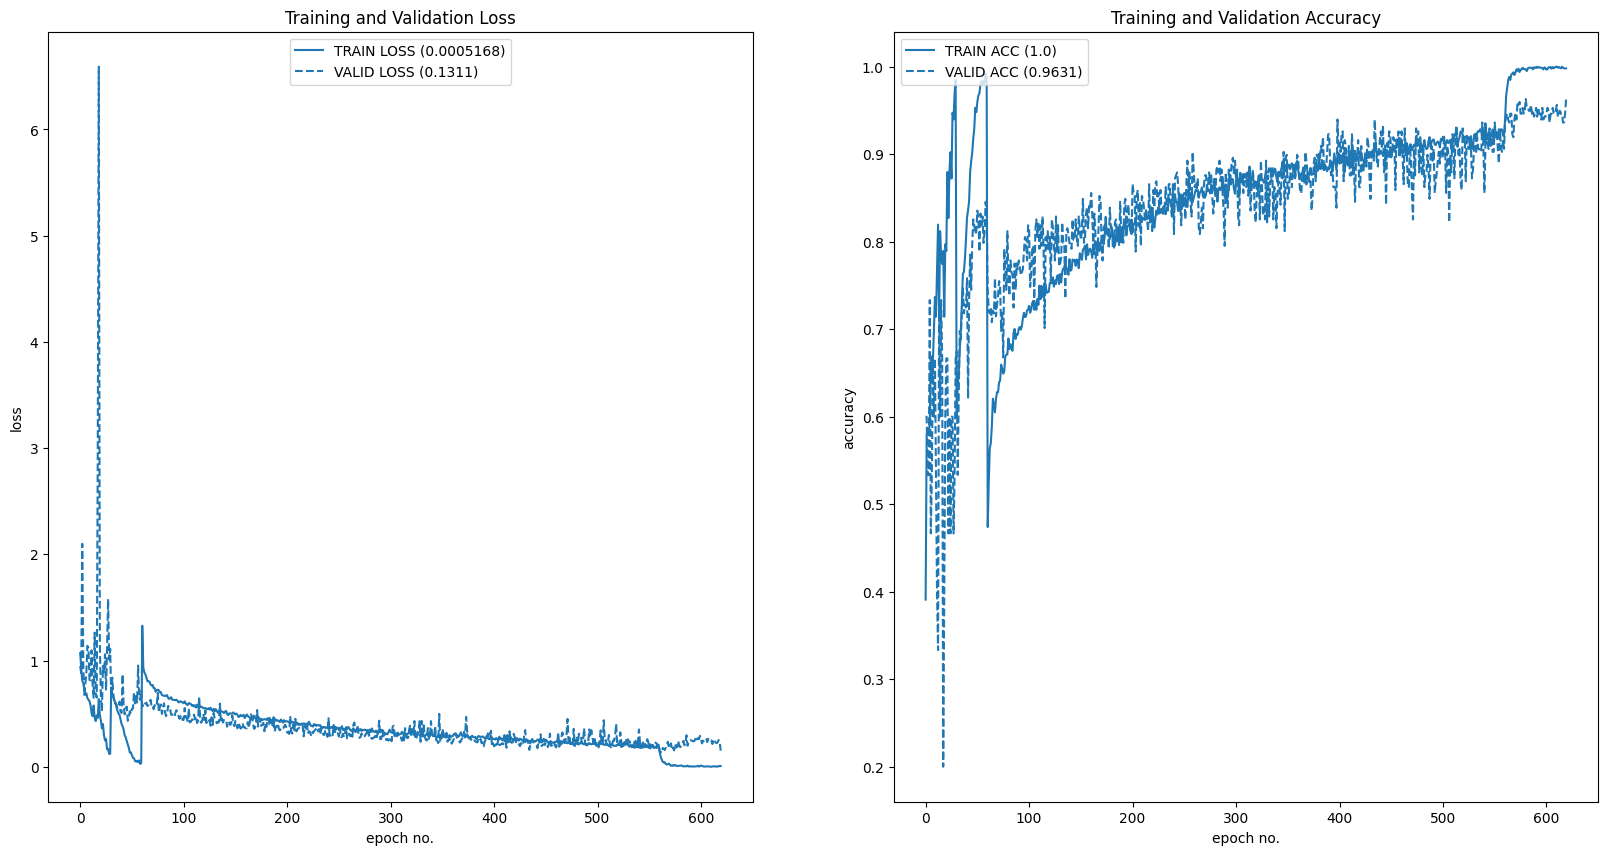

In [93]:
plot_loss_accuracy(
    train_loss=[complete_train_loss],
    val_loss=[complete_val_loss],
    train_acc=[complete_train_acc],
    val_acc=[complete_val_acc],
    colors=["blue"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

# Inference & Sample Predictions
This module provides utilities to generate model predictions on sample images and visualize results.

## Prediction Function
Performs a forward pass on a batch of inputs and returns predicted indices and probabilities.

In [23]:
def prediction(
    model: torch.nn.Module,
    device: torch.device,
    batch_input: torch.Tensor,
) -> tuple[list[int], list[float]]:
    """
    Predict class indices and probabilities for a batch of images.

    Args:
        model (torch.nn.Module): Trained CNN model.
        device (torch.device): Device for computation (CPU or CUDA).
        batch_input (torch.Tensor): Batch of preprocessed images.

    Returns:
        pred_index (list[int]): Predicted class indices.
        pred_prob (list[float]): Corresponding max probabilities.
    """
    model.to(device)
    model.eval()
    inputs = batch_input.to(device)

    with torch.no_grad():
        output = model(inputs)
        prob = F.softmax(output, dim=1)
        pred_prob, pred_index = prob.max(dim=1)

    return pred_index.cpu().tolist(), pred_prob.cpu().tolist()

## Batch Visualization

Selects evenly-spaced samples from a directory, runs prediction, and plots images with predicted vs. true labels.

In [24]:
def get_sample_prediction(
    model: torch.nn.Module,
    data_root: str,
    img_size: tuple[int, int],
    mean: list[float],
    std: list[float],
    batch_size: int = 15,
) -> None:
    """
    Display a grid of sample predictions on validation images.

    Args:
        model (torch.nn.Module): Trained model for inference.
        data_root (str): Path to class subfolders for images.
        img_size (tuple[int,int]): Resize dimensions for transforms.
        mean (list[float]): Normalization means.
        std (list[float]): Normalization stds.
        batch_size (int): Number of samples to display.
    """
    # Determine device and workers
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_workers = 8 if torch.cuda.is_available() else 2

    # Prepare datasets
    transform_norm = image_common_transforms(img_size, mean, std)
    transform_raw = image_preprocess_transforms(img_size)

    dataset_norm = datasets.ImageFolder(root=data_root, transform=transform_norm)
    dataset_raw = datasets.ImageFolder(root=data_root, transform=transform_raw)

    total = len(dataset_raw)
    indices = [int(i * total / batch_size) for i in range(batch_size)]

    imgs, inputs, targets = [], [], []
    for idx in indices:
        img_tensor, target = dataset_norm[idx]
        img_raw, _ = dataset_raw[idx]
        inputs.append(img_tensor)
        imgs.append(img_raw)
        targets.append(target)

    batch = torch.stack(inputs)
    pred_indices, pred_probs = prediction(model, device, batch)

    # Plot results
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (15, 9)
    fig = plt.figure()

    class_names = dataset_raw.classes
    for i, true_label in enumerate(targets):
        ax = fig.add_subplot(3, 5, i + 1)
        img = transforms.functional.to_pil_image(imgs[i])
        ax.imshow(img)
        ax.set_title(
            f"P: {class_names[pred_indices[i]]} ({pred_probs[i]:.2f})\nT: {class_names[true_label]}"
        )
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## Example Inference
Load the best model checkpoint, compute dataset stats, and visualize predictions.

./dataset/Train
mean: tensor([0.4706, 0.4485, 0.4001]), std: tensor([0.2723, 0.2638, 0.2662])


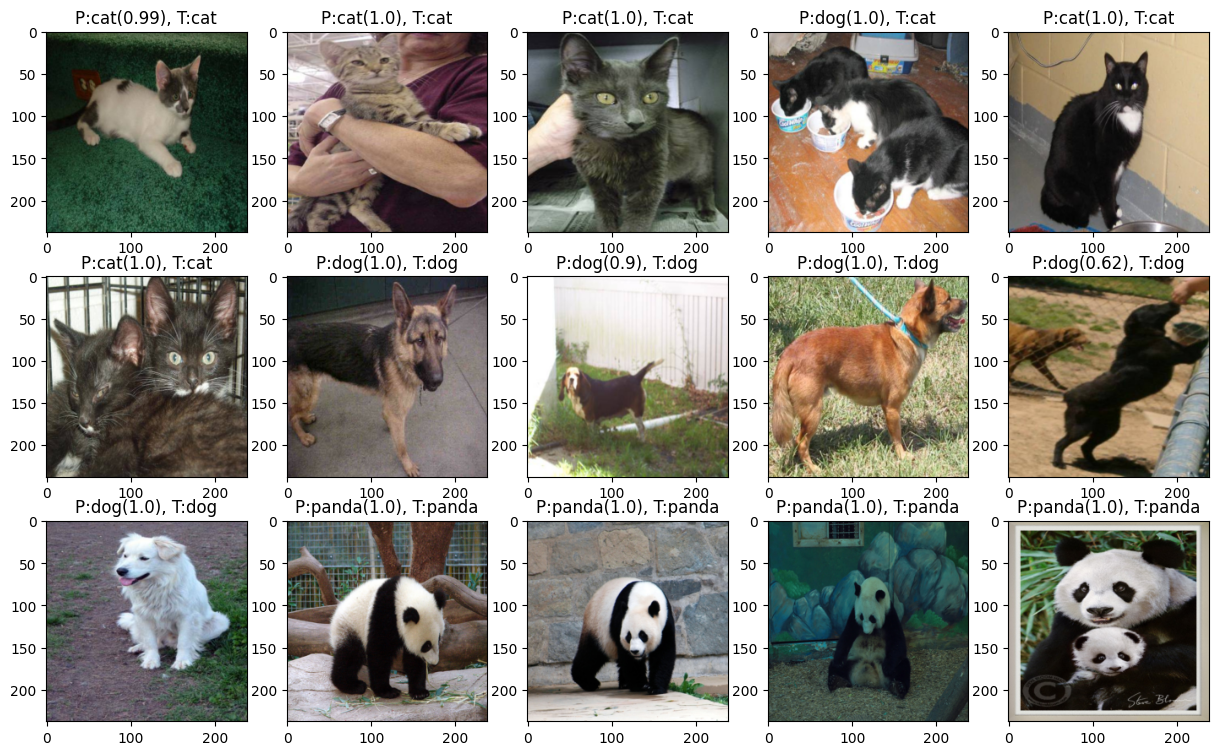

In [47]:
trained_model = CustomCNN()
trained_model = load_model(
    trained_model, 
    model_dir=training_config.checkpoint_dir, 
    model_file_name=training_config.save_best_model_name
)

train_data_path = os.path.join(training_config.data_root, "Train")
valid_data_path = os.path.join(training_config.data_root, "Valid")

mean, std = get_mean_std(train_data_path, img_size=training_config.img_size)

get_sample_prediction(trained_model, valid_data_path, img_size=training_config.img_size, mean=mean, std=std)

In [48]:
import math
def get_sample_misprediction(
    model: torch.nn.Module,
    data_root: str,
    img_size: Tuple[int, int],
    mean: List[float],
    std: List[float],
    max_images: int = 15,
) -> None:
    """
    Identify and display up to `max_images` images that the model misclassifies.

    Args:
        model: Trained model instance (should already have weights loaded).
        data_root: Path to directory containing class subfolders of images.
        img_size: (height, width) to which images are resized.
        mean: Channel-wise normalization means.
        std: Channel-wise normalization standard deviations.
        max_images: Maximum number of mispredicted images to show.

    Returns:
        None. Displays a grid of mispredicted images with their predicted vs. true labels.
    """
    batch_size=16

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    # It is important to do model.eval() before prediction.
    model.eval()

    # Send model to cpu/cuda according to your system configuration.
    model.to(device)

    # Transformed data
    valid_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(img_size, mean, std))

    # Original image dataset
    valid_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms(img_size))

    data_len = valid_dataset.__len__()

    retrieved_image_counter=0
    imgs = []
    inputs = []
    targets = []
    cls_mispred=[]
    probs_mispred=[]
    imgs_mispred=[]
    targets_mispred=[]
    while retrieved_image_counter<data_len:
        trans_input, target = valid_dataset_trans.__getitem__(retrieved_image_counter)
        img, _ = valid_dataset.__getitem__(retrieved_image_counter)
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        retrieved_image_counter+=1

        if (retrieved_image_counter%batch_size==0) or (retrieved_image_counter==data_len):
            inputs_tensors = torch.stack(inputs)
            cls, prob = prediction(model, device, batch_input=inputs_tensors)
            inputs=[]
            
            for i in range(len(cls)):
                if cls[i]!=targets[i]:
                    cls_mispred.append(cls[i])
                    probs_mispred.append(prob[i])
                    imgs_mispred.append(imgs[i])
                    targets_mispred.append(targets[i])
            cls=[]
            prob=[]
            imgs=[]
            targets=[]
            
            if len(cls_mispred)>=max_image_to_show:
                break
    
        
    image_to_show_len = min( max_image_to_show, len(cls_mispred))
    cols=5
    rows=math.ceil(image_to_show_len/cols)

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (3*cols, 4*rows)
    fig = plt.figure()

    for i in range(image_to_show_len):
        plt.subplot(rows, cols, i + 1)
        img = transforms.functional.to_pil_image(imgs_mispred[i])
        plt.imshow(img)
        plt.gca().set_title(f"P:{valid_dataset.classes[cls_mispred[i]]}({probs_mispred[i]:.2}), T:{valid_dataset.classes[targets_mispred[i]]}")
    plt.show()

    return

In [49]:
get_sample_misprediction(trained_model, train_data_path, img_size=training_config.img_size, mean=mean, std=std, max_image_to_show = 100)

<Figure size 1500x0 with 0 Axes>

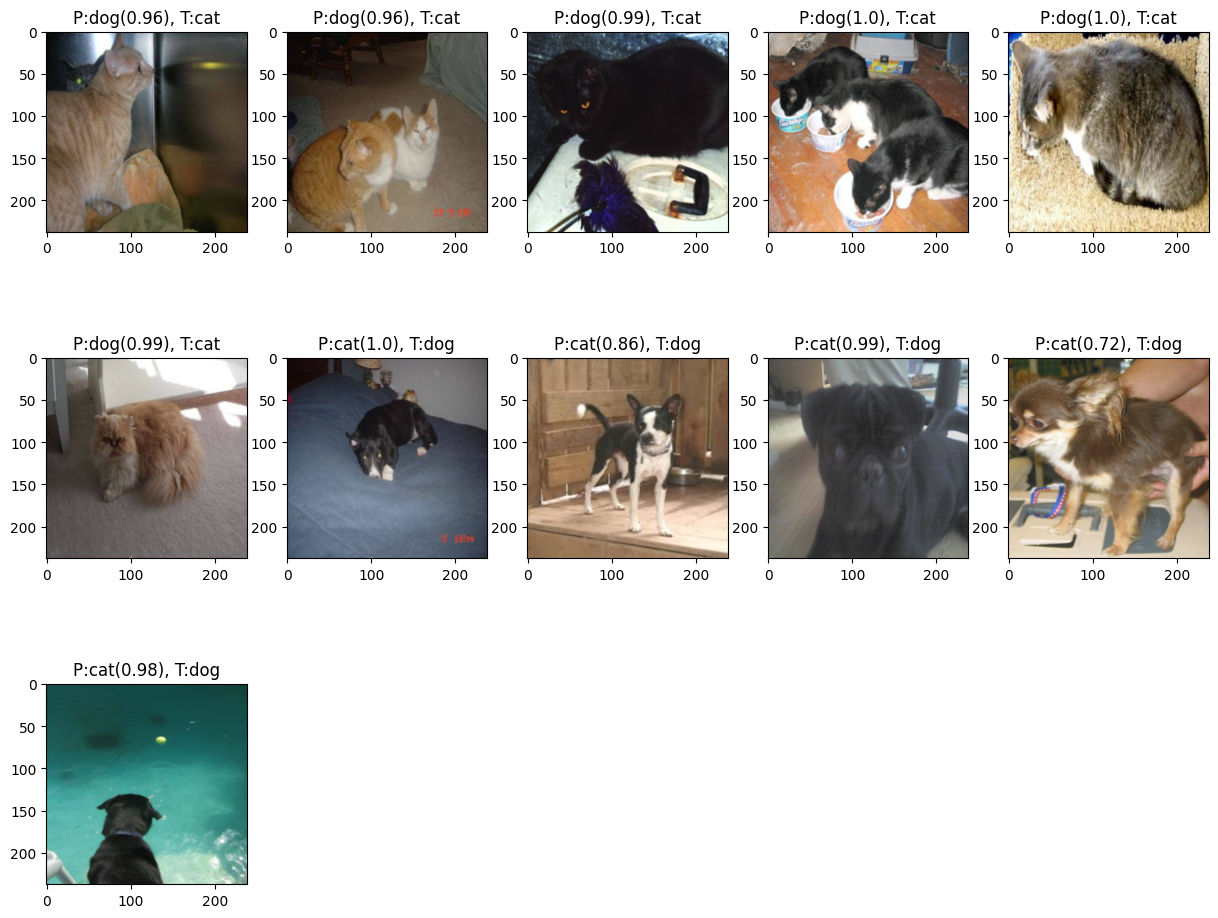

In [50]:
get_sample_misprediction(trained_model, valid_data_path, img_size=training_config.img_size, mean=mean, std=std, max_image_to_show = 100)

## Confusion Matrix

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def get_confusion_matrix(
    model: torch.nn.Module,
    data_root: str,
    img_size: Tuple[int, int],
    mean: List[float],
    std: List[float],
) -> None:
    """
    Compute and plot the confusion matrix over the entire validation set.

    Args:
        model: Trained model instance (should already have weights loaded).
        data_root: Path to directory containing class subfolders of images.
        img_size: (height, width) to which images are resized.
        mean: Channel-wise normalization means.
        std: Channel-wise normalization standard deviations.

    Returns:
        None. Displays the confusion matrix plot.
    """
    batch_size=16

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    # It is important to do model.eval() before prediction.
    model.eval()

    # Send model to cpu/cuda according to your system configuration.
    model.to(device)

    # Transformed data
    valid_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(img_size, mean, std))

    # Original image dataset
    valid_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms(img_size))

    data_len = valid_dataset.__len__()

    retrieved_image_counter=0
    imgs = []
    inputs = []
    targets = []
    cls_pred=[]
    targets_pred=[]
    while retrieved_image_counter<data_len:
        trans_input, target = valid_dataset_trans.__getitem__(retrieved_image_counter)
        img, _ = valid_dataset.__getitem__(retrieved_image_counter)
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        retrieved_image_counter+=1

        if (retrieved_image_counter%batch_size==0) or (retrieved_image_counter==data_len):
            inputs_tensors = torch.stack(inputs)
            cls, prob = prediction(model, device, batch_input=inputs_tensors)
            inputs=[]
            
            cls_pred.extend(cls)
            targets_pred.extend(targets)
            imgs=[]
            targets=[]


    # Confusion matrix
    pred_classes = ["cat","dog","panda"]
    translated_classes_pred = [pred_classes[i] for i in cls_pred]
    translated_targets_pred = [pred_classes[i] for i in targets_pred]
    cm = confusion_matrix(translated_targets_pred,
                          translated_classes_pred, 
                          labels=pred_classes, 
                          normalize=None)
    
    # Visualización
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=pred_classes
    )

    fig, ax = plt.subplots()
    disp.plot(ax=ax, xticks_rotation=45)
    plt.tight_layout()
    plt.show()

    return

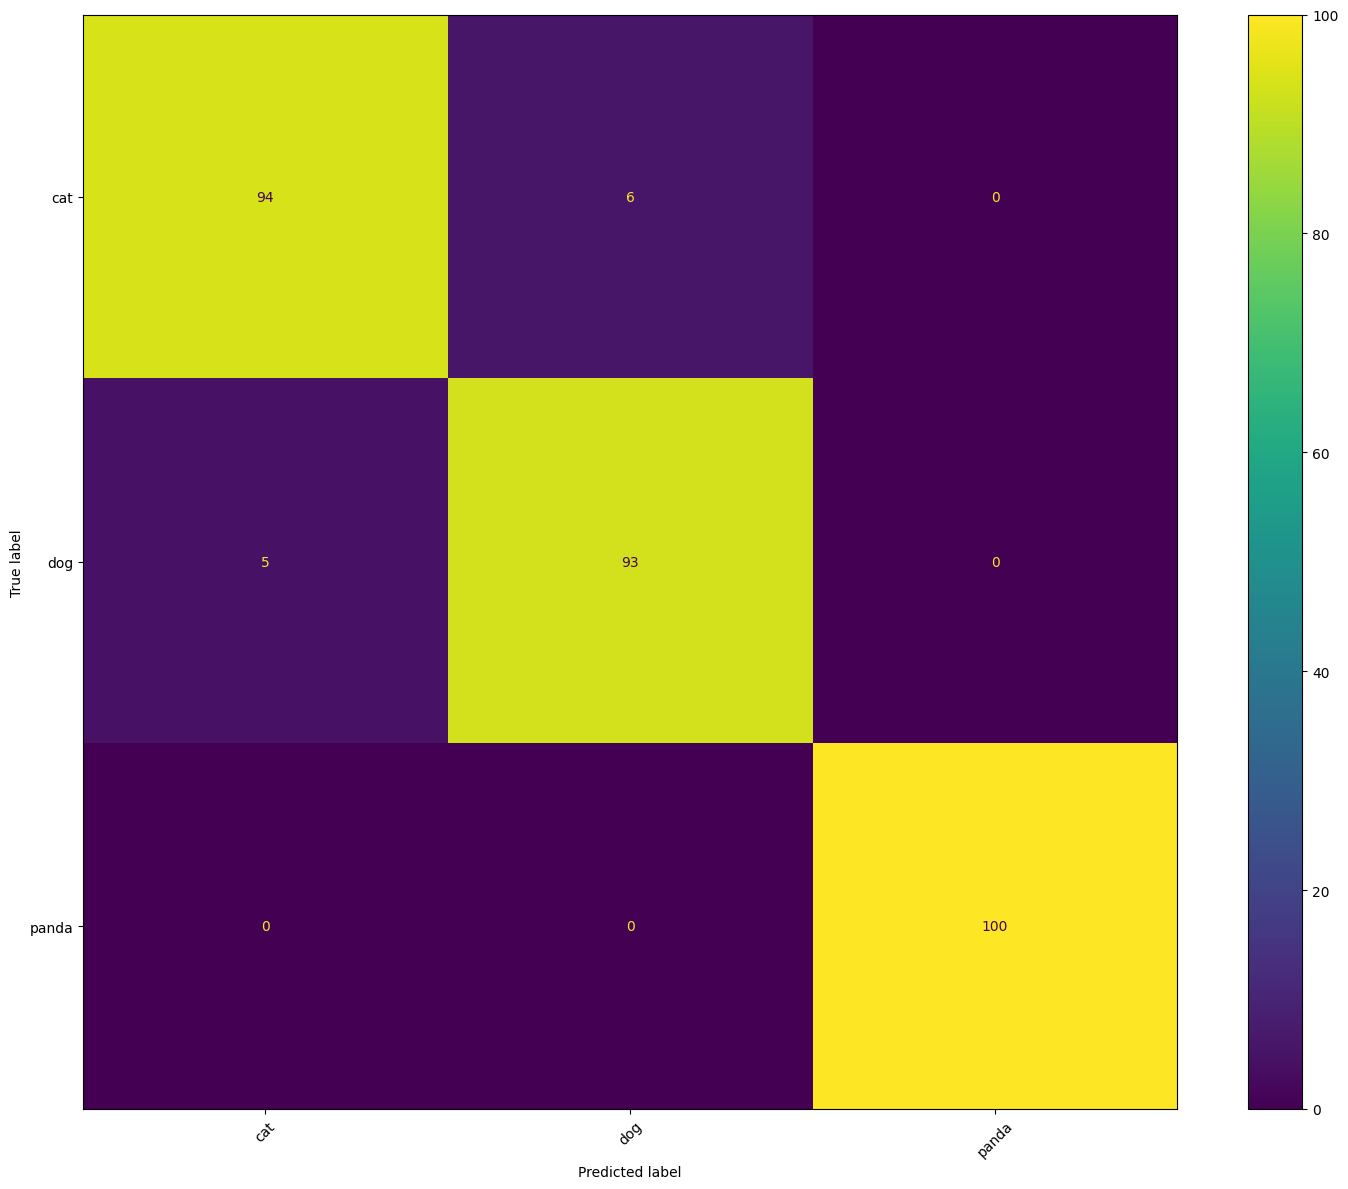

In [52]:
get_confusion_matrix(trained_model, valid_data_path, img_size=training_config.img_size, mean=mean, std=std)

# Submission Preparation & Export

Tools to generate predictions on an unlabeled test set and export a CSV for submission.

In [53]:
import pandas as pd
import glob
from PIL import Image

class FlatImageDataset(datasets.ImageFolder):
    """
    ImageFolder subclass that scans a directory (and subdirectories) for files
    matching given extensions, returning (image, filename) pairs.

    Args:
        root (str): Root directory containing images in any nested structure.
        transform (callable, optional): Transform to apply to PIL images.
        exts (tuple[str], optional): File extensions to include.
    """
    def __init__(
        self,
        root: str,
        transform=None,
        exts: tuple = (".jpg", ".jpeg", ".png", ".bmp", ".gif"),
    ):
        # Collect all file paths recursively matching extensions
        self.files = []
        for ext in exts:
            self.files.extend(glob.glob(os.path.join(root, f"**/*{ext}"), recursive=True))
        self.transform = transform

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, idx: int):
        path = self.files[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        filename = os.path.basename(path)
        return img, filename
        
def get_submission_file(
    csv_out: str,
    model: torch.nn.Module,
    data_root: str,
    img_size: tuple[int, int],
    mean: list[float],
    std: list[float],
    batch_size: int = 16,
) -> None:
    """
    Run inference on a flat test directory and export results to a CSV file.

    Args:
        csv_out (str): Output CSV filepath (will be overwritten).
        model (torch.nn.Module): Trained model instance.
        data_root (str): Directory containing test images.
        img_size (tuple[int,int]): Resize dimensions for transforms.
        mean (list[float]): Normalization means.
        std (list[float]): Normalization stds.
        batch_size (int, optional): Number of samples per inference batch.
    """
    batch_size=16

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    # It is important to do model.eval() before prediction.
    model.eval()

    # Send model to cpu/cuda according to your system configuration.
    model.to(device)

    # Transformed data
    valid_dataset_trans = FlatImageDataset(root=data_root, transform=image_common_transforms(img_size, mean, std))

    data_len = valid_dataset_trans.__len__()

    retrieved_image_counter=0
    inputs = []
    cls_pred=[]
    name_pred=[]
    while retrieved_image_counter<data_len:
        trans_input, path = valid_dataset_trans.__getitem__(retrieved_image_counter)

        #Get file id from path
        file_id = os.path.basename(path)
        name_pred.append(file_id)
        inputs.append(trans_input)
        retrieved_image_counter+=1

        if (retrieved_image_counter%batch_size==0) or (retrieved_image_counter==data_len):
            inputs_tensors = torch.stack(inputs)
            cls, prob = prediction(model, device, batch_input=inputs_tensors)
            inputs=[]
            cls_pred.extend(cls)
            
    #create and save csv with results
    pred_classes = ["cat","dog","panda"]
    df = pd.DataFrame({
        "ID":    name_pred,
        "CLASS": [pred_classes[i] for i in cls_pred]
    })
    df.to_csv(csv_out, sep=",", index=False)
    print("CSV succesfully generated!")
    return
###

In [54]:
get_submission_file("./submission.csv",trained_model, "./dataset/Test", img_size=training_config.img_size, mean=mean, std=std)

CSV succesfully generated!


# Layer Activation Visualizations

This module provides tools to hook into intermediate activations of specified layers, visualize top filters, and log them to TensorBoard.

In [55]:
class ActivationFeatures:
    """
    Attach a forward hook to a module to store its activation outputs.

    Args:
        module (nn.Module): PyTorch layer to hook.
    """
    def __init__(self, module: nn.Module):
        self.features: torch.Tensor | None = None
        self.hook = module.register_forward_hook(self._hook_fn)

    def _hook_fn(self, module: nn.Module, inputs, outputs):
        # Clone outputs to CPU
        self.features = outputs.detach().cpu().clone()

    def reset(self) -> None:
        """Clear stored features."""
        self.features = None

    def remove(self) -> None:
        """Remove the hook from the module."""
        self.hook.remove()

In [76]:
from matplotlib.gridspec import GridSpec
## Plot Top Activations

Display original image alongside top activated feature maps from a given layer.

# %% [code]
def plot_top_activations(
    image: np.ndarray,
    activations: dict[str, ActivationFeatures],
    filter_ids: list[int],
    layer_name: str,
    nrows: int = 2,
    ncols: int = 4,
) -> plt.Figure:
    """
    Plot the input image and selected activation maps.

    Args:
        image (np.ndarray): HxWxC image for display.
        activations (dict): Layer name to ActivationFeatures mapping.
        filter_ids (list[int]): Indices of filters to show.
        layer_name (str): Key of the layer in activations.
        nrows (int): Number of subplot rows.
        ncols (int): Number of subplot columns.

    Returns:
        plt.Figure: The created figure.
    """
    fig = plt.figure(figsize=(12, 6), layout="constrained")
    gs = GridSpec(nrows, ncols, figure=fig)

    # Original image
    ax_img = fig.add_subplot(gs[:, :2])
    ax_img.imshow(image)
    ax_img.set_title("Original Image", fontsize=16)
    ax_img.axis('off')

    # Activation maps
    fmap = activations[layer_name].features.squeeze(0)
    axes = []
    for i in range(nrows):
        for j in range(ncols - 2, ncols):
            axes.append(fig.add_subplot(gs[i, j]))

    for ax, fid in zip(axes, filter_ids):
        ax.imshow(fmap[fid], cmap='gray')
        ax.set_title(f"{layer_name}: filter {fid}")
        ax.axis('off')

    return fig

## Log Activations to TensorBoard

Hook into initial ReLU layers, perform a forward pass, and write top activations.

In [77]:
def add_activations(
    model: nn.Module,
    device: torch.device,
    image: torch.Tensor,
    tag: str,
    writer: SummaryWriter,
    mean: list[float],
    std: list[float],
    epoch: int,
    max_layers: int = 3,
) -> None:
    """
    Capture and log activation maps for specified ReLU layers.

    Args:
        model: Trained CNN model.
        device: Computation device.
        image: Single image tensor (C,H,W).
        tag: Tag prefix for TensorBoard.
        writer: TensorBoard writer.
        mean: Normalization mean.
        std: Normalization std.
        epoch: Global step for logging.
        max_layers: Number of ReLU layers to hook.
    """
    model.to(device).eval()

    # Prepare image
    img_np = image.permute(1, 2, 0).cpu().numpy()
    norm = transforms.Normalize(mean=mean, std=std)
    inp = norm(image).unsqueeze(0).to(device)

    # Hook first ReLU layers
    activations = {}
    relus = [m for m in model.modules() if isinstance(m, nn.ReLU)]
    for i, module in enumerate(relus[:max_layers]):
        name = f"relu_{i}"
        activations[name] = ActivationFeatures(module)

    with torch.no_grad():
        _ = model(inp)

    # Log top 4 filters per layer
    for name, hook in activations.items():
        fmap = hook.features.squeeze(0)
        means = fmap.mean(dim=(1, 2))
        topk = means.argsort(descending=True)[:4].tolist()
        fig = plot_top_activations(img_np, activations, topk, name)
        writer.add_figure(f"{tag}/{name}", fig, global_step=epoch)
        hook.reset()
        hook.remove()

## Sample Activation Logging

Select one random image per class and log activations over multiple epochs.

In [78]:
def get_sample_activations(
    data_root: str,
    model: nn.Module,
    device: torch.device,
    writer: SummaryWriter,
    epochs: int = 5,
) -> None:
    """
    For each epoch, pick one image per class and log activations.

    Args:
        data_root: Root folder with Train/Valid subfolders.
        model: Trained CNN model.
        device: Computation device.
        writer: TensorBoard writer.
        epochs: Number of epochs/iterations.
    """
    
    valid_data_path = os.path.join(data_root, "validation")
    
    preprocess_transforms = image_common_transforms(image_size, mean, std)
    
    val_data = datasets.ImageFolder(root=data_root, transform=preprocess_transforms)
    
    np.random.seed(25)
    
    rnd_idx_cat   = np.random.randint(low=0,  high=99)
    rnd_idx_dog   = np.random.randint(low=100,high=197)
    rnd_idx_panda = np.random.randint(low=198,high=297)
    
    image_cat,  _ = val_data[rnd_idx_cat]
    image_dog,  _ = val_data[rnd_idx_dog]
    image_panda,_ = val_data[rnd_idx_panda]

    add_activations(model, device, image_cat, "Image_1", summary_writer, mean, std, epoch)
    add_activations(model, device, image_dog, "Image_2", summary_writer, mean, std, epoch)
    add_activations(model, device, image_panda, "Image_3", summary_writer, mean, std, epoch)

In [ ]:
for i in range(5):
    get_sample_activations(valid_data_path,
                                   training_config.img_size,
                                   trained_model,
                                   training_config.device,
                                   summary_writer,
                                   i
                                  )

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir {training_config.root_log_dir} --samples_per_plugin images=15  --port default